### 라이브러리 import

In [1]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize, Grayscale
from torch.utils.data import DataLoader

from torch import optim
from torch.nn import functional

import matplotlib.pyplot as plt

In [2]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### AlexNet 구현

In [3]:
class MyAlexNet(nn.Module):
    def __init__(self, number_of_input_channel, number_of_class):
        super(MyAlexNet, self).__init__()
        self.network = nn.Sequential(
            # Conv 1
            nn.Conv2d(number_of_input_channel, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv 2
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv 3
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Conv 4
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Conv 5
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, number_of_class),
        )
        self.init_weight()
    
    def init_weight(self):
        for layer in self.network:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        nn.init.constant_(self.network[4].bias, 1)
        nn.init.constant_(self.network[10].bias, 1)
        nn.init.constant_(self.network[12].bias, 1)
    
    def forward(self, x):
        x = self.network(x)
        x = x.view(-1, 256 * 6* 6)
        x = self.classifier(x)
        return x

### train 및 test 메소드

In [4]:
def train(device, dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print('.', end='')
        if batch % 100 == 0:
            print()
            loss, current = loss.item(), batch*len(X)
            print(f'loss: {loss:>7f}   [{current:>5d}/{size:>5d}]')

In [5]:
def test(device, dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loass: {test_loss:>8f}\n')

In [6]:
def train_n_test(device, model, loss_fn, optimizer, train_dataloader, test_dataloader, epochs=5):
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1} \n--------------------------------')
        train(device, train_dataloader, model, loss_fn, optimizer)
        test(device, test_dataloader, model, loss_fn)

### 호출해보기 - Fashion MNIST

In [7]:
def get_subset(dataset, length):
    return torch.utils.data.Subset(dataset, [i for i in range(0, length)])

In [8]:
SUBSET_LENGTH = 10000
training_data = datasets.FashionMNIST(
    root='data', train=True, download=True,
    transform=Compose([
        ToTensor(),
        Resize(227),
    ])
)
print('original training_data size:', len(training_data))
training_data = get_subset(training_data, SUBSET_LENGTH)
print('subset training_data size:', len(training_data))

test_data = datasets.FashionMNIST(
    root='data', train=False, download=True,
    transform=Compose([
    ToTensor(),
        Resize(227),
    ])
)
print('original test_data size:', len(test_data))
test_data = get_subset(test_data, SUBSET_LENGTH)
print('subset test_data size:', len(test_data))

original training_data size: 60000
subset training_data size: 10000
original test_data size: 10000
subset test_data size: 10000


d:\program\python\python37\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
BATCH_SIZE = 64
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [10]:
classes_fashionMNIST = datasets.FashionMNIST.classes
classes_fashionMNIST

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [11]:
model_fashionMNIST = MyAlexNet(1, len(classes_fashionMNIST))
model_fashionMNIST

MyAlexNet(
  (network): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, b

In [12]:
LR_INIT = 0.001
MOMENTUM = 0.9
LR_DECAY = 0.0005

optimizer = optim.SGD(
    params=model_fashionMNIST.parameters(),
    lr=LR_INIT,
    momentum=MOMENTUM,
    weight_decay=LR_DECAY,
)
loss_fn = functional.cross_entropy
device = get_device()

In [13]:
train_n_test(device, model_fashionMNIST, loss_fn, optimizer, train_dataloader, test_dataloader, 5)

Epoch 1 
--------------------------------


d:\program\python\python37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


.
loss: 2.304781   [    0/10000]
....................................................................................................
loss: 2.298558   [ 6400/10000]
........................................................Test Error: 
 Accuracy: 10.0%, Avg loass: 2.305285

Epoch 2 
--------------------------------
.
loss: 2.275540   [    0/10000]
....................................................................................................
loss: 2.301975   [ 6400/10000]
........................................................Test Error: 
 Accuracy: 10.0%, Avg loass: 2.304813

Epoch 3 
--------------------------------
.
loss: 2.301734   [    0/10000]
....................................................................................................
loss: 2.307747   [ 6400/10000]
........................................................Test Error: 
 Accuracy: 10.0%, Avg loass: 2.303876

Epoch 4 
--------------------------------
.
loss: 2.291073   [    0/10000]
......................

In [15]:
from torchsummary import summary

def summarize(model, size):
    summary(model, input_size=size)

In [16]:
summarize(model_fashionMNIST, size=(1, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]          11,712
              ReLU-2           [-1, 96, 56, 56]               0
 LocalResponseNorm-3           [-1, 96, 56, 56]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [53]:
torch.save(model_fashionMNIST.state_dict(), 'alexnet2-models/model_fashionMNIST.pth')

### 호출해보기 - Cassava Leaf

In [19]:
cassava_leaf_home = 'd:/git/deep-learning-coursera/homework-4'

In [20]:
import json

cassava_leaf_class_names = {}
with open(cassava_leaf_home + '/dataset/label_num_to_disease_map.json') as json_file:
    json_data = json.load(json_file)
    cassava_leaf_class_names = json_data
cassava_leaf_class_names

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [27]:
import pandas as pd

cassava_leaf_train_df = pd.read_csv(cassava_leaf_home + '/dataset/train.csv')
cassava_leaf_train_df.head(3)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1


In [28]:
# Disease별 1개의 row 가져오기
def pick_one_record(df, disease_label = 0):
    filtered_df = df.loc[df['label'] == disease_label]
    return filtered_df.iloc[[0]].to_dict(orient='records')[0]

cassava_leaf_sample_images = []
for i in range(0, 5):
    record = pick_one_record(cassava_leaf_train_df, i)
    cassava_leaf_sample_images.append(record)
print('.. cassava_leaf_sample_images')
cassava_leaf_sample_images

.. cassava_leaf_sample_images


[{'image_id': '1000015157.jpg', 'label': 0},
 {'image_id': '100042118.jpg', 'label': 1},
 {'image_id': '1000910826.jpg', 'label': 2},
 {'image_id': '1000201771.jpg', 'label': 3},
 {'image_id': '1001723730.jpg', 'label': 4}]

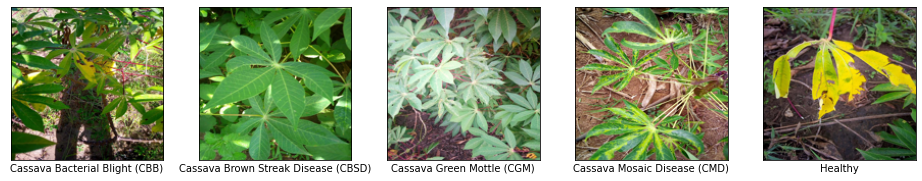

In [29]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

%matplotlib inline

img_height, img_width = 150, 150

plt.figure(figsize=(50, 50))
for i in range(5):
    plt.subplot(15, 15, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    image_path = cassava_leaf_home + '/dataset/train_images/' + sample_images[i]['image_id']
    image = np.array(Image.open(image_path).resize((img_height, img_width)))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(cassava_leaf_class_names[str(cassava_leaf_sample_images[i]['label'])], wrap=True)
plt.show()

In [41]:
import shutil

for (i, row) in cassava_leaf_train_df.iterrows():
    if (i % 1000) is 0:
        print('.', end='')
    image_path = os.path.join('./data/cassava_leaf_images', row['image_id'])
    dest_path = os.path.join('./data/refined_cassava_leaf/' +  str(row['label']), row['image_id'])
    shutil.copyfile(image_path, dest_path)

......................

In [42]:
cassava_leaf_dataset = datasets.ImageFolder('./data/refined_cassava_leaf', 
               transform=Compose([Resize((227, 227)), ToTensor()])
          )
len(cassava_leaf_dataset)

21397

In [44]:
cassava_leaf_training_data, cassava_leaf_test_data = torch.utils.data.random_split(cassava_leaf_dataset, [20000, 1397])

In [45]:
cassava_leaf_training_data, cassava_leaf_test_data, len(cassava_leaf_training_data), len(cassava_leaf_test_data)

(<torch.utils.data.dataset.Subset at 0x13202581348>,
 20000,
 1397)

In [46]:
cassava_leaf_train_dataloader = DataLoader(cassava_leaf_training_data, batch_size=BATCH_SIZE)
cassava_leaf_test_dataloader = DataLoader(cassava_leaf_test_data, batch_size=BATCH_SIZE)

In [47]:
model_cassava_leaf = MyAlexNet(3, len(cassava_leaf_class_names))
model_cassava_leaf

MyAlexNet(
  (network): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, b

In [48]:
LR_INIT = 0.001
MOMENTUM = 0.9
LR_DECAY = 0.0005

optimizer = optim.SGD(
    params=model_cassava_leaf.parameters(),
    lr=LR_INIT,
    momentum=MOMENTUM,
    weight_decay=LR_DECAY,
)
loss_fn = functional.cross_entropy
device = get_device()

In [49]:
train_n_test(device, model_cassava_leaf, loss_fn, optimizer, cassava_leaf_train_dataloader, cassava_leaf_test_dataloader, 5)

Epoch 1 
--------------------------------
.
loss: 1.634874   [    0/20000]
....................................................................................................
loss: 1.072184   [ 6400/20000]
....................................................................................................
loss: 1.308520   [12800/20000]
....................................................................................................
loss: 1.037122   [19200/20000]
............Test Error: 
 Accuracy: 62.2%, Avg loass: 1.206384

Epoch 2 
--------------------------------
.
loss: 1.360782   [    0/20000]
....................................................................................................
loss: 1.075157   [ 6400/20000]
....................................................................................................
loss: 1.282318   [12800/20000]
....................................................................................................
loss: 1.035058   [19200/2

In [50]:
summarize(model_cassava_leaf, size=(3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]          34,944
              ReLU-2           [-1, 96, 56, 56]               0
 LocalResponseNorm-3           [-1, 96, 56, 56]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [54]:
torch.save(model_cassava_leaf.state_dict(), 'alexnet2-models/model_cassava_leaf.pth')

### 호출해보기 - Cassava Leaf + Crop

In [60]:
from torchvision.transforms import CenterCrop, RandomHorizontalFlip

In [61]:
cassava_leaf_dataset_2 = datasets.ImageFolder('./data/refined_cassava_leaf', 
               transform=Compose([
                   CenterCrop(224),
                   RandomHorizontalFlip(),
                   Resize((227, 227)),
                   ToTensor()
               ])
          )
len(cassava_leaf_dataset_2)

21397

In [63]:
cassava_leaf_training_data_2, cassava_leaf_test_data_2 = torch.utils.data.random_split(cassava_leaf_dataset_2, [20000, 1397])
len(cassava_leaf_training_data_2), len(cassava_leaf_test_data_2)

(20000, 1397)

In [67]:
cassava_leaf_train_dataloader_2 = DataLoader(cassava_leaf_training_data_2, batch_size=BATCH_SIZE)
cassava_leaf_test_dataloader_2 = DataLoader(cassava_leaf_test_data_2, batch_size=BATCH_SIZE)

In [64]:
model_cassava_leaf_2 = MyAlexNet(3, len(cassava_leaf_class_names))
model_cassava_leaf_2

MyAlexNet(
  (network): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, b

In [65]:
LR_INIT = 0.001
MOMENTUM = 0.9
LR_DECAY = 0.0005

optimizer = optim.SGD(
    params=model_cassava_leaf_2.parameters(),
    lr=LR_INIT,
    momentum=MOMENTUM,
    weight_decay=LR_DECAY,
)
loss_fn = functional.cross_entropy
device = get_device()

In [68]:
train_n_test(device, model_cassava_leaf_2, loss_fn, optimizer, 
             cassava_leaf_train_dataloader_2, cassava_leaf_test_dataloader_2, 5)

Epoch 1 
--------------------------------
.
loss: 1.622143   [    0/20000]
....................................................................................................
loss: 1.108241   [ 6400/20000]
....................................................................................................
loss: 1.162953   [12800/20000]
....................................................................................................
loss: 1.148985   [19200/20000]
............Test Error: 
 Accuracy: 61.4%, Avg loass: 1.214486

Epoch 2 
--------------------------------
.
loss: 1.004819   [    0/20000]
....................................................................................................
loss: 1.117239   [ 6400/20000]
....................................................................................................
loss: 1.186529   [12800/20000]
....................................................................................................
loss: 1.140326   [19200/2

In [69]:
summarize(model_cassava_leaf_2, size=(3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]          34,944
              ReLU-2           [-1, 96, 56, 56]               0
 LocalResponseNorm-3           [-1, 96, 56, 56]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [70]:
torch.save(model_cassava_leaf_2.state_dict(), 'alexnet2-models/model_cassava_leaf_2.pth')

### 호출해보기 - Cassava Leaf + Augmentation

In [164]:
import os
import numpy as np
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, ToPILImage

def augment_images(original, dest):
    def __get_files__(path):
        res = []
        for file in os.listdir(path):
            file_path = '{}/{}'.format(path, file)
            if os.path.isdir(file_path):
                res = res + __get_files__(file_path)
            else:
                res.append(file_path)
        return res
    
    conveter = Compose([
                   RandomCrop((227, 227)),
                   RandomHorizontalFlip(),
                   ToTensor(),
                   ToPILImage(),
               ])
    original_files = __get_files__(original)
    
    for original_file in original_files:
        print(original_file)
        original_image = Image.open(original_file)
        
        # copy original file
        dest_file = '{}{}'.format(dest, original_file.replace(original, ''))
        shutil.copyfile(image_path, dest_file)
        
        conv_dest_file_name = 'c' + original_file.split('/')[-1]
        conv_dest_file = '{}/{}/{}'.format(dest, original_file.split('/')[-2], conv_dest_file_name)
        print('...', conv_dest_file)
        
        conv_image = conveter(original_image)
        conv_image.save(conv_dest_file)

In [172]:
augment_images('./data/refined_cassava_leaf', './data/augmentation_refined_cassava_leaf')

./data/refined_cassava_leaf/0/1000015157.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1000015157.jpg
./data/refined_cassava_leaf/0/1001320321.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1001320321.jpg
./data/refined_cassava_leaf/0/1003888281.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1003888281.jpg
./data/refined_cassava_leaf/0/1012426959.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1012426959.jpg
./data/refined_cassava_leaf/0/1018973237.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1018973237.jpg
./data/refined_cassava_leaf/0/102039365.jpg
... ./data/augmentation_refined_cassava_leaf/0/c102039365.jpg
./data/refined_cassava_leaf/0/1021758544.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1021758544.jpg
./data/refined_cassava_leaf/0/1024089865.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1024089865.jpg
./data/refined_cassava_leaf/0/102485576.jpg
... ./data/augmentation_refined_cassava_leaf/0/c102485576.jpg
./data/refined_cassava_leaf/0/10

... ./data/augmentation_refined_cassava_leaf/0/c1304015285.jpg
./data/refined_cassava_leaf/0/1312770396.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1312770396.jpg
./data/refined_cassava_leaf/0/1312991272.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1312991272.jpg
./data/refined_cassava_leaf/0/1315872826.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1315872826.jpg
./data/refined_cassava_leaf/0/1322108824.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1322108824.jpg
./data/refined_cassava_leaf/0/1326787301.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1326787301.jpg
./data/refined_cassava_leaf/0/1328372449.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1328372449.jpg
./data/refined_cassava_leaf/0/1331134229.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1331134229.jpg
./data/refined_cassava_leaf/0/1332424855.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1332424855.jpg
./data/refined_cassava_leaf/0/1333580402.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/0/1569164715.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1569164715.jpg
./data/refined_cassava_leaf/0/1569692154.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1569692154.jpg
./data/refined_cassava_leaf/0/1573602024.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1573602024.jpg
./data/refined_cassava_leaf/0/1575866220.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1575866220.jpg
./data/refined_cassava_leaf/0/1576606254.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1576606254.jpg
./data/refined_cassava_leaf/0/1578564024.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1578564024.jpg
./data/refined_cassava_leaf/0/1584698721.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1584698721.jpg
./data/refined_cassava_leaf/0/1586292581.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1586292581.jpg
./data/refined_cassava_leaf/0/1595141360.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1595141360.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/0/c1881994461.jpg
./data/refined_cassava_leaf/0/1889205491.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1889205491.jpg
./data/refined_cassava_leaf/0/1889215655.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1889215655.jpg
./data/refined_cassava_leaf/0/1893906773.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1893906773.jpg
./data/refined_cassava_leaf/0/190449795.jpg
... ./data/augmentation_refined_cassava_leaf/0/c190449795.jpg
./data/refined_cassava_leaf/0/1905665106.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1905665106.jpg
./data/refined_cassava_leaf/0/1905806148.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1905806148.jpg
./data/refined_cassava_leaf/0/190698162.jpg
... ./data/augmentation_refined_cassava_leaf/0/c190698162.jpg
./data/refined_cassava_leaf/0/1907786974.jpg
... ./data/augmentation_refined_cassava_leaf/0/c1907786974.jpg
./data/refined_cassava_leaf/0/1908179787.jpg
... ./data/augmentation_refined_

... ./data/augmentation_refined_cassava_leaf/0/c2209572670.jpg
./data/refined_cassava_leaf/0/2221240763.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2221240763.jpg
./data/refined_cassava_leaf/0/2228874754.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2228874754.jpg
./data/refined_cassava_leaf/0/2233347534.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2233347534.jpg
./data/refined_cassava_leaf/0/2235761050.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2235761050.jpg
./data/refined_cassava_leaf/0/223668500.jpg
... ./data/augmentation_refined_cassava_leaf/0/c223668500.jpg
./data/refined_cassava_leaf/0/2243019094.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2243019094.jpg
./data/refined_cassava_leaf/0/224347038.jpg
... ./data/augmentation_refined_cassava_leaf/0/c224347038.jpg
./data/refined_cassava_leaf/0/2246807690.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2246807690.jpg
./data/refined_cassava_leaf/0/2253776549.jpg
... ./data/augmentation_refined_

... ./data/augmentation_refined_cassava_leaf/0/c2467650038.jpg
./data/refined_cassava_leaf/0/2467892554.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2467892554.jpg
./data/refined_cassava_leaf/0/2468469374.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2468469374.jpg
./data/refined_cassava_leaf/0/2473268326.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2473268326.jpg
./data/refined_cassava_leaf/0/2474050099.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2474050099.jpg
./data/refined_cassava_leaf/0/2478144118.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2478144118.jpg
./data/refined_cassava_leaf/0/2480715944.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2480715944.jpg
./data/refined_cassava_leaf/0/2483045169.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2483045169.jpg
./data/refined_cassava_leaf/0/2490112634.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2490112634.jpg
./data/refined_cassava_leaf/0/249609077.jpg
... ./data/augmentation_refin

./data/refined_cassava_leaf/0/2696226006.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2696226006.jpg
./data/refined_cassava_leaf/0/2698127956.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2698127956.jpg
./data/refined_cassava_leaf/0/2698271190.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2698271190.jpg
./data/refined_cassava_leaf/0/2700385487.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2700385487.jpg
./data/refined_cassava_leaf/0/2703475066.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2703475066.jpg
./data/refined_cassava_leaf/0/2708637326.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2708637326.jpg
./data/refined_cassava_leaf/0/27094452.jpg
... ./data/augmentation_refined_cassava_leaf/0/c27094452.jpg
./data/refined_cassava_leaf/0/2710475925.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2710475925.jpg
./data/refined_cassava_leaf/0/2713739675.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2713739675.jpg
./data/refined_cassava_leaf/0/27

... ./data/augmentation_refined_cassava_leaf/0/c2989643303.jpg
./data/refined_cassava_leaf/0/2998136552.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2998136552.jpg
./data/refined_cassava_leaf/0/2998282647.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2998282647.jpg
./data/refined_cassava_leaf/0/2999350296.jpg
... ./data/augmentation_refined_cassava_leaf/0/c2999350296.jpg
./data/refined_cassava_leaf/0/300508785.jpg
... ./data/augmentation_refined_cassava_leaf/0/c300508785.jpg
./data/refined_cassava_leaf/0/3007566713.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3007566713.jpg
./data/refined_cassava_leaf/0/3010280604.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3010280604.jpg
./data/refined_cassava_leaf/0/3020106528.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3020106528.jpg
./data/refined_cassava_leaf/0/3023321786.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3023321786.jpg
./data/refined_cassava_leaf/0/303061561.jpg
... ./data/augmentation_refined

./data/refined_cassava_leaf/0/3302044032.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3302044032.jpg
./data/refined_cassava_leaf/0/3306255309.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3306255309.jpg
./data/refined_cassava_leaf/0/3307432740.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3307432740.jpg
./data/refined_cassava_leaf/0/33138536.jpg
... ./data/augmentation_refined_cassava_leaf/0/c33138536.jpg
./data/refined_cassava_leaf/0/3315826749.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3315826749.jpg
./data/refined_cassava_leaf/0/3327250048.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3327250048.jpg
./data/refined_cassava_leaf/0/3331601570.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3331601570.jpg
./data/refined_cassava_leaf/0/3334543433.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3334543433.jpg
./data/refined_cassava_leaf/0/3335121390.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3335121390.jpg
./data/refined_cassava_leaf/0/33

./data/refined_cassava_leaf/0/3533601057.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3533601057.jpg
./data/refined_cassava_leaf/0/3535017534.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3535017534.jpg
./data/refined_cassava_leaf/0/3536435427.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3536435427.jpg
./data/refined_cassava_leaf/0/353746186.jpg
... ./data/augmentation_refined_cassava_leaf/0/c353746186.jpg
./data/refined_cassava_leaf/0/3540803278.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3540803278.jpg
./data/refined_cassava_leaf/0/3546582626.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3546582626.jpg
./data/refined_cassava_leaf/0/3548257728.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3548257728.jpg
./data/refined_cassava_leaf/0/3551135685.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3551135685.jpg
./data/refined_cassava_leaf/0/3553878956.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3553878956.jpg
./data/refined_cassava_leaf/0/

./data/refined_cassava_leaf/0/3813128079.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3813128079.jpg
./data/refined_cassava_leaf/0/3818300635.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3818300635.jpg
./data/refined_cassava_leaf/0/381935936.jpg
... ./data/augmentation_refined_cassava_leaf/0/c381935936.jpg
./data/refined_cassava_leaf/0/3824530434.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3824530434.jpg
./data/refined_cassava_leaf/0/3826670209.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3826670209.jpg
./data/refined_cassava_leaf/0/3836245009.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3836245009.jpg
./data/refined_cassava_leaf/0/3844780526.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3844780526.jpg
./data/refined_cassava_leaf/0/3850139583.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3850139583.jpg
./data/refined_cassava_leaf/0/3856935048.jpg
... ./data/augmentation_refined_cassava_leaf/0/c3856935048.jpg
./data/refined_cassava_leaf/0/

... ./data/augmentation_refined_cassava_leaf/0/c4100817891.jpg
./data/refined_cassava_leaf/0/410556634.jpg
... ./data/augmentation_refined_cassava_leaf/0/c410556634.jpg
./data/refined_cassava_leaf/0/4117744697.jpg
... ./data/augmentation_refined_cassava_leaf/0/c4117744697.jpg
./data/refined_cassava_leaf/0/4130341996.jpg
... ./data/augmentation_refined_cassava_leaf/0/c4130341996.jpg
./data/refined_cassava_leaf/0/4135070493.jpg
... ./data/augmentation_refined_cassava_leaf/0/c4135070493.jpg
./data/refined_cassava_leaf/0/4145471533.jpg
... ./data/augmentation_refined_cassava_leaf/0/c4145471533.jpg
./data/refined_cassava_leaf/0/4145595052.jpg
... ./data/augmentation_refined_cassava_leaf/0/c4145595052.jpg
./data/refined_cassava_leaf/0/4149439273.jpg
... ./data/augmentation_refined_cassava_leaf/0/c4149439273.jpg
./data/refined_cassava_leaf/0/4150882054.jpg
... ./data/augmentation_refined_cassava_leaf/0/c4150882054.jpg
./data/refined_cassava_leaf/0/4153204450.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/0/539640759.jpg
... ./data/augmentation_refined_cassava_leaf/0/c539640759.jpg
./data/refined_cassava_leaf/0/543908014.jpg
... ./data/augmentation_refined_cassava_leaf/0/c543908014.jpg
./data/refined_cassava_leaf/0/544530143.jpg
... ./data/augmentation_refined_cassava_leaf/0/c544530143.jpg
./data/refined_cassava_leaf/0/545499966.jpg
... ./data/augmentation_refined_cassava_leaf/0/c545499966.jpg
./data/refined_cassava_leaf/0/550691642.jpg
... ./data/augmentation_refined_cassava_leaf/0/c550691642.jpg
./data/refined_cassava_leaf/0/5511383.jpg
... ./data/augmentation_refined_cassava_leaf/0/c5511383.jpg
./data/refined_cassava_leaf/0/552242420.jpg
... ./data/augmentation_refined_cassava_leaf/0/c552242420.jpg
./data/refined_cassava_leaf/0/553294224.jpg
... ./data/augmentation_refined_cassava_leaf/0/c553294224.jpg
./data/refined_cassava_leaf/0/561444501.jpg
... ./data/augmentation_refined_cassava_leaf/0/c561444501.jpg
./data/refined_cassava_leaf/0/564511381.jpg
... ./

./data/refined_cassava_leaf/0/833082515.jpg
... ./data/augmentation_refined_cassava_leaf/0/c833082515.jpg
./data/refined_cassava_leaf/0/851450770.jpg
... ./data/augmentation_refined_cassava_leaf/0/c851450770.jpg
./data/refined_cassava_leaf/0/860744310.jpg
... ./data/augmentation_refined_cassava_leaf/0/c860744310.jpg
./data/refined_cassava_leaf/0/868275841.jpg
... ./data/augmentation_refined_cassava_leaf/0/c868275841.jpg
./data/refined_cassava_leaf/0/87703299.jpg
... ./data/augmentation_refined_cassava_leaf/0/c87703299.jpg
./data/refined_cassava_leaf/0/878188830.jpg
... ./data/augmentation_refined_cassava_leaf/0/c878188830.jpg
./data/refined_cassava_leaf/0/886449535.jpg
... ./data/augmentation_refined_cassava_leaf/0/c886449535.jpg
./data/refined_cassava_leaf/0/888355689.jpg
... ./data/augmentation_refined_cassava_leaf/0/c888355689.jpg
./data/refined_cassava_leaf/0/897638042.jpg
... ./data/augmentation_refined_cassava_leaf/0/c897638042.jpg
./data/refined_cassava_leaf/0/901404486.jpg
... 

... ./data/augmentation_refined_cassava_leaf/1/c1069985474.jpg
./data/refined_cassava_leaf/1/1072157342.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1072157342.jpg
./data/refined_cassava_leaf/1/1072259548.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1072259548.jpg
./data/refined_cassava_leaf/1/107350755.jpg
... ./data/augmentation_refined_cassava_leaf/1/c107350755.jpg
./data/refined_cassava_leaf/1/1074333151.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1074333151.jpg
./data/refined_cassava_leaf/1/1074461567.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1074461567.jpg
./data/refined_cassava_leaf/1/1076964019.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1076964019.jpg
./data/refined_cassava_leaf/1/1077032520.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1077032520.jpg
./data/refined_cassava_leaf/1/1078061341.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1078061341.jpg
./data/refined_cassava_leaf/1/1078779441.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/1/c1177346702.jpg
./data/refined_cassava_leaf/1/1178519877.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1178519877.jpg
./data/refined_cassava_leaf/1/1181473732.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1181473732.jpg
./data/refined_cassava_leaf/1/1182166221.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1182166221.jpg
./data/refined_cassava_leaf/1/1185924788.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1185924788.jpg
./data/refined_cassava_leaf/1/1186992492.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1186992492.jpg
./data/refined_cassava_leaf/1/1191974622.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1191974622.jpg
./data/refined_cassava_leaf/1/1193048805.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1193048805.jpg
./data/refined_cassava_leaf/1/1193197595.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1193197595.jpg
./data/refined_cassava_leaf/1/1194287929.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/1/c131746797.jpg
./data/refined_cassava_leaf/1/1317841019.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1317841019.jpg
./data/refined_cassava_leaf/1/1319853450.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1319853450.jpg
./data/refined_cassava_leaf/1/132012134.jpg
... ./data/augmentation_refined_cassava_leaf/1/c132012134.jpg
./data/refined_cassava_leaf/1/1327766969.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1327766969.jpg
./data/refined_cassava_leaf/1/1330845250.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1330845250.jpg
./data/refined_cassava_leaf/1/1331106068.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1331106068.jpg
./data/refined_cassava_leaf/1/1331843412.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1331843412.jpg
./data/refined_cassava_leaf/1/1332476551.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1332476551.jpg
./data/refined_cassava_leaf/1/1332894133.jpg
... ./data/augmentation_refined

... ./data/augmentation_refined_cassava_leaf/1/c1433079784.jpg
./data/refined_cassava_leaf/1/1444285375.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1444285375.jpg
./data/refined_cassava_leaf/1/1445721278.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1445721278.jpg
./data/refined_cassava_leaf/1/1447962374.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1447962374.jpg
./data/refined_cassava_leaf/1/1448897511.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1448897511.jpg
./data/refined_cassava_leaf/1/1450787226.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1450787226.jpg
./data/refined_cassava_leaf/1/1452252314.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1452252314.jpg
./data/refined_cassava_leaf/1/1453190275.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1453190275.jpg
./data/refined_cassava_leaf/1/1455906876.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1455906876.jpg
./data/refined_cassava_leaf/1/1457537356.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/1/1603130456.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1603130456.jpg
./data/refined_cassava_leaf/1/1603729463.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1603729463.jpg
./data/refined_cassava_leaf/1/1604328731.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1604328731.jpg
./data/refined_cassava_leaf/1/1606494561.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1606494561.jpg
./data/refined_cassava_leaf/1/1606801147.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1606801147.jpg
./data/refined_cassava_leaf/1/1610520050.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1610520050.jpg
./data/refined_cassava_leaf/1/1613918546.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1613918546.jpg
./data/refined_cassava_leaf/1/1615919700.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1615919700.jpg
./data/refined_cassava_leaf/1/1622568975.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1622568975.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/1/1769894805.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1769894805.jpg
./data/refined_cassava_leaf/1/1770746162.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1770746162.jpg
./data/refined_cassava_leaf/1/1772260831.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1772260831.jpg
./data/refined_cassava_leaf/1/1772421330.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1772421330.jpg
./data/refined_cassava_leaf/1/1773042943.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1773042943.jpg
./data/refined_cassava_leaf/1/1773381712.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1773381712.jpg
./data/refined_cassava_leaf/1/1775343418.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1775343418.jpg
./data/refined_cassava_leaf/1/1779278752.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1779278752.jpg
./data/refined_cassava_leaf/1/1781932612.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1781932612.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/1/c1921138686.jpg
./data/refined_cassava_leaf/1/192315586.jpg
... ./data/augmentation_refined_cassava_leaf/1/c192315586.jpg
./data/refined_cassava_leaf/1/1924914.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1924914.jpg
./data/refined_cassava_leaf/1/1925077855.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1925077855.jpg
./data/refined_cassava_leaf/1/1925563620.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1925563620.jpg
./data/refined_cassava_leaf/1/1928188434.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1928188434.jpg
./data/refined_cassava_leaf/1/1928547462.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1928547462.jpg
./data/refined_cassava_leaf/1/1928678720.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1928678720.jpg
./data/refined_cassava_leaf/1/1929477466.jpg
... ./data/augmentation_refined_cassava_leaf/1/c1929477466.jpg
./data/refined_cassava_leaf/1/193330948.jpg
... ./data/augmentation_refined_cassa

... ./data/augmentation_refined_cassava_leaf/1/c2036664947.jpg
./data/refined_cassava_leaf/1/2045155911.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2045155911.jpg
./data/refined_cassava_leaf/1/2051629821.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2051629821.jpg
./data/refined_cassava_leaf/1/2052664728.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2052664728.jpg
./data/refined_cassava_leaf/1/205418485.jpg
... ./data/augmentation_refined_cassava_leaf/1/c205418485.jpg
./data/refined_cassava_leaf/1/2055831715.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2055831715.jpg
./data/refined_cassava_leaf/1/2056049935.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2056049935.jpg
./data/refined_cassava_leaf/1/2057361034.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2057361034.jpg
./data/refined_cassava_leaf/1/2058954954.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2058954954.jpg
./data/refined_cassava_leaf/1/2059048377.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/1/c2207984247.jpg
./data/refined_cassava_leaf/1/2209171783.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2209171783.jpg
./data/refined_cassava_leaf/1/2210767635.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2210767635.jpg
./data/refined_cassava_leaf/1/2213611476.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2213611476.jpg
./data/refined_cassava_leaf/1/2217792341.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2217792341.jpg
./data/refined_cassava_leaf/1/2218341655.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2218341655.jpg
./data/refined_cassava_leaf/1/2218943916.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2218943916.jpg
./data/refined_cassava_leaf/1/2219671077.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2219671077.jpg
./data/refined_cassava_leaf/1/2220309469.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2220309469.jpg
./data/refined_cassava_leaf/1/2221889127.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/1/2350967286.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2350967286.jpg
./data/refined_cassava_leaf/1/235457255.jpg
... ./data/augmentation_refined_cassava_leaf/1/c235457255.jpg
./data/refined_cassava_leaf/1/2360034731.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2360034731.jpg
./data/refined_cassava_leaf/1/2360219918.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2360219918.jpg
./data/refined_cassava_leaf/1/2360611086.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2360611086.jpg
./data/refined_cassava_leaf/1/2361272230.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2361272230.jpg
./data/refined_cassava_leaf/1/2361399280.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2361399280.jpg
./data/refined_cassava_leaf/1/236178051.jpg
... ./data/augmentation_refined_cassava_leaf/1/c236178051.jpg
./data/refined_cassava_leaf/1/2363936376.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2363936376.jpg
./data/refined_cassava_leaf/1/23

... ./data/augmentation_refined_cassava_leaf/1/c2481954386.jpg
./data/refined_cassava_leaf/1/2482667092.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2482667092.jpg
./data/refined_cassava_leaf/1/2484373271.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2484373271.jpg
./data/refined_cassava_leaf/1/2488940657.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2488940657.jpg
./data/refined_cassava_leaf/1/2489013604.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2489013604.jpg
./data/refined_cassava_leaf/1/2490802199.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2490802199.jpg
./data/refined_cassava_leaf/1/249317058.jpg
... ./data/augmentation_refined_cassava_leaf/1/c249317058.jpg
./data/refined_cassava_leaf/1/2494405997.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2494405997.jpg
./data/refined_cassava_leaf/1/2496275543.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2496275543.jpg
./data/refined_cassava_leaf/1/2496742167.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/1/2614256143.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2614256143.jpg
./data/refined_cassava_leaf/1/2614438244.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2614438244.jpg
./data/refined_cassava_leaf/1/2616538732.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2616538732.jpg
./data/refined_cassava_leaf/1/2617328550.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2617328550.jpg
./data/refined_cassava_leaf/1/2618313082.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2618313082.jpg
./data/refined_cassava_leaf/1/2620149411.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2620149411.jpg
./data/refined_cassava_leaf/1/2620830475.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2620830475.jpg
./data/refined_cassava_leaf/1/2621947862.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2621947862.jpg
./data/refined_cassava_leaf/1/2623148776.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2623148776.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/1/2753309511.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2753309511.jpg
./data/refined_cassava_leaf/1/2759146229.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2759146229.jpg
./data/refined_cassava_leaf/1/2759256201.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2759256201.jpg
./data/refined_cassava_leaf/1/2759737963.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2759737963.jpg
./data/refined_cassava_leaf/1/2760272941.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2760272941.jpg
./data/refined_cassava_leaf/1/2760869322.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2760869322.jpg
./data/refined_cassava_leaf/1/2761115186.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2761115186.jpg
./data/refined_cassava_leaf/1/2763304605.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2763304605.jpg
./data/refined_cassava_leaf/1/2764505542.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2764505542.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/1/c2903545051.jpg
./data/refined_cassava_leaf/1/2904005710.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2904005710.jpg
./data/refined_cassava_leaf/1/2905371700.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2905371700.jpg
./data/refined_cassava_leaf/1/2907433779.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2907433779.jpg
./data/refined_cassava_leaf/1/290867441.jpg
... ./data/augmentation_refined_cassava_leaf/1/c290867441.jpg
./data/refined_cassava_leaf/1/2908770842.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2908770842.jpg
./data/refined_cassava_leaf/1/2912412850.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2912412850.jpg
./data/refined_cassava_leaf/1/2912819166.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2912819166.jpg
./data/refined_cassava_leaf/1/2913981436.jpg
... ./data/augmentation_refined_cassava_leaf/1/c2913981436.jpg
./data/refined_cassava_leaf/1/2916268128.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/1/c3040241097.jpg
./data/refined_cassava_leaf/1/3041790402.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3041790402.jpg
./data/refined_cassava_leaf/1/3041990872.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3041990872.jpg
./data/refined_cassava_leaf/1/3042406663.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3042406663.jpg
./data/refined_cassava_leaf/1/3043097813.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3043097813.jpg
./data/refined_cassava_leaf/1/3052959460.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3052959460.jpg
./data/refined_cassava_leaf/1/305323841.jpg
... ./data/augmentation_refined_cassava_leaf/1/c305323841.jpg
./data/refined_cassava_leaf/1/3053524603.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3053524603.jpg
./data/refined_cassava_leaf/1/3056721396.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3056721396.jpg
./data/refined_cassava_leaf/1/3057285715.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/1/c318812072.jpg
./data/refined_cassava_leaf/1/3191071294.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3191071294.jpg
./data/refined_cassava_leaf/1/3193577634.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3193577634.jpg
./data/refined_cassava_leaf/1/3196839385.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3196839385.jpg
./data/refined_cassava_leaf/1/319688327.jpg
... ./data/augmentation_refined_cassava_leaf/1/c319688327.jpg
./data/refined_cassava_leaf/1/3199571684.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3199571684.jpg
./data/refined_cassava_leaf/1/3199643560.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3199643560.jpg
./data/refined_cassava_leaf/1/3203940789.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3203940789.jpg
./data/refined_cassava_leaf/1/3204522737.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3204522737.jpg
./data/refined_cassava_leaf/1/3205007771.jpg
... ./data/augmentation_refined

./data/refined_cassava_leaf/1/334288239.jpg
... ./data/augmentation_refined_cassava_leaf/1/c334288239.jpg
./data/refined_cassava_leaf/1/3343110057.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3343110057.jpg
./data/refined_cassava_leaf/1/3344007463.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3344007463.jpg
./data/refined_cassava_leaf/1/3346966351.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3346966351.jpg
./data/refined_cassava_leaf/1/3347545196.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3347545196.jpg
./data/refined_cassava_leaf/1/3347996516.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3347996516.jpg
./data/refined_cassava_leaf/1/3351977110.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3351977110.jpg
./data/refined_cassava_leaf/1/3354881630.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3354881630.jpg
./data/refined_cassava_leaf/1/335796643.jpg
... ./data/augmentation_refined_cassava_leaf/1/c335796643.jpg
./data/refined_cassava_leaf/1/33

... ./data/augmentation_refined_cassava_leaf/1/c3473125611.jpg
./data/refined_cassava_leaf/1/3474085074.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3474085074.jpg
./data/refined_cassava_leaf/1/3477094015.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3477094015.jpg
./data/refined_cassava_leaf/1/3477169212.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3477169212.jpg
./data/refined_cassava_leaf/1/3479082158.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3479082158.jpg
./data/refined_cassava_leaf/1/3479361153.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3479361153.jpg
./data/refined_cassava_leaf/1/3483686543.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3483686543.jpg
./data/refined_cassava_leaf/1/3484566225.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3484566225.jpg
./data/refined_cassava_leaf/1/3485236762.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3485236762.jpg
./data/refined_cassava_leaf/1/3486341851.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/1/3647124621.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3647124621.jpg
./data/refined_cassava_leaf/1/3649285117.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3649285117.jpg
./data/refined_cassava_leaf/1/3652033201.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3652033201.jpg
./data/refined_cassava_leaf/1/3652093161.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3652093161.jpg
./data/refined_cassava_leaf/1/3654735645.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3654735645.jpg
./data/refined_cassava_leaf/1/365488535.jpg
... ./data/augmentation_refined_cassava_leaf/1/c365488535.jpg
./data/refined_cassava_leaf/1/3656998236.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3656998236.jpg
./data/refined_cassava_leaf/1/365712595.jpg
... ./data/augmentation_refined_cassava_leaf/1/c365712595.jpg
./data/refined_cassava_leaf/1/3659088750.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3659088750.jpg
./data/refined_cassava_leaf/1/36

... ./data/augmentation_refined_cassava_leaf/1/c3801409970.jpg
./data/refined_cassava_leaf/1/3803823261.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3803823261.jpg
./data/refined_cassava_leaf/1/3803904228.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3803904228.jpg
./data/refined_cassava_leaf/1/3810809174.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3810809174.jpg
./data/refined_cassava_leaf/1/3815389777.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3815389777.jpg
./data/refined_cassava_leaf/1/3817881110.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3817881110.jpg
./data/refined_cassava_leaf/1/3819082104.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3819082104.jpg
./data/refined_cassava_leaf/1/3821611662.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3821611662.jpg
./data/refined_cassava_leaf/1/3821677855.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3821677855.jpg
./data/refined_cassava_leaf/1/3823764652.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/1/c3945661310.jpg
./data/refined_cassava_leaf/1/3945696869.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3945696869.jpg
./data/refined_cassava_leaf/1/3945872805.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3945872805.jpg
./data/refined_cassava_leaf/1/3946178245.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3946178245.jpg
./data/refined_cassava_leaf/1/3953648207.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3953648207.jpg
./data/refined_cassava_leaf/1/3953857113.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3953857113.jpg
./data/refined_cassava_leaf/1/3956077728.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3956077728.jpg
./data/refined_cassava_leaf/1/3956372146.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3956372146.jpg
./data/refined_cassava_leaf/1/3957819631.jpg
... ./data/augmentation_refined_cassava_leaf/1/c3957819631.jpg
./data/refined_cassava_leaf/1/3958304403.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/1/c4083768019.jpg
./data/refined_cassava_leaf/1/4084071481.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4084071481.jpg
./data/refined_cassava_leaf/1/4087247373.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4087247373.jpg
./data/refined_cassava_leaf/1/4089218356.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4089218356.jpg
./data/refined_cassava_leaf/1/4090496115.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4090496115.jpg
./data/refined_cassava_leaf/1/4091748271.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4091748271.jpg
./data/refined_cassava_leaf/1/4093904731.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4093904731.jpg
./data/refined_cassava_leaf/1/409443978.jpg
... ./data/augmentation_refined_cassava_leaf/1/c409443978.jpg
./data/refined_cassava_leaf/1/4098341362.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4098341362.jpg
./data/refined_cassava_leaf/1/409901220.jpg
... ./data/augmentation_refined

... ./data/augmentation_refined_cassava_leaf/1/c4220858043.jpg
./data/refined_cassava_leaf/1/4221079095.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4221079095.jpg
./data/refined_cassava_leaf/1/4221104214.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4221104214.jpg
./data/refined_cassava_leaf/1/4233882902.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4233882902.jpg
./data/refined_cassava_leaf/1/4235208276.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4235208276.jpg
./data/refined_cassava_leaf/1/4239036041.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4239036041.jpg
./data/refined_cassava_leaf/1/4239074071.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4239074071.jpg
./data/refined_cassava_leaf/1/4239180232.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4239180232.jpg
./data/refined_cassava_leaf/1/4247589581.jpg
... ./data/augmentation_refined_cassava_leaf/1/c4247589581.jpg
./data/refined_cassava_leaf/1/4247839780.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/1/513364056.jpg
... ./data/augmentation_refined_cassava_leaf/1/c513364056.jpg
./data/refined_cassava_leaf/1/51370822.jpg
... ./data/augmentation_refined_cassava_leaf/1/c51370822.jpg
./data/refined_cassava_leaf/1/517018049.jpg
... ./data/augmentation_refined_cassava_leaf/1/c517018049.jpg
./data/refined_cassava_leaf/1/519080705.jpg
... ./data/augmentation_refined_cassava_leaf/1/c519080705.jpg
./data/refined_cassava_leaf/1/519341092.jpg
... ./data/augmentation_refined_cassava_leaf/1/c519341092.jpg
./data/refined_cassava_leaf/1/52480515.jpg
... ./data/augmentation_refined_cassava_leaf/1/c52480515.jpg
./data/refined_cassava_leaf/1/52729180.jpg
... ./data/augmentation_refined_cassava_leaf/1/c52729180.jpg
./data/refined_cassava_leaf/1/52883488.jpg
... ./data/augmentation_refined_cassava_leaf/1/c52883488.jpg
./data/refined_cassava_leaf/1/530355388.jpg
... ./data/augmentation_refined_cassava_leaf/1/c530355388.jpg
./data/refined_cassava_leaf/1/531653208.jpg
... ./data

... ./data/augmentation_refined_cassava_leaf/1/c655873382.jpg
./data/refined_cassava_leaf/1/657747231.jpg
... ./data/augmentation_refined_cassava_leaf/1/c657747231.jpg
./data/refined_cassava_leaf/1/658300616.jpg
... ./data/augmentation_refined_cassava_leaf/1/c658300616.jpg
./data/refined_cassava_leaf/1/659495074.jpg
... ./data/augmentation_refined_cassava_leaf/1/c659495074.jpg
./data/refined_cassava_leaf/1/659615367.jpg
... ./data/augmentation_refined_cassava_leaf/1/c659615367.jpg
./data/refined_cassava_leaf/1/661795879.jpg
... ./data/augmentation_refined_cassava_leaf/1/c661795879.jpg
./data/refined_cassava_leaf/1/66458318.jpg
... ./data/augmentation_refined_cassava_leaf/1/c66458318.jpg
./data/refined_cassava_leaf/1/664583876.jpg
... ./data/augmentation_refined_cassava_leaf/1/c664583876.jpg
./data/refined_cassava_leaf/1/665859596.jpg
... ./data/augmentation_refined_cassava_leaf/1/c665859596.jpg
./data/refined_cassava_leaf/1/670606517.jpg
... ./data/augmentation_refined_cassava_leaf/1/c

./data/refined_cassava_leaf/1/811026048.jpg
... ./data/augmentation_refined_cassava_leaf/1/c811026048.jpg
./data/refined_cassava_leaf/1/814547184.jpg
... ./data/augmentation_refined_cassava_leaf/1/c814547184.jpg
./data/refined_cassava_leaf/1/817545586.jpg
... ./data/augmentation_refined_cassava_leaf/1/c817545586.jpg
./data/refined_cassava_leaf/1/822641071.jpg
... ./data/augmentation_refined_cassava_leaf/1/c822641071.jpg
./data/refined_cassava_leaf/1/823298994.jpg
... ./data/augmentation_refined_cassava_leaf/1/c823298994.jpg
./data/refined_cassava_leaf/1/824811574.jpg
... ./data/augmentation_refined_cassava_leaf/1/c824811574.jpg
./data/refined_cassava_leaf/1/82533757.jpg
... ./data/augmentation_refined_cassava_leaf/1/c82533757.jpg
./data/refined_cassava_leaf/1/825877957.jpg
... ./data/augmentation_refined_cassava_leaf/1/c825877957.jpg
./data/refined_cassava_leaf/1/826231979.jpg
... ./data/augmentation_refined_cassava_leaf/1/c826231979.jpg
./data/refined_cassava_leaf/1/835290707.jpg
... 

... ./data/augmentation_refined_cassava_leaf/1/c960261822.jpg
./data/refined_cassava_leaf/1/960297309.jpg
... ./data/augmentation_refined_cassava_leaf/1/c960297309.jpg
./data/refined_cassava_leaf/1/96041444.jpg
... ./data/augmentation_refined_cassava_leaf/1/c96041444.jpg
./data/refined_cassava_leaf/1/960773451.jpg
... ./data/augmentation_refined_cassava_leaf/1/c960773451.jpg
./data/refined_cassava_leaf/1/961575661.jpg
... ./data/augmentation_refined_cassava_leaf/1/c961575661.jpg
./data/refined_cassava_leaf/1/965026603.jpg
... ./data/augmentation_refined_cassava_leaf/1/c965026603.jpg
./data/refined_cassava_leaf/1/968865165.jpg
... ./data/augmentation_refined_cassava_leaf/1/c968865165.jpg
./data/refined_cassava_leaf/1/969351419.jpg
... ./data/augmentation_refined_cassava_leaf/1/c969351419.jpg
./data/refined_cassava_leaf/1/970041120.jpg
... ./data/augmentation_refined_cassava_leaf/1/c970041120.jpg
./data/refined_cassava_leaf/1/970669415.jpg
... ./data/augmentation_refined_cassava_leaf/1/c

... ./data/augmentation_refined_cassava_leaf/2/c1094294460.jpg
./data/refined_cassava_leaf/2/1096800842.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1096800842.jpg
./data/refined_cassava_leaf/2/1099668939.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1099668939.jpg
./data/refined_cassava_leaf/2/1100141254.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1100141254.jpg
./data/refined_cassava_leaf/2/1100532272.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1100532272.jpg
./data/refined_cassava_leaf/2/1102114596.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1102114596.jpg
./data/refined_cassava_leaf/2/1103977756.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1103977756.jpg
./data/refined_cassava_leaf/2/1109052326.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1109052326.jpg
./data/refined_cassava_leaf/2/1111288187.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1111288187.jpg
./data/refined_cassava_leaf/2/1112943175.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/2/1209827516.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1209827516.jpg
./data/refined_cassava_leaf/2/1211459869.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1211459869.jpg
./data/refined_cassava_leaf/2/1213094661.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1213094661.jpg
./data/refined_cassava_leaf/2/1213348737.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1213348737.jpg
./data/refined_cassava_leaf/2/122601029.jpg
... ./data/augmentation_refined_cassava_leaf/2/c122601029.jpg
./data/refined_cassava_leaf/2/1226229633.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1226229633.jpg
./data/refined_cassava_leaf/2/1226235183.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1226235183.jpg
./data/refined_cassava_leaf/2/1228668761.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1228668761.jpg
./data/refined_cassava_leaf/2/1230982659.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1230982659.jpg
./data/refined_cassava_leaf/2/

... ./data/augmentation_refined_cassava_leaf/2/c1351460531.jpg
./data/refined_cassava_leaf/2/1352363015.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1352363015.jpg
./data/refined_cassava_leaf/2/1359200021.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1359200021.jpg
./data/refined_cassava_leaf/2/1359438859.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1359438859.jpg
./data/refined_cassava_leaf/2/1359969815.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1359969815.jpg
./data/refined_cassava_leaf/2/136000699.jpg
... ./data/augmentation_refined_cassava_leaf/2/c136000699.jpg
./data/refined_cassava_leaf/2/1366111049.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1366111049.jpg
./data/refined_cassava_leaf/2/1366955402.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1366955402.jpg
./data/refined_cassava_leaf/2/1367847379.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1367847379.jpg
./data/refined_cassava_leaf/2/1368162685.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/2/c1471429626.jpg
./data/refined_cassava_leaf/2/1472883908.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1472883908.jpg
./data/refined_cassava_leaf/2/1475659703.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1475659703.jpg
./data/refined_cassava_leaf/2/1478815745.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1478815745.jpg
./data/refined_cassava_leaf/2/1480435060.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1480435060.jpg
./data/refined_cassava_leaf/2/1481314031.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1481314031.jpg
./data/refined_cassava_leaf/2/1483888570.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1483888570.jpg
./data/refined_cassava_leaf/2/148514131.jpg
... ./data/augmentation_refined_cassava_leaf/2/c148514131.jpg
./data/refined_cassava_leaf/2/1485387248.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1485387248.jpg
./data/refined_cassava_leaf/2/1489005656.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/2/1604090930.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1604090930.jpg
./data/refined_cassava_leaf/2/1605560939.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1605560939.jpg
./data/refined_cassava_leaf/2/1606458459.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1606458459.jpg
./data/refined_cassava_leaf/2/1608857677.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1608857677.jpg
./data/refined_cassava_leaf/2/1611894117.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1611894117.jpg
./data/refined_cassava_leaf/2/1611948994.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1611948994.jpg
./data/refined_cassava_leaf/2/1612059624.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1612059624.jpg
./data/refined_cassava_leaf/2/1612177465.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1612177465.jpg
./data/refined_cassava_leaf/2/1612928638.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1612928638.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/2/c1718223523.jpg
./data/refined_cassava_leaf/2/1720773250.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1720773250.jpg
./data/refined_cassava_leaf/2/1722033032.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1722033032.jpg
./data/refined_cassava_leaf/2/1730671477.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1730671477.jpg
./data/refined_cassava_leaf/2/1731589806.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1731589806.jpg
./data/refined_cassava_leaf/2/1732173388.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1732173388.jpg
./data/refined_cassava_leaf/2/1735812813.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1735812813.jpg
./data/refined_cassava_leaf/2/1737787955.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1737787955.jpg
./data/refined_cassava_leaf/2/173849826.jpg
... ./data/augmentation_refined_cassava_leaf/2/c173849826.jpg
./data/refined_cassava_leaf/2/1741376467.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/2/1869166281.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1869166281.jpg
./data/refined_cassava_leaf/2/1870594416.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1870594416.jpg
./data/refined_cassava_leaf/2/1871382569.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1871382569.jpg
./data/refined_cassava_leaf/2/1873256612.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1873256612.jpg
./data/refined_cassava_leaf/2/1874752223.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1874752223.jpg
./data/refined_cassava_leaf/2/1875176388.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1875176388.jpg
./data/refined_cassava_leaf/2/1877887938.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1877887938.jpg
./data/refined_cassava_leaf/2/1879780359.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1879780359.jpg
./data/refined_cassava_leaf/2/1884379874.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1884379874.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/2/1984285050.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1984285050.jpg
./data/refined_cassava_leaf/2/1985171979.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1985171979.jpg
./data/refined_cassava_leaf/2/1989543996.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1989543996.jpg
./data/refined_cassava_leaf/2/1991065222.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1991065222.jpg
./data/refined_cassava_leaf/2/199365289.jpg
... ./data/augmentation_refined_cassava_leaf/2/c199365289.jpg
./data/refined_cassava_leaf/2/199380974.jpg
... ./data/augmentation_refined_cassava_leaf/2/c199380974.jpg
./data/refined_cassava_leaf/2/1994226029.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1994226029.jpg
./data/refined_cassava_leaf/2/1995608609.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1995608609.jpg
./data/refined_cassava_leaf/2/1996317543.jpg
... ./data/augmentation_refined_cassava_leaf/2/c1996317543.jpg
./data/refined_cassava_leaf/2/19

./data/refined_cassava_leaf/2/2152112539.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2152112539.jpg
./data/refined_cassava_leaf/2/2154958086.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2154958086.jpg
./data/refined_cassava_leaf/2/2155661206.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2155661206.jpg
./data/refined_cassava_leaf/2/2156160232.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2156160232.jpg
./data/refined_cassava_leaf/2/2157011481.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2157011481.jpg
./data/refined_cassava_leaf/2/215841447.jpg
... ./data/augmentation_refined_cassava_leaf/2/c215841447.jpg
./data/refined_cassava_leaf/2/216000285.jpg
... ./data/augmentation_refined_cassava_leaf/2/c216000285.jpg
./data/refined_cassava_leaf/2/2161349930.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2161349930.jpg
./data/refined_cassava_leaf/2/2162461644.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2162461644.jpg
./data/refined_cassava_leaf/2/21

... ./data/augmentation_refined_cassava_leaf/2/c22667751.jpg
./data/refined_cassava_leaf/2/2267698593.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2267698593.jpg
./data/refined_cassava_leaf/2/2267724661.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2267724661.jpg
./data/refined_cassava_leaf/2/2268128907.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2268128907.jpg
./data/refined_cassava_leaf/2/2269834734.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2269834734.jpg
./data/refined_cassava_leaf/2/2271308515.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2271308515.jpg
./data/refined_cassava_leaf/2/2271999976.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2271999976.jpg
./data/refined_cassava_leaf/2/227385036.jpg
... ./data/augmentation_refined_cassava_leaf/2/c227385036.jpg
./data/refined_cassava_leaf/2/2274065917.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2274065917.jpg
./data/refined_cassava_leaf/2/2275346369.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/2/238134855.jpg
... ./data/augmentation_refined_cassava_leaf/2/c238134855.jpg
./data/refined_cassava_leaf/2/2382758285.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2382758285.jpg
./data/refined_cassava_leaf/2/2385423168.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2385423168.jpg
./data/refined_cassava_leaf/2/2385443091.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2385443091.jpg
./data/refined_cassava_leaf/2/2386015135.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2386015135.jpg
./data/refined_cassava_leaf/2/238671270.jpg
... ./data/augmentation_refined_cassava_leaf/2/c238671270.jpg
./data/refined_cassava_leaf/2/2388034478.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2388034478.jpg
./data/refined_cassava_leaf/2/2388932359.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2388932359.jpg
./data/refined_cassava_leaf/2/2390908858.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2390908858.jpg
./data/refined_cassava_leaf/2/23

... ./data/augmentation_refined_cassava_leaf/2/c2496761158.jpg
./data/refined_cassava_leaf/2/2496805382.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2496805382.jpg
./data/refined_cassava_leaf/2/2498122689.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2498122689.jpg
./data/refined_cassava_leaf/2/2504999167.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2504999167.jpg
./data/refined_cassava_leaf/2/2506070849.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2506070849.jpg
./data/refined_cassava_leaf/2/2506949350.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2506949350.jpg
./data/refined_cassava_leaf/2/2510426840.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2510426840.jpg
./data/refined_cassava_leaf/2/2510442333.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2510442333.jpg
./data/refined_cassava_leaf/2/2516076631.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2516076631.jpg
./data/refined_cassava_leaf/2/2518535006.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/2/c2618467326.jpg
./data/refined_cassava_leaf/2/2618549388.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2618549388.jpg
./data/refined_cassava_leaf/2/2622342823.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2622342823.jpg
./data/refined_cassava_leaf/2/2623834949.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2623834949.jpg
./data/refined_cassava_leaf/2/26253906.jpg
... ./data/augmentation_refined_cassava_leaf/2/c26253906.jpg
./data/refined_cassava_leaf/2/2629155801.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2629155801.jpg
./data/refined_cassava_leaf/2/2629234674.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2629234674.jpg
./data/refined_cassava_leaf/2/2636545595.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2636545595.jpg
./data/refined_cassava_leaf/2/2639026926.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2639026926.jpg
./data/refined_cassava_leaf/2/2639442548.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/2/2784494814.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2784494814.jpg
./data/refined_cassava_leaf/2/2784994584.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2784994584.jpg
./data/refined_cassava_leaf/2/2787710566.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2787710566.jpg
./data/refined_cassava_leaf/2/2790112645.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2790112645.jpg
./data/refined_cassava_leaf/2/2792655126.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2792655126.jpg
./data/refined_cassava_leaf/2/2796965333.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2796965333.jpg
./data/refined_cassava_leaf/2/2797474024.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2797474024.jpg
./data/refined_cassava_leaf/2/2797611751.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2797611751.jpg
./data/refined_cassava_leaf/2/2797850059.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2797850059.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/2/2896377982.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2896377982.jpg
./data/refined_cassava_leaf/2/2898065590.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2898065590.jpg
./data/refined_cassava_leaf/2/2901563947.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2901563947.jpg
./data/refined_cassava_leaf/2/2901825019.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2901825019.jpg
./data/refined_cassava_leaf/2/2903629810.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2903629810.jpg
./data/refined_cassava_leaf/2/2904485094.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2904485094.jpg
./data/refined_cassava_leaf/2/2906219922.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2906219922.jpg
./data/refined_cassava_leaf/2/2906768430.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2906768430.jpg
./data/refined_cassava_leaf/2/2907284837.jpg
... ./data/augmentation_refined_cassava_leaf/2/c2907284837.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/2/c3043835892.jpg
./data/refined_cassava_leaf/2/3046878913.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3046878913.jpg
./data/refined_cassava_leaf/2/3054647341.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3054647341.jpg
./data/refined_cassava_leaf/2/3057497709.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3057497709.jpg
./data/refined_cassava_leaf/2/3058243587.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3058243587.jpg
./data/refined_cassava_leaf/2/3059656933.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3059656933.jpg
./data/refined_cassava_leaf/2/3059720126.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3059720126.jpg
./data/refined_cassava_leaf/2/3061536410.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3061536410.jpg
./data/refined_cassava_leaf/2/3063317075.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3063317075.jpg
./data/refined_cassava_leaf/2/3063643344.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/2/c318227226.jpg
./data/refined_cassava_leaf/2/3182736637.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3182736637.jpg
./data/refined_cassava_leaf/2/3185750323.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3185750323.jpg
./data/refined_cassava_leaf/2/3186872066.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3186872066.jpg
./data/refined_cassava_leaf/2/3188097509.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3188097509.jpg
./data/refined_cassava_leaf/2/3188953817.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3188953817.jpg
./data/refined_cassava_leaf/2/3190228731.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3190228731.jpg
./data/refined_cassava_leaf/2/3190970408.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3190970408.jpg
./data/refined_cassava_leaf/2/3192117887.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3192117887.jpg
./data/refined_cassava_leaf/2/3192927904.jpg
... ./data/augmentation_refin

./data/refined_cassava_leaf/2/3308428199.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3308428199.jpg
./data/refined_cassava_leaf/2/3309321224.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3309321224.jpg
./data/refined_cassava_leaf/2/3311389928.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3311389928.jpg
./data/refined_cassava_leaf/2/3312515424.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3312515424.jpg
./data/refined_cassava_leaf/2/3313811273.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3313811273.jpg
./data/refined_cassava_leaf/2/3315504598.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3315504598.jpg
./data/refined_cassava_leaf/2/3315868108.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3315868108.jpg
./data/refined_cassava_leaf/2/33163324.jpg
... ./data/augmentation_refined_cassava_leaf/2/c33163324.jpg
./data/refined_cassava_leaf/2/3316569726.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3316569726.jpg
./data/refined_cassava_leaf/2/33

... ./data/augmentation_refined_cassava_leaf/2/c3420855674.jpg
./data/refined_cassava_leaf/2/3421208425.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3421208425.jpg
./data/refined_cassava_leaf/2/3422450809.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3422450809.jpg
./data/refined_cassava_leaf/2/3423354338.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3423354338.jpg
./data/refined_cassava_leaf/2/3425056051.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3425056051.jpg
./data/refined_cassava_leaf/2/3426576546.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3426576546.jpg
./data/refined_cassava_leaf/2/3427302906.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3427302906.jpg
./data/refined_cassava_leaf/2/3432135920.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3432135920.jpg
./data/refined_cassava_leaf/2/3435427625.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3435427625.jpg
./data/refined_cassava_leaf/2/3435646093.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/2/3537608391.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3537608391.jpg
./data/refined_cassava_leaf/2/3538960735.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3538960735.jpg
./data/refined_cassava_leaf/2/354035542.jpg
... ./data/augmentation_refined_cassava_leaf/2/c354035542.jpg
./data/refined_cassava_leaf/2/3543731892.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3543731892.jpg
./data/refined_cassava_leaf/2/3546224869.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3546224869.jpg
./data/refined_cassava_leaf/2/3546777867.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3546777867.jpg
./data/refined_cassava_leaf/2/3553494327.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3553494327.jpg
./data/refined_cassava_leaf/2/3554722517.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3554722517.jpg
./data/refined_cassava_leaf/2/3554938501.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3554938501.jpg
./data/refined_cassava_leaf/2/

... ./data/augmentation_refined_cassava_leaf/2/c3669979796.jpg
./data/refined_cassava_leaf/2/3670635448.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3670635448.jpg
./data/refined_cassava_leaf/2/3671992135.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3671992135.jpg
./data/refined_cassava_leaf/2/3672575801.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3672575801.jpg
./data/refined_cassava_leaf/2/3673168571.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3673168571.jpg
./data/refined_cassava_leaf/2/3676426779.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3676426779.jpg
./data/refined_cassava_leaf/2/3676698825.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3676698825.jpg
./data/refined_cassava_leaf/2/3683714600.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3683714600.jpg
./data/refined_cassava_leaf/2/3684580496.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3684580496.jpg
./data/refined_cassava_leaf/2/3687403120.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/2/3822484793.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3822484793.jpg
./data/refined_cassava_leaf/2/3822534983.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3822534983.jpg
./data/refined_cassava_leaf/2/3823683287.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3823683287.jpg
./data/refined_cassava_leaf/2/3826775864.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3826775864.jpg
./data/refined_cassava_leaf/2/3829295052.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3829295052.jpg
./data/refined_cassava_leaf/2/3830176514.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3830176514.jpg
./data/refined_cassava_leaf/2/3833092976.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3833092976.jpg
./data/refined_cassava_leaf/2/3837691362.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3837691362.jpg
./data/refined_cassava_leaf/2/3838519719.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3838519719.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/2/3967037274.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3967037274.jpg
./data/refined_cassava_leaf/2/3968048683.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3968048683.jpg
./data/refined_cassava_leaf/2/3968384941.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3968384941.jpg
./data/refined_cassava_leaf/2/3969087697.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3969087697.jpg
./data/refined_cassava_leaf/2/3969288877.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3969288877.jpg
./data/refined_cassava_leaf/2/3969515.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3969515.jpg
./data/refined_cassava_leaf/2/3969588604.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3969588604.jpg
./data/refined_cassava_leaf/2/3971124978.jpg
... ./data/augmentation_refined_cassava_leaf/2/c3971124978.jpg
./data/refined_cassava_leaf/2/397242175.jpg
... ./data/augmentation_refined_cassava_leaf/2/c397242175.jpg
./data/refined_cassava_leaf/2/397375

./data/refined_cassava_leaf/2/4110644267.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4110644267.jpg
./data/refined_cassava_leaf/2/4113678968.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4113678968.jpg
./data/refined_cassava_leaf/2/4114788959.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4114788959.jpg
./data/refined_cassava_leaf/2/4115513115.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4115513115.jpg
./data/refined_cassava_leaf/2/4116832468.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4116832468.jpg
./data/refined_cassava_leaf/2/4117129692.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4117129692.jpg
./data/refined_cassava_leaf/2/4121566836.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4121566836.jpg
./data/refined_cassava_leaf/2/4122820167.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4122820167.jpg
./data/refined_cassava_leaf/2/412390858.jpg
... ./data/augmentation_refined_cassava_leaf/2/c412390858.jpg
./data/refined_cassava_leaf/2/

... ./data/augmentation_refined_cassava_leaf/2/c4230253873.jpg
./data/refined_cassava_leaf/2/4230605387.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4230605387.jpg
./data/refined_cassava_leaf/2/423248664.jpg
... ./data/augmentation_refined_cassava_leaf/2/c423248664.jpg
./data/refined_cassava_leaf/2/4232654944.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4232654944.jpg
./data/refined_cassava_leaf/2/423272178.jpg
... ./data/augmentation_refined_cassava_leaf/2/c423272178.jpg
./data/refined_cassava_leaf/2/4237501920.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4237501920.jpg
./data/refined_cassava_leaf/2/4241128101.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4241128101.jpg
./data/refined_cassava_leaf/2/4241697639.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4241697639.jpg
./data/refined_cassava_leaf/2/4242325516.jpg
... ./data/augmentation_refined_cassava_leaf/2/c4242325516.jpg
./data/refined_cassava_leaf/2/4242340626.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/2/49856658.jpg
... ./data/augmentation_refined_cassava_leaf/2/c49856658.jpg
./data/refined_cassava_leaf/2/504400425.jpg
... ./data/augmentation_refined_cassava_leaf/2/c504400425.jpg
./data/refined_cassava_leaf/2/504689064.jpg
... ./data/augmentation_refined_cassava_leaf/2/c504689064.jpg
./data/refined_cassava_leaf/2/506664858.jpg
... ./data/augmentation_refined_cassava_leaf/2/c506664858.jpg
./data/refined_cassava_leaf/2/511675910.jpg
... ./data/augmentation_refined_cassava_leaf/2/c511675910.jpg
./data/refined_cassava_leaf/2/515738750.jpg
... ./data/augmentation_refined_cassava_leaf/2/c515738750.jpg
./data/refined_cassava_leaf/2/51748275.jpg
... ./data/augmentation_refined_cassava_leaf/2/c51748275.jpg
./data/refined_cassava_leaf/2/519516742.jpg
... ./data/augmentation_refined_cassava_leaf/2/c519516742.jpg
./data/refined_cassava_leaf/2/519569660.jpg
... ./data/augmentation_refined_cassava_leaf/2/c519569660.jpg
./data/refined_cassava_leaf/2/522793998.jpg
... ./

./data/refined_cassava_leaf/2/643956994.jpg
... ./data/augmentation_refined_cassava_leaf/2/c643956994.jpg
./data/refined_cassava_leaf/2/644131683.jpg
... ./data/augmentation_refined_cassava_leaf/2/c644131683.jpg
./data/refined_cassava_leaf/2/644666904.jpg
... ./data/augmentation_refined_cassava_leaf/2/c644666904.jpg
./data/refined_cassava_leaf/2/645203852.jpg
... ./data/augmentation_refined_cassava_leaf/2/c645203852.jpg
./data/refined_cassava_leaf/2/646595988.jpg
... ./data/augmentation_refined_cassava_leaf/2/c646595988.jpg
./data/refined_cassava_leaf/2/647038320.jpg
... ./data/augmentation_refined_cassava_leaf/2/c647038320.jpg
./data/refined_cassava_leaf/2/647301407.jpg
... ./data/augmentation_refined_cassava_leaf/2/c647301407.jpg
./data/refined_cassava_leaf/2/651041869.jpg
... ./data/augmentation_refined_cassava_leaf/2/c651041869.jpg
./data/refined_cassava_leaf/2/652147847.jpg
... ./data/augmentation_refined_cassava_leaf/2/c652147847.jpg
./data/refined_cassava_leaf/2/653465782.jpg
..

... ./data/augmentation_refined_cassava_leaf/2/c7830631.jpg
./data/refined_cassava_leaf/2/78347787.jpg
... ./data/augmentation_refined_cassava_leaf/2/c78347787.jpg
./data/refined_cassava_leaf/2/783771621.jpg
... ./data/augmentation_refined_cassava_leaf/2/c783771621.jpg
./data/refined_cassava_leaf/2/786703663.jpg
... ./data/augmentation_refined_cassava_leaf/2/c786703663.jpg
./data/refined_cassava_leaf/2/788188732.jpg
... ./data/augmentation_refined_cassava_leaf/2/c788188732.jpg
./data/refined_cassava_leaf/2/78946276.jpg
... ./data/augmentation_refined_cassava_leaf/2/c78946276.jpg
./data/refined_cassava_leaf/2/790473247.jpg
... ./data/augmentation_refined_cassava_leaf/2/c790473247.jpg
./data/refined_cassava_leaf/2/790690044.jpg
... ./data/augmentation_refined_cassava_leaf/2/c790690044.jpg
./data/refined_cassava_leaf/2/791667524.jpg
... ./data/augmentation_refined_cassava_leaf/2/c791667524.jpg
./data/refined_cassava_leaf/2/793174767.jpg
... ./data/augmentation_refined_cassava_leaf/2/c7931

./data/refined_cassava_leaf/2/933311576.jpg
... ./data/augmentation_refined_cassava_leaf/2/c933311576.jpg
./data/refined_cassava_leaf/2/938751255.jpg
... ./data/augmentation_refined_cassava_leaf/2/c938751255.jpg
./data/refined_cassava_leaf/2/939153733.jpg
... ./data/augmentation_refined_cassava_leaf/2/c939153733.jpg
./data/refined_cassava_leaf/2/93971994.jpg
... ./data/augmentation_refined_cassava_leaf/2/c93971994.jpg
./data/refined_cassava_leaf/2/94072059.jpg
... ./data/augmentation_refined_cassava_leaf/2/c94072059.jpg
./data/refined_cassava_leaf/2/943699790.jpg
... ./data/augmentation_refined_cassava_leaf/2/c943699790.jpg
./data/refined_cassava_leaf/2/944920581.jpg
... ./data/augmentation_refined_cassava_leaf/2/c944920581.jpg
./data/refined_cassava_leaf/2/945272909.jpg
... ./data/augmentation_refined_cassava_leaf/2/c945272909.jpg
./data/refined_cassava_leaf/2/949971770.jpg
... ./data/augmentation_refined_cassava_leaf/2/c949971770.jpg
./data/refined_cassava_leaf/2/952111080.jpg
... ./

... ./data/augmentation_refined_cassava_leaf/3/c1015034348.jpg
./data/refined_cassava_leaf/3/1015143489.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1015143489.jpg
./data/refined_cassava_leaf/3/1016258639.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1016258639.jpg
./data/refined_cassava_leaf/3/1016334938.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1016334938.jpg
./data/refined_cassava_leaf/3/1017006970.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1017006970.jpg
./data/refined_cassava_leaf/3/1017890227.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1017890227.jpg
./data/refined_cassava_leaf/3/1018433055.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1018433055.jpg
./data/refined_cassava_leaf/3/101876866.jpg
... ./data/augmentation_refined_cassava_leaf/3/c101876866.jpg
./data/refined_cassava_leaf/3/1019359196.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1019359196.jpg
./data/refined_cassava_leaf/3/1019486948.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/1041701814.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1041701814.jpg
./data/refined_cassava_leaf/3/1041923025.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1041923025.jpg
./data/refined_cassava_leaf/3/1042223039.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1042223039.jpg
./data/refined_cassava_leaf/3/1042521522.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1042521522.jpg
./data/refined_cassava_leaf/3/1042550484.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1042550484.jpg
./data/refined_cassava_leaf/3/1042661635.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1042661635.jpg
./data/refined_cassava_leaf/3/1043083985.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1043083985.jpg
./data/refined_cassava_leaf/3/1043184548.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1043184548.jpg
./data/refined_cassava_leaf/3/1043752907.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1043752907.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/1063572140.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1063572140.jpg
./data/refined_cassava_leaf/3/1064129080.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1064129080.jpg
./data/refined_cassava_leaf/3/1064567128.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1064567128.jpg
./data/refined_cassava_leaf/3/1064567864.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1064567864.jpg
./data/refined_cassava_leaf/3/1064635740.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1064635740.jpg
./data/refined_cassava_leaf/3/1065474134.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1065474134.jpg
./data/refined_cassava_leaf/3/1066630679.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1066630679.jpg
./data/refined_cassava_leaf/3/1066635665.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1066635665.jpg
./data/refined_cassava_leaf/3/1066701107.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1066701107.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/1086080704.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1086080704.jpg
./data/refined_cassava_leaf/3/1086102546.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1086102546.jpg
./data/refined_cassava_leaf/3/1086221210.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1086221210.jpg
./data/refined_cassava_leaf/3/1086499006.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1086499006.jpg
./data/refined_cassava_leaf/3/1086549590.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1086549590.jpg
./data/refined_cassava_leaf/3/1086683858.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1086683858.jpg
./data/refined_cassava_leaf/3/1087450558.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1087450558.jpg
./data/refined_cassava_leaf/3/1088048736.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1088048736.jpg
./data/refined_cassava_leaf/3/1088343861.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1088343861.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/1108862699.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1108862699.jpg
./data/refined_cassava_leaf/3/1108899810.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1108899810.jpg
./data/refined_cassava_leaf/3/1109109430.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1109109430.jpg
./data/refined_cassava_leaf/3/1109216233.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1109216233.jpg
./data/refined_cassava_leaf/3/1109418037.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1109418037.jpg
./data/refined_cassava_leaf/3/110949726.jpg
... ./data/augmentation_refined_cassava_leaf/3/c110949726.jpg
./data/refined_cassava_leaf/3/1109535439.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1109535439.jpg
./data/refined_cassava_leaf/3/1109793764.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1109793764.jpg
./data/refined_cassava_leaf/3/1109928772.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1109928772.jpg
./data/refined_cassava_leaf/3/

... ./data/augmentation_refined_cassava_leaf/3/c1127648735.jpg
./data/refined_cassava_leaf/3/1128067244.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1128067244.jpg
./data/refined_cassava_leaf/3/112818929.jpg
... ./data/augmentation_refined_cassava_leaf/3/c112818929.jpg
./data/refined_cassava_leaf/3/1128373288.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1128373288.jpg
./data/refined_cassava_leaf/3/1128419407.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1128419407.jpg
./data/refined_cassava_leaf/3/1128747807.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1128747807.jpg
./data/refined_cassava_leaf/3/1129086927.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1129086927.jpg
./data/refined_cassava_leaf/3/1129343531.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1129343531.jpg
./data/refined_cassava_leaf/3/1129668095.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1129668095.jpg
./data/refined_cassava_leaf/3/113007530.jpg
... ./data/augmentation_refined

./data/refined_cassava_leaf/3/114721185.jpg
... ./data/augmentation_refined_cassava_leaf/3/c114721185.jpg
./data/refined_cassava_leaf/3/1147602192.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1147602192.jpg
./data/refined_cassava_leaf/3/1147790325.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1147790325.jpg
./data/refined_cassava_leaf/3/1148135576.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1148135576.jpg
./data/refined_cassava_leaf/3/1148219268.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1148219268.jpg
./data/refined_cassava_leaf/3/1148412619.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1148412619.jpg
./data/refined_cassava_leaf/3/1148573405.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1148573405.jpg
./data/refined_cassava_leaf/3/1148865724.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1148865724.jpg
./data/refined_cassava_leaf/3/1148976891.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1148976891.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/1168027605.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1168027605.jpg
./data/refined_cassava_leaf/3/1169202879.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1169202879.jpg
./data/refined_cassava_leaf/3/1169555364.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1169555364.jpg
./data/refined_cassava_leaf/3/1169643720.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1169643720.jpg
./data/refined_cassava_leaf/3/1169677118.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1169677118.jpg
./data/refined_cassava_leaf/3/1170312176.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1170312176.jpg
./data/refined_cassava_leaf/3/117031981.jpg
... ./data/augmentation_refined_cassava_leaf/3/c117031981.jpg
./data/refined_cassava_leaf/3/1170646822.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1170646822.jpg
./data/refined_cassava_leaf/3/1171170982.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1171170982.jpg
./data/refined_cassava_leaf/3/

... ./data/augmentation_refined_cassava_leaf/3/c1191499624.jpg
./data/refined_cassava_leaf/3/119190212.jpg
... ./data/augmentation_refined_cassava_leaf/3/c119190212.jpg
./data/refined_cassava_leaf/3/1192229349.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1192229349.jpg
./data/refined_cassava_leaf/3/1192463815.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1192463815.jpg
./data/refined_cassava_leaf/3/1192486665.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1192486665.jpg
./data/refined_cassava_leaf/3/1193204860.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1193204860.jpg
./data/refined_cassava_leaf/3/1193388066.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1193388066.jpg
./data/refined_cassava_leaf/3/1193576367.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1193576367.jpg
./data/refined_cassava_leaf/3/1193633048.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1193633048.jpg
./data/refined_cassava_leaf/3/1194116552.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/1215348044.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1215348044.jpg
./data/refined_cassava_leaf/3/1215357027.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1215357027.jpg
./data/refined_cassava_leaf/3/1215607589.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1215607589.jpg
./data/refined_cassava_leaf/3/1215628327.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1215628327.jpg
./data/refined_cassava_leaf/3/1215749742.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1215749742.jpg
./data/refined_cassava_leaf/3/1216054567.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1216054567.jpg
./data/refined_cassava_leaf/3/1216651928.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1216651928.jpg
./data/refined_cassava_leaf/3/1217495585.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1217495585.jpg
./data/refined_cassava_leaf/3/1217828400.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1217828400.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/1236546384.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1236546384.jpg
./data/refined_cassava_leaf/3/1237665250.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1237665250.jpg
./data/refined_cassava_leaf/3/12377617.jpg
... ./data/augmentation_refined_cassava_leaf/3/c12377617.jpg
./data/refined_cassava_leaf/3/123780103.jpg
... ./data/augmentation_refined_cassava_leaf/3/c123780103.jpg
./data/refined_cassava_leaf/3/1237818538.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1237818538.jpg
./data/refined_cassava_leaf/3/1237914743.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1237914743.jpg
./data/refined_cassava_leaf/3/1238597078.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1238597078.jpg
./data/refined_cassava_leaf/3/123865158.jpg
... ./data/augmentation_refined_cassava_leaf/3/c123865158.jpg
./data/refined_cassava_leaf/3/1239119385.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1239119385.jpg
./data/refined_cassava_leaf/3/123925

... ./data/augmentation_refined_cassava_leaf/3/c126058013.jpg
./data/refined_cassava_leaf/3/1261588898.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1261588898.jpg
./data/refined_cassava_leaf/3/126180843.jpg
... ./data/augmentation_refined_cassava_leaf/3/c126180843.jpg
./data/refined_cassava_leaf/3/126224804.jpg
... ./data/augmentation_refined_cassava_leaf/3/c126224804.jpg
./data/refined_cassava_leaf/3/1262742218.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1262742218.jpg
./data/refined_cassava_leaf/3/1263205653.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1263205653.jpg
./data/refined_cassava_leaf/3/1263625799.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1263625799.jpg
./data/refined_cassava_leaf/3/1263787016.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1263787016.jpg
./data/refined_cassava_leaf/3/126401177.jpg
... ./data/augmentation_refined_cassava_leaf/3/c126401177.jpg
./data/refined_cassava_leaf/3/1264068357.jpg
... ./data/augmentation_refined_cas

./data/refined_cassava_leaf/3/1280952640.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1280952640.jpg
./data/refined_cassava_leaf/3/1281046744.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1281046744.jpg
./data/refined_cassava_leaf/3/1281067697.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1281067697.jpg
./data/refined_cassava_leaf/3/1281155236.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1281155236.jpg
./data/refined_cassava_leaf/3/1281439622.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1281439622.jpg
./data/refined_cassava_leaf/3/1282512262.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1282512262.jpg
./data/refined_cassava_leaf/3/1283026281.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1283026281.jpg
./data/refined_cassava_leaf/3/1284148713.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1284148713.jpg
./data/refined_cassava_leaf/3/1284380240.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1284380240.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c1305295466.jpg
./data/refined_cassava_leaf/3/1305572752.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1305572752.jpg
./data/refined_cassava_leaf/3/1305744512.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1305744512.jpg
./data/refined_cassava_leaf/3/1305780999.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1305780999.jpg
./data/refined_cassava_leaf/3/1305931861.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1305931861.jpg
./data/refined_cassava_leaf/3/130685384.jpg
... ./data/augmentation_refined_cassava_leaf/3/c130685384.jpg
./data/refined_cassava_leaf/3/130726047.jpg
... ./data/augmentation_refined_cassava_leaf/3/c130726047.jpg
./data/refined_cassava_leaf/3/1307759125.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1307759125.jpg
./data/refined_cassava_leaf/3/1307848426.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1307848426.jpg
./data/refined_cassava_leaf/3/1308108307.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/3/1335057947.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1335057947.jpg
./data/refined_cassava_leaf/3/1335111806.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1335111806.jpg
./data/refined_cassava_leaf/3/1335214678.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1335214678.jpg
./data/refined_cassava_leaf/3/1335452154.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1335452154.jpg
./data/refined_cassava_leaf/3/1336010975.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1336010975.jpg
./data/refined_cassava_leaf/3/1336088186.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1336088186.jpg
./data/refined_cassava_leaf/3/1336103427.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1336103427.jpg
./data/refined_cassava_leaf/3/1336117857.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1336117857.jpg
./data/refined_cassava_leaf/3/1336391690.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1336391690.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c1354594669.jpg
./data/refined_cassava_leaf/3/1354623867.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1354623867.jpg
./data/refined_cassava_leaf/3/1354800137.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1354800137.jpg
./data/refined_cassava_leaf/3/1355063606.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1355063606.jpg
./data/refined_cassava_leaf/3/1355230082.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1355230082.jpg
./data/refined_cassava_leaf/3/1355602317.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1355602317.jpg
./data/refined_cassava_leaf/3/135606795.jpg
... ./data/augmentation_refined_cassava_leaf/3/c135606795.jpg
./data/refined_cassava_leaf/3/135615181.jpg
... ./data/augmentation_refined_cassava_leaf/3/c135615181.jpg
./data/refined_cassava_leaf/3/1356273389.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1356273389.jpg
./data/refined_cassava_leaf/3/1356339693.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/3/137383741.jpg
... ./data/augmentation_refined_cassava_leaf/3/c137383741.jpg
./data/refined_cassava_leaf/3/1374350867.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1374350867.jpg
./data/refined_cassava_leaf/3/1374456253.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1374456253.jpg
./data/refined_cassava_leaf/3/1374580493.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1374580493.jpg
./data/refined_cassava_leaf/3/137474940.jpg
... ./data/augmentation_refined_cassava_leaf/3/c137474940.jpg
./data/refined_cassava_leaf/3/1375058524.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1375058524.jpg
./data/refined_cassava_leaf/3/1375245484.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1375245484.jpg
./data/refined_cassava_leaf/3/1375249760.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1375249760.jpg
./data/refined_cassava_leaf/3/1375919988.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1375919988.jpg
./data/refined_cassava_leaf/3/13

... ./data/augmentation_refined_cassava_leaf/3/c1393861868.jpg
./data/refined_cassava_leaf/3/1393892139.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1393892139.jpg
./data/refined_cassava_leaf/3/139397294.jpg
... ./data/augmentation_refined_cassava_leaf/3/c139397294.jpg
./data/refined_cassava_leaf/3/1395194202.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1395194202.jpg
./data/refined_cassava_leaf/3/1395194377.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1395194377.jpg
./data/refined_cassava_leaf/3/1395467521.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1395467521.jpg
./data/refined_cassava_leaf/3/1395513159.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1395513159.jpg
./data/refined_cassava_leaf/3/1395794245.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1395794245.jpg
./data/refined_cassava_leaf/3/139601828.jpg
... ./data/augmentation_refined_cassava_leaf/3/c139601828.jpg
./data/refined_cassava_leaf/3/1396076509.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/3/1421925584.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1421925584.jpg
./data/refined_cassava_leaf/3/1421969879.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1421969879.jpg
./data/refined_cassava_leaf/3/1422694007.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1422694007.jpg
./data/refined_cassava_leaf/3/142279359.jpg
... ./data/augmentation_refined_cassava_leaf/3/c142279359.jpg
./data/refined_cassava_leaf/3/1423035983.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1423035983.jpg
./data/refined_cassava_leaf/3/1423442291.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1423442291.jpg
./data/refined_cassava_leaf/3/1423499316.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1423499316.jpg
./data/refined_cassava_leaf/3/1423702741.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1423702741.jpg
./data/refined_cassava_leaf/3/1423993986.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1423993986.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/1446871248.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1446871248.jpg
./data/refined_cassava_leaf/3/1447209989.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1447209989.jpg
./data/refined_cassava_leaf/3/1447310792.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1447310792.jpg
./data/refined_cassava_leaf/3/1447520990.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1447520990.jpg
./data/refined_cassava_leaf/3/1447825333.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1447825333.jpg
./data/refined_cassava_leaf/3/1448182015.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1448182015.jpg
./data/refined_cassava_leaf/3/1448521119.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1448521119.jpg
./data/refined_cassava_leaf/3/144873912.jpg
... ./data/augmentation_refined_cassava_leaf/3/c144873912.jpg
./data/refined_cassava_leaf/3/1448827431.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1448827431.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/1467601507.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1467601507.jpg
./data/refined_cassava_leaf/3/1467768254.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1467768254.jpg
./data/refined_cassava_leaf/3/1468124471.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1468124471.jpg
./data/refined_cassava_leaf/3/146822187.jpg
... ./data/augmentation_refined_cassava_leaf/3/c146822187.jpg
./data/refined_cassava_leaf/3/1468402414.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1468402414.jpg
./data/refined_cassava_leaf/3/1468414187.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1468414187.jpg
./data/refined_cassava_leaf/3/1468426073.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1468426073.jpg
./data/refined_cassava_leaf/3/1468561211.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1468561211.jpg
./data/refined_cassava_leaf/3/1468716858.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1468716858.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/1488515803.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1488515803.jpg
./data/refined_cassava_leaf/3/1488733138.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1488733138.jpg
./data/refined_cassava_leaf/3/1489161942.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1489161942.jpg
./data/refined_cassava_leaf/3/1489537317.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1489537317.jpg
./data/refined_cassava_leaf/3/148976696.jpg
... ./data/augmentation_refined_cassava_leaf/3/c148976696.jpg
./data/refined_cassava_leaf/3/149054231.jpg
... ./data/augmentation_refined_cassava_leaf/3/c149054231.jpg
./data/refined_cassava_leaf/3/1490830673.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1490830673.jpg
./data/refined_cassava_leaf/3/1490929971.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1490929971.jpg
./data/refined_cassava_leaf/3/1490946641.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1490946641.jpg
./data/refined_cassava_leaf/3/14

./data/refined_cassava_leaf/3/1506735529.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1506735529.jpg
./data/refined_cassava_leaf/3/1506979895.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1506979895.jpg
./data/refined_cassava_leaf/3/1508057647.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1508057647.jpg
./data/refined_cassava_leaf/3/1508231026.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1508231026.jpg
./data/refined_cassava_leaf/3/1509232597.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1509232597.jpg
./data/refined_cassava_leaf/3/1509796476.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1509796476.jpg
./data/refined_cassava_leaf/3/1509840012.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1509840012.jpg
./data/refined_cassava_leaf/3/1509956367.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1509956367.jpg
./data/refined_cassava_leaf/3/1510219104.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1510219104.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c1529906734.jpg
./data/refined_cassava_leaf/3/1530287457.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1530287457.jpg
./data/refined_cassava_leaf/3/1530647390.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1530647390.jpg
./data/refined_cassava_leaf/3/1530992994.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1530992994.jpg
./data/refined_cassava_leaf/3/1531006450.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1531006450.jpg
./data/refined_cassava_leaf/3/1531293670.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1531293670.jpg
./data/refined_cassava_leaf/3/1531421103.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1531421103.jpg
./data/refined_cassava_leaf/3/1531777334.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1531777334.jpg
./data/refined_cassava_leaf/3/153193578.jpg
... ./data/augmentation_refined_cassava_leaf/3/c153193578.jpg
./data/refined_cassava_leaf/3/1532453866.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/1556143749.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1556143749.jpg
./data/refined_cassava_leaf/3/1556372049.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1556372049.jpg
./data/refined_cassava_leaf/3/1556497496.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1556497496.jpg
./data/refined_cassava_leaf/3/1556505679.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1556505679.jpg
./data/refined_cassava_leaf/3/155660492.jpg
... ./data/augmentation_refined_cassava_leaf/3/c155660492.jpg
./data/refined_cassava_leaf/3/1556779187.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1556779187.jpg
./data/refined_cassava_leaf/3/1556792485.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1556792485.jpg
./data/refined_cassava_leaf/3/1556861739.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1556861739.jpg
./data/refined_cassava_leaf/3/1557398186.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1557398186.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/1581865507.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1581865507.jpg
./data/refined_cassava_leaf/3/158285525.jpg
... ./data/augmentation_refined_cassava_leaf/3/c158285525.jpg
./data/refined_cassava_leaf/3/1582998672.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1582998672.jpg
./data/refined_cassava_leaf/3/1583439213.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1583439213.jpg
./data/refined_cassava_leaf/3/1583584265.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1583584265.jpg
./data/refined_cassava_leaf/3/1584599134.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1584599134.jpg
./data/refined_cassava_leaf/3/1585833498.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1585833498.jpg
./data/refined_cassava_leaf/3/1586131534.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1586131534.jpg
./data/refined_cassava_leaf/3/1586281099.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1586281099.jpg
./data/refined_cassava_leaf/3/

... ./data/augmentation_refined_cassava_leaf/3/c1610293163.jpg
./data/refined_cassava_leaf/3/1610505683.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1610505683.jpg
./data/refined_cassava_leaf/3/1610546537.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1610546537.jpg
./data/refined_cassava_leaf/3/1610632486.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1610632486.jpg
./data/refined_cassava_leaf/3/1611142189.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1611142189.jpg
./data/refined_cassava_leaf/3/161212223.jpg
... ./data/augmentation_refined_cassava_leaf/3/c161212223.jpg
./data/refined_cassava_leaf/3/1612152421.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1612152421.jpg
./data/refined_cassava_leaf/3/1612215855.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1612215855.jpg
./data/refined_cassava_leaf/3/1613469030.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1613469030.jpg
./data/refined_cassava_leaf/3/161368789.jpg
... ./data/augmentation_refined

./data/refined_cassava_leaf/3/1637510713.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1637510713.jpg
./data/refined_cassava_leaf/3/1637611911.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1637611911.jpg
./data/refined_cassava_leaf/3/1637773657.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1637773657.jpg
./data/refined_cassava_leaf/3/1640455749.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1640455749.jpg
./data/refined_cassava_leaf/3/1640474743.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1640474743.jpg
./data/refined_cassava_leaf/3/1640632644.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1640632644.jpg
./data/refined_cassava_leaf/3/1640734047.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1640734047.jpg
./data/refined_cassava_leaf/3/1641101646.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1641101646.jpg
./data/refined_cassava_leaf/3/1641280501.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1641280501.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c166410790.jpg
./data/refined_cassava_leaf/3/1664825517.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1664825517.jpg
./data/refined_cassava_leaf/3/1665215443.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1665215443.jpg
./data/refined_cassava_leaf/3/1666000410.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1666000410.jpg
./data/refined_cassava_leaf/3/1666228761.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1666228761.jpg
./data/refined_cassava_leaf/3/1666313319.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1666313319.jpg
./data/refined_cassava_leaf/3/1666729521.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1666729521.jpg
./data/refined_cassava_leaf/3/1666732950.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1666732950.jpg
./data/refined_cassava_leaf/3/1666776898.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1666776898.jpg
./data/refined_cassava_leaf/3/166688569.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/1690697173.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1690697173.jpg
./data/refined_cassava_leaf/3/1690716668.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1690716668.jpg
./data/refined_cassava_leaf/3/1690802483.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1690802483.jpg
./data/refined_cassava_leaf/3/1690972794.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1690972794.jpg
./data/refined_cassava_leaf/3/1691276389.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1691276389.jpg
./data/refined_cassava_leaf/3/1691598037.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1691598037.jpg
./data/refined_cassava_leaf/3/169189292.jpg
... ./data/augmentation_refined_cassava_leaf/3/c169189292.jpg
./data/refined_cassava_leaf/3/1691917983.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1691917983.jpg
./data/refined_cassava_leaf/3/1692979683.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1692979683.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/171434140.jpg
... ./data/augmentation_refined_cassava_leaf/3/c171434140.jpg
./data/refined_cassava_leaf/3/1714436989.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1714436989.jpg
./data/refined_cassava_leaf/3/1714717170.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1714717170.jpg
./data/refined_cassava_leaf/3/1715574145.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1715574145.jpg
./data/refined_cassava_leaf/3/1716221789.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1716221789.jpg
./data/refined_cassava_leaf/3/1716263265.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1716263265.jpg
./data/refined_cassava_leaf/3/1716516140.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1716516140.jpg
./data/refined_cassava_leaf/3/1716624232.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1716624232.jpg
./data/refined_cassava_leaf/3/1716638560.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1716638560.jpg
./data/refined_cassava_leaf/3/

... ./data/augmentation_refined_cassava_leaf/3/c1740009337.jpg
./data/refined_cassava_leaf/3/1741040717.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1741040717.jpg
./data/refined_cassava_leaf/3/1741218848.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1741218848.jpg
./data/refined_cassava_leaf/3/1741630532.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1741630532.jpg
./data/refined_cassava_leaf/3/1741717414.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1741717414.jpg
./data/refined_cassava_leaf/3/1741733319.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1741733319.jpg
./data/refined_cassava_leaf/3/1742301779.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1742301779.jpg
./data/refined_cassava_leaf/3/1742577846.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1742577846.jpg
./data/refined_cassava_leaf/3/1743033739.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1743033739.jpg
./data/refined_cassava_leaf/3/1743903247.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/3/c1761634229.jpg
./data/refined_cassava_leaf/3/1761696568.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1761696568.jpg
./data/refined_cassava_leaf/3/1761795923.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1761795923.jpg
./data/refined_cassava_leaf/3/1761893158.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1761893158.jpg
./data/refined_cassava_leaf/3/1762982108.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1762982108.jpg
./data/refined_cassava_leaf/3/1763032962.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1763032962.jpg
./data/refined_cassava_leaf/3/1764087797.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1764087797.jpg
./data/refined_cassava_leaf/3/1764594695.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1764594695.jpg
./data/refined_cassava_leaf/3/1764971103.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1764971103.jpg
./data/refined_cassava_leaf/3/176531736.jpg
... ./data/augmentation_refin

... ./data/augmentation_refined_cassava_leaf/3/c1783731086.jpg
./data/refined_cassava_leaf/3/178396346.jpg
... ./data/augmentation_refined_cassava_leaf/3/c178396346.jpg
./data/refined_cassava_leaf/3/1784226798.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1784226798.jpg
./data/refined_cassava_leaf/3/1784432938.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1784432938.jpg
./data/refined_cassava_leaf/3/1784587371.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1784587371.jpg
./data/refined_cassava_leaf/3/1785072078.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1785072078.jpg
./data/refined_cassava_leaf/3/1785258924.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1785258924.jpg
./data/refined_cassava_leaf/3/1785801012.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1785801012.jpg
./data/refined_cassava_leaf/3/1785877990.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1785877990.jpg
./data/refined_cassava_leaf/3/1786887727.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/1811474969.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1811474969.jpg
./data/refined_cassava_leaf/3/1811601779.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1811601779.jpg
./data/refined_cassava_leaf/3/1812204593.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1812204593.jpg
./data/refined_cassava_leaf/3/181228632.jpg
... ./data/augmentation_refined_cassava_leaf/3/c181228632.jpg
./data/refined_cassava_leaf/3/1812322752.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1812322752.jpg
./data/refined_cassava_leaf/3/1812352809.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1812352809.jpg
./data/refined_cassava_leaf/3/1812396065.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1812396065.jpg
./data/refined_cassava_leaf/3/1812683493.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1812683493.jpg
./data/refined_cassava_leaf/3/1812865076.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1812865076.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/1832582210.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1832582210.jpg
./data/refined_cassava_leaf/3/1832863930.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1832863930.jpg
./data/refined_cassava_leaf/3/1833100169.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1833100169.jpg
./data/refined_cassava_leaf/3/183316854.jpg
... ./data/augmentation_refined_cassava_leaf/3/c183316854.jpg
./data/refined_cassava_leaf/3/1833189586.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1833189586.jpg
./data/refined_cassava_leaf/3/1833515952.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1833515952.jpg
./data/refined_cassava_leaf/3/1834175690.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1834175690.jpg
./data/refined_cassava_leaf/3/1834239430.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1834239430.jpg
./data/refined_cassava_leaf/3/1834263937.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1834263937.jpg
./data/refined_cassava_leaf/3/

... ./data/augmentation_refined_cassava_leaf/3/c1852731503.jpg
./data/refined_cassava_leaf/3/1852781479.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1852781479.jpg
./data/refined_cassava_leaf/3/1853237353.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1853237353.jpg
./data/refined_cassava_leaf/3/1855169074.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1855169074.jpg
./data/refined_cassava_leaf/3/1855207168.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1855207168.jpg
./data/refined_cassava_leaf/3/1855401853.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1855401853.jpg
./data/refined_cassava_leaf/3/1855416267.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1855416267.jpg
./data/refined_cassava_leaf/3/1855493278.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1855493278.jpg
./data/refined_cassava_leaf/3/1855684239.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1855684239.jpg
./data/refined_cassava_leaf/3/185586277.jpg
... ./data/augmentation_refin

... ./data/augmentation_refined_cassava_leaf/3/c1878603606.jpg
./data/refined_cassava_leaf/3/1878671102.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1878671102.jpg
./data/refined_cassava_leaf/3/187887606.jpg
... ./data/augmentation_refined_cassava_leaf/3/c187887606.jpg
./data/refined_cassava_leaf/3/1878994621.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1878994621.jpg
./data/refined_cassava_leaf/3/18792791.jpg
... ./data/augmentation_refined_cassava_leaf/3/c18792791.jpg
./data/refined_cassava_leaf/3/1879407752.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1879407752.jpg
./data/refined_cassava_leaf/3/1879613457.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1879613457.jpg
./data/refined_cassava_leaf/3/1880094167.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1880094167.jpg
./data/refined_cassava_leaf/3/1880302534.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1880302534.jpg
./data/refined_cassava_leaf/3/1881585879.jpg
... ./data/augmentation_refined_ca

... ./data/augmentation_refined_cassava_leaf/3/c189932394.jpg
./data/refined_cassava_leaf/3/1899653723.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1899653723.jpg
./data/refined_cassava_leaf/3/1899716534.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1899716534.jpg
./data/refined_cassava_leaf/3/1899927409.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1899927409.jpg
./data/refined_cassava_leaf/3/1899940648.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1899940648.jpg
./data/refined_cassava_leaf/3/1900332418.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1900332418.jpg
./data/refined_cassava_leaf/3/190054871.jpg
... ./data/augmentation_refined_cassava_leaf/3/c190054871.jpg
./data/refined_cassava_leaf/3/1900619656.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1900619656.jpg
./data/refined_cassava_leaf/3/1900666535.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1900666535.jpg
./data/refined_cassava_leaf/3/1901115617.jpg
... ./data/augmentation_refined

... ./data/augmentation_refined_cassava_leaf/3/c1924967159.jpg
./data/refined_cassava_leaf/3/19258990.jpg
... ./data/augmentation_refined_cassava_leaf/3/c19258990.jpg
./data/refined_cassava_leaf/3/1926101032.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1926101032.jpg
./data/refined_cassava_leaf/3/1926346428.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1926346428.jpg
./data/refined_cassava_leaf/3/1926533316.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1926533316.jpg
./data/refined_cassava_leaf/3/1926938373.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1926938373.jpg
./data/refined_cassava_leaf/3/1926981545.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1926981545.jpg
./data/refined_cassava_leaf/3/1927089555.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1927089555.jpg
./data/refined_cassava_leaf/3/1927108127.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1927108127.jpg
./data/refined_cassava_leaf/3/1927268633.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/3/1948078849.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1948078849.jpg
./data/refined_cassava_leaf/3/1948698978.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1948698978.jpg
./data/refined_cassava_leaf/3/1948966957.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1948966957.jpg
./data/refined_cassava_leaf/3/194901171.jpg
... ./data/augmentation_refined_cassava_leaf/3/c194901171.jpg
./data/refined_cassava_leaf/3/1949350366.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1949350366.jpg
./data/refined_cassava_leaf/3/1949569617.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1949569617.jpg
./data/refined_cassava_leaf/3/1949733963.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1949733963.jpg
./data/refined_cassava_leaf/3/1949993802.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1949993802.jpg
./data/refined_cassava_leaf/3/1950600545.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1950600545.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/1972030164.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1972030164.jpg
./data/refined_cassava_leaf/3/1972409682.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1972409682.jpg
./data/refined_cassava_leaf/3/1972732995.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1972732995.jpg
./data/refined_cassava_leaf/3/1972768555.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1972768555.jpg
./data/refined_cassava_leaf/3/1973608314.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1973608314.jpg
./data/refined_cassava_leaf/3/1973726786.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1973726786.jpg
./data/refined_cassava_leaf/3/1974079097.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1974079097.jpg
./data/refined_cassava_leaf/3/1974117751.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1974117751.jpg
./data/refined_cassava_leaf/3/1974290297.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1974290297.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/1995180992.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1995180992.jpg
./data/refined_cassava_leaf/3/1995342174.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1995342174.jpg
./data/refined_cassava_leaf/3/1995490116.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1995490116.jpg
./data/refined_cassava_leaf/3/1996004167.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1996004167.jpg
./data/refined_cassava_leaf/3/1996117049.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1996117049.jpg
./data/refined_cassava_leaf/3/1996243221.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1996243221.jpg
./data/refined_cassava_leaf/3/1996577908.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1996577908.jpg
./data/refined_cassava_leaf/3/1996862654.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1996862654.jpg
./data/refined_cassava_leaf/3/1997488168.jpg
... ./data/augmentation_refined_cassava_leaf/3/c1997488168.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/2017329516.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2017329516.jpg
./data/refined_cassava_leaf/3/2018165733.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2018165733.jpg
./data/refined_cassava_leaf/3/2018748620.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2018748620.jpg
./data/refined_cassava_leaf/3/2019191905.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2019191905.jpg
./data/refined_cassava_leaf/3/2019763598.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2019763598.jpg
./data/refined_cassava_leaf/3/2019819944.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2019819944.jpg
./data/refined_cassava_leaf/3/2019941140.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2019941140.jpg
./data/refined_cassava_leaf/3/2020679946.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2020679946.jpg
./data/refined_cassava_leaf/3/2021244568.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2021244568.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c2043405600.jpg
./data/refined_cassava_leaf/3/2043962950.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2043962950.jpg
./data/refined_cassava_leaf/3/2044004703.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2044004703.jpg
./data/refined_cassava_leaf/3/2044627598.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2044627598.jpg
./data/refined_cassava_leaf/3/2044665916.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2044665916.jpg
./data/refined_cassava_leaf/3/2045010474.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2045010474.jpg
./data/refined_cassava_leaf/3/2045580929.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2045580929.jpg
./data/refined_cassava_leaf/3/2045675044.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2045675044.jpg
./data/refined_cassava_leaf/3/2047193101.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2047193101.jpg
./data/refined_cassava_leaf/3/2047483616.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/3/206885369.jpg
... ./data/augmentation_refined_cassava_leaf/3/c206885369.jpg
./data/refined_cassava_leaf/3/2069029323.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2069029323.jpg
./data/refined_cassava_leaf/3/2069068462.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2069068462.jpg
./data/refined_cassava_leaf/3/2069724844.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2069724844.jpg
./data/refined_cassava_leaf/3/2069885945.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2069885945.jpg
./data/refined_cassava_leaf/3/2070090664.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2070090664.jpg
./data/refined_cassava_leaf/3/2070373158.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2070373158.jpg
./data/refined_cassava_leaf/3/2070436674.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2070436674.jpg
./data/refined_cassava_leaf/3/207069305.jpg
... ./data/augmentation_refined_cassava_leaf/3/c207069305.jpg
./data/refined_cassava_leaf/3/20

... ./data/augmentation_refined_cassava_leaf/3/c2089003818.jpg
./data/refined_cassava_leaf/3/2089175857.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2089175857.jpg
./data/refined_cassava_leaf/3/2089510627.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2089510627.jpg
./data/refined_cassava_leaf/3/2089741702.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2089741702.jpg
./data/refined_cassava_leaf/3/2089839146.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2089839146.jpg
./data/refined_cassava_leaf/3/2089853591.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2089853591.jpg
./data/refined_cassava_leaf/3/209002341.jpg
... ./data/augmentation_refined_cassava_leaf/3/c209002341.jpg
./data/refined_cassava_leaf/3/2090381650.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2090381650.jpg
./data/refined_cassava_leaf/3/2090424176.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2090424176.jpg
./data/refined_cassava_leaf/3/2091029426.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/2110510074.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2110510074.jpg
./data/refined_cassava_leaf/3/2110598019.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2110598019.jpg
./data/refined_cassava_leaf/3/2110903174.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2110903174.jpg
./data/refined_cassava_leaf/3/2111097529.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2111097529.jpg
./data/refined_cassava_leaf/3/2112146017.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2112146017.jpg
./data/refined_cassava_leaf/3/2112285926.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2112285926.jpg
./data/refined_cassava_leaf/3/2112849909.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2112849909.jpg
./data/refined_cassava_leaf/3/2112863529.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2112863529.jpg
./data/refined_cassava_leaf/3/2112871300.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2112871300.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/2136740315.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2136740315.jpg
./data/refined_cassava_leaf/3/2137007247.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2137007247.jpg
./data/refined_cassava_leaf/3/2137452423.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2137452423.jpg
./data/refined_cassava_leaf/3/2137484049.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2137484049.jpg
./data/refined_cassava_leaf/3/2138098761.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2138098761.jpg
./data/refined_cassava_leaf/3/2138243842.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2138243842.jpg
./data/refined_cassava_leaf/3/2138380512.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2138380512.jpg
./data/refined_cassava_leaf/3/2138386117.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2138386117.jpg
./data/refined_cassava_leaf/3/2138403170.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2138403170.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/2158163785.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2158163785.jpg
./data/refined_cassava_leaf/3/2158845807.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2158845807.jpg
./data/refined_cassava_leaf/3/2158861629.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2158861629.jpg
./data/refined_cassava_leaf/3/2159146613.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2159146613.jpg
./data/refined_cassava_leaf/3/2159174443.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2159174443.jpg
./data/refined_cassava_leaf/3/2159189425.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2159189425.jpg
./data/refined_cassava_leaf/3/2159674288.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2159674288.jpg
./data/refined_cassava_leaf/3/2159703562.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2159703562.jpg
./data/refined_cassava_leaf/3/2160006188.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2160006188.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/2179250488.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2179250488.jpg
./data/refined_cassava_leaf/3/2179468784.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2179468784.jpg
./data/refined_cassava_leaf/3/2179500029.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2179500029.jpg
./data/refined_cassava_leaf/3/2179767086.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2179767086.jpg
./data/refined_cassava_leaf/3/2180706720.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2180706720.jpg
./data/refined_cassava_leaf/3/218126872.jpg
... ./data/augmentation_refined_cassava_leaf/3/c218126872.jpg
./data/refined_cassava_leaf/3/2181413272.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2181413272.jpg
./data/refined_cassava_leaf/3/2181450725.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2181450725.jpg
./data/refined_cassava_leaf/3/2182247433.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2182247433.jpg
./data/refined_cassava_leaf/3/

... ./data/augmentation_refined_cassava_leaf/3/c2202750916.jpg
./data/refined_cassava_leaf/3/2203128362.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2203128362.jpg
./data/refined_cassava_leaf/3/2203184461.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2203184461.jpg
./data/refined_cassava_leaf/3/2203540560.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2203540560.jpg
./data/refined_cassava_leaf/3/220364890.jpg
... ./data/augmentation_refined_cassava_leaf/3/c220364890.jpg
./data/refined_cassava_leaf/3/2203932051.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2203932051.jpg
./data/refined_cassava_leaf/3/2204493218.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2204493218.jpg
./data/refined_cassava_leaf/3/2204845110.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2204845110.jpg
./data/refined_cassava_leaf/3/2204999536.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2204999536.jpg
./data/refined_cassava_leaf/3/2205584045.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/2224284163.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2224284163.jpg
./data/refined_cassava_leaf/3/2224409184.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2224409184.jpg
./data/refined_cassava_leaf/3/2224991111.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2224991111.jpg
./data/refined_cassava_leaf/3/2225422643.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2225422643.jpg
./data/refined_cassava_leaf/3/222568522.jpg
... ./data/augmentation_refined_cassava_leaf/3/c222568522.jpg
./data/refined_cassava_leaf/3/2225864423.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2225864423.jpg
./data/refined_cassava_leaf/3/2225869087.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2225869087.jpg
./data/refined_cassava_leaf/3/2226045745.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2226045745.jpg
./data/refined_cassava_leaf/3/2226248515.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2226248515.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/2247604933.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2247604933.jpg
./data/refined_cassava_leaf/3/2247714957.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2247714957.jpg
./data/refined_cassava_leaf/3/2247736336.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2247736336.jpg
./data/refined_cassava_leaf/3/2247903814.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2247903814.jpg
./data/refined_cassava_leaf/3/2248271758.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2248271758.jpg
./data/refined_cassava_leaf/3/2249767695.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2249767695.jpg
./data/refined_cassava_leaf/3/2250892724.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2250892724.jpg
./data/refined_cassava_leaf/3/2250984937.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2250984937.jpg
./data/refined_cassava_leaf/3/2251153057.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2251153057.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/2270867861.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2270867861.jpg
./data/refined_cassava_leaf/3/2271327090.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2271327090.jpg
./data/refined_cassava_leaf/3/2271567719.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2271567719.jpg
./data/refined_cassava_leaf/3/2271623198.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2271623198.jpg
./data/refined_cassava_leaf/3/2271678953.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2271678953.jpg
./data/refined_cassava_leaf/3/2271707929.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2271707929.jpg
./data/refined_cassava_leaf/3/2271731125.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2271731125.jpg
./data/refined_cassava_leaf/3/2271948413.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2271948413.jpg
./data/refined_cassava_leaf/3/2272090982.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2272090982.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c2297160503.jpg
./data/refined_cassava_leaf/3/2297582762.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2297582762.jpg
./data/refined_cassava_leaf/3/2297944103.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2297944103.jpg
./data/refined_cassava_leaf/3/2299589132.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2299589132.jpg
./data/refined_cassava_leaf/3/2300222362.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2300222362.jpg
./data/refined_cassava_leaf/3/2300683900.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2300683900.jpg
./data/refined_cassava_leaf/3/2300783000.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2300783000.jpg
./data/refined_cassava_leaf/3/2301301726.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2301301726.jpg
./data/refined_cassava_leaf/3/230143861.jpg
... ./data/augmentation_refined_cassava_leaf/3/c230143861.jpg
./data/refined_cassava_leaf/3/2301563503.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/3/c2322385914.jpg
./data/refined_cassava_leaf/3/2322439652.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2322439652.jpg
./data/refined_cassava_leaf/3/2322452117.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2322452117.jpg
./data/refined_cassava_leaf/3/2322648286.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2322648286.jpg
./data/refined_cassava_leaf/3/2322664603.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2322664603.jpg
./data/refined_cassava_leaf/3/2323067942.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2323067942.jpg
./data/refined_cassava_leaf/3/2323114986.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2323114986.jpg
./data/refined_cassava_leaf/3/2323474464.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2323474464.jpg
./data/refined_cassava_leaf/3/2323920389.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2323920389.jpg
./data/refined_cassava_leaf/3/2323982153.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/3/2342166516.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2342166516.jpg
./data/refined_cassava_leaf/3/2342479834.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2342479834.jpg
./data/refined_cassava_leaf/3/2342505190.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2342505190.jpg
./data/refined_cassava_leaf/3/2342719124.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2342719124.jpg
./data/refined_cassava_leaf/3/2342730334.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2342730334.jpg
./data/refined_cassava_leaf/3/2343151554.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2343151554.jpg
./data/refined_cassava_leaf/3/2343661462.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2343661462.jpg
./data/refined_cassava_leaf/3/2343718716.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2343718716.jpg
./data/refined_cassava_leaf/3/234373089.jpg
... ./data/augmentation_refined_cassava_leaf/3/c234373089.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/2361236588.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2361236588.jpg
./data/refined_cassava_leaf/3/236211196.jpg
... ./data/augmentation_refined_cassava_leaf/3/c236211196.jpg
./data/refined_cassava_leaf/3/2362121230.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2362121230.jpg
./data/refined_cassava_leaf/3/2362358956.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2362358956.jpg
./data/refined_cassava_leaf/3/2363843369.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2363843369.jpg
./data/refined_cassava_leaf/3/2363899006.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2363899006.jpg
./data/refined_cassava_leaf/3/2363950541.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2363950541.jpg
./data/refined_cassava_leaf/3/2364886461.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2364886461.jpg
./data/refined_cassava_leaf/3/2365265934.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2365265934.jpg
./data/refined_cassava_leaf/3/

... ./data/augmentation_refined_cassava_leaf/3/c2384181550.jpg
./data/refined_cassava_leaf/3/238427056.jpg
... ./data/augmentation_refined_cassava_leaf/3/c238427056.jpg
./data/refined_cassava_leaf/3/2384287650.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2384287650.jpg
./data/refined_cassava_leaf/3/2385298843.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2385298843.jpg
./data/refined_cassava_leaf/3/2385382730.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2385382730.jpg
./data/refined_cassava_leaf/3/2385674368.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2385674368.jpg
./data/refined_cassava_leaf/3/2385678651.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2385678651.jpg
./data/refined_cassava_leaf/3/2385961696.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2385961696.jpg
./data/refined_cassava_leaf/3/2386110044.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2386110044.jpg
./data/refined_cassava_leaf/3/2386253796.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/240629774.jpg
... ./data/augmentation_refined_cassava_leaf/3/c240629774.jpg
./data/refined_cassava_leaf/3/2406862248.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2406862248.jpg
./data/refined_cassava_leaf/3/2406905705.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2406905705.jpg
./data/refined_cassava_leaf/3/2406925714.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2406925714.jpg
./data/refined_cassava_leaf/3/2407217275.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2407217275.jpg
./data/refined_cassava_leaf/3/2407309962.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2407309962.jpg
./data/refined_cassava_leaf/3/2407462677.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2407462677.jpg
./data/refined_cassava_leaf/3/2407724083.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2407724083.jpg
./data/refined_cassava_leaf/3/2408092711.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2408092711.jpg
./data/refined_cassava_leaf/3/

... ./data/augmentation_refined_cassava_leaf/3/c242977763.jpg
./data/refined_cassava_leaf/3/2429941129.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2429941129.jpg
./data/refined_cassava_leaf/3/2429949557.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2429949557.jpg
./data/refined_cassava_leaf/3/2430054322.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2430054322.jpg
./data/refined_cassava_leaf/3/2430068379.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2430068379.jpg
./data/refined_cassava_leaf/3/2430296671.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2430296671.jpg
./data/refined_cassava_leaf/3/243035153.jpg
... ./data/augmentation_refined_cassava_leaf/3/c243035153.jpg
./data/refined_cassava_leaf/3/2430685595.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2430685595.jpg
./data/refined_cassava_leaf/3/2430759882.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2430759882.jpg
./data/refined_cassava_leaf/3/2430831157.jpg
... ./data/augmentation_refined

./data/refined_cassava_leaf/3/2454175142.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2454175142.jpg
./data/refined_cassava_leaf/3/2455047257.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2455047257.jpg
./data/refined_cassava_leaf/3/2455356722.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2455356722.jpg
./data/refined_cassava_leaf/3/2456612393.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2456612393.jpg
./data/refined_cassava_leaf/3/2456930353.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2456930353.jpg
./data/refined_cassava_leaf/3/2457404086.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2457404086.jpg
./data/refined_cassava_leaf/3/2457737762.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2457737762.jpg
./data/refined_cassava_leaf/3/2457847681.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2457847681.jpg
./data/refined_cassava_leaf/3/2458161037.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2458161037.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/2477748902.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2477748902.jpg
./data/refined_cassava_leaf/3/2477858047.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2477858047.jpg
./data/refined_cassava_leaf/3/2478233162.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2478233162.jpg
./data/refined_cassava_leaf/3/2478598463.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2478598463.jpg
./data/refined_cassava_leaf/3/2478621909.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2478621909.jpg
./data/refined_cassava_leaf/3/2478627956.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2478627956.jpg
./data/refined_cassava_leaf/3/2478837427.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2478837427.jpg
./data/refined_cassava_leaf/3/2479508913.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2479508913.jpg
./data/refined_cassava_leaf/3/2479637031.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2479637031.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c2501317997.jpg
./data/refined_cassava_leaf/3/2501436016.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2501436016.jpg
./data/refined_cassava_leaf/3/2501555844.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2501555844.jpg
./data/refined_cassava_leaf/3/2501557988.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2501557988.jpg
./data/refined_cassava_leaf/3/2501671666.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2501671666.jpg
./data/refined_cassava_leaf/3/250183789.jpg
... ./data/augmentation_refined_cassava_leaf/3/c250183789.jpg
./data/refined_cassava_leaf/3/2502748604.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2502748604.jpg
./data/refined_cassava_leaf/3/2503151412.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2503151412.jpg
./data/refined_cassava_leaf/3/2503268859.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2503268859.jpg
./data/refined_cassava_leaf/3/2503555715.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/3/c2526800384.jpg
./data/refined_cassava_leaf/3/2527554377.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2527554377.jpg
./data/refined_cassava_leaf/3/2527588542.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2527588542.jpg
./data/refined_cassava_leaf/3/2527840845.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2527840845.jpg
./data/refined_cassava_leaf/3/2527862887.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2527862887.jpg
./data/refined_cassava_leaf/3/2528148363.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2528148363.jpg
./data/refined_cassava_leaf/3/252899909.jpg
... ./data/augmentation_refined_cassava_leaf/3/c252899909.jpg
./data/refined_cassava_leaf/3/2529358101.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2529358101.jpg
./data/refined_cassava_leaf/3/2529805366.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2529805366.jpg
./data/refined_cassava_leaf/3/2530012971.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/3/c2551135473.jpg
./data/refined_cassava_leaf/3/2551622966.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2551622966.jpg
./data/refined_cassava_leaf/3/2551641854.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2551641854.jpg
./data/refined_cassava_leaf/3/2551779065.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2551779065.jpg
./data/refined_cassava_leaf/3/2552409953.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2552409953.jpg
./data/refined_cassava_leaf/3/2552436757.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2552436757.jpg
./data/refined_cassava_leaf/3/255319476.jpg
... ./data/augmentation_refined_cassava_leaf/3/c255319476.jpg
./data/refined_cassava_leaf/3/255325120.jpg
... ./data/augmentation_refined_cassava_leaf/3/c255325120.jpg
./data/refined_cassava_leaf/3/2554046191.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2554046191.jpg
./data/refined_cassava_leaf/3/2554138947.jpg
... ./data/augmentation_refined_

... ./data/augmentation_refined_cassava_leaf/3/c2571739382.jpg
./data/refined_cassava_leaf/3/2571818236.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2571818236.jpg
./data/refined_cassava_leaf/3/2572379995.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2572379995.jpg
./data/refined_cassava_leaf/3/2572494899.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2572494899.jpg
./data/refined_cassava_leaf/3/2572836458.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2572836458.jpg
./data/refined_cassava_leaf/3/2572884374.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2572884374.jpg
./data/refined_cassava_leaf/3/2573554085.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2573554085.jpg
./data/refined_cassava_leaf/3/2573889485.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2573889485.jpg
./data/refined_cassava_leaf/3/2573993718.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2573993718.jpg
./data/refined_cassava_leaf/3/2574290066.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/3/c259514647.jpg
./data/refined_cassava_leaf/3/2595356168.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2595356168.jpg
./data/refined_cassava_leaf/3/2596091150.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2596091150.jpg
./data/refined_cassava_leaf/3/25961020.jpg
... ./data/augmentation_refined_cassava_leaf/3/c25961020.jpg
./data/refined_cassava_leaf/3/259632264.jpg
... ./data/augmentation_refined_cassava_leaf/3/c259632264.jpg
./data/refined_cassava_leaf/3/2596539007.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2596539007.jpg
./data/refined_cassava_leaf/3/2596761882.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2596761882.jpg
./data/refined_cassava_leaf/3/259681627.jpg
... ./data/augmentation_refined_cassava_leaf/3/c259681627.jpg
./data/refined_cassava_leaf/3/2596954655.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2596954655.jpg
./data/refined_cassava_leaf/3/2597470760.jpg
... ./data/augmentation_refined_cassa

./data/refined_cassava_leaf/3/2618036565.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2618036565.jpg
./data/refined_cassava_leaf/3/2618046687.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2618046687.jpg
./data/refined_cassava_leaf/3/2618580722.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2618580722.jpg
./data/refined_cassava_leaf/3/2618673566.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2618673566.jpg
./data/refined_cassava_leaf/3/2618706060.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2618706060.jpg
./data/refined_cassava_leaf/3/261894998.jpg
... ./data/augmentation_refined_cassava_leaf/3/c261894998.jpg
./data/refined_cassava_leaf/3/2620141958.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2620141958.jpg
./data/refined_cassava_leaf/3/2620251115.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2620251115.jpg
./data/refined_cassava_leaf/3/2620708986.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2620708986.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/2644582117.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2644582117.jpg
./data/refined_cassava_leaf/3/2644649435.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2644649435.jpg
./data/refined_cassava_leaf/3/2644868790.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2644868790.jpg
./data/refined_cassava_leaf/3/2645405377.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2645405377.jpg
./data/refined_cassava_leaf/3/2645676271.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2645676271.jpg
./data/refined_cassava_leaf/3/2645759543.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2645759543.jpg
./data/refined_cassava_leaf/3/2646122110.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2646122110.jpg
./data/refined_cassava_leaf/3/2646206273.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2646206273.jpg
./data/refined_cassava_leaf/3/2646451765.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2646451765.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c2666077956.jpg
./data/refined_cassava_leaf/3/2666113012.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2666113012.jpg
./data/refined_cassava_leaf/3/2666280615.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2666280615.jpg
./data/refined_cassava_leaf/3/266634064.jpg
... ./data/augmentation_refined_cassava_leaf/3/c266634064.jpg
./data/refined_cassava_leaf/3/2666373738.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2666373738.jpg
./data/refined_cassava_leaf/3/2667091366.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2667091366.jpg
./data/refined_cassava_leaf/3/2667674667.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2667674667.jpg
./data/refined_cassava_leaf/3/2667979322.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2667979322.jpg
./data/refined_cassava_leaf/3/2668129635.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2668129635.jpg
./data/refined_cassava_leaf/3/2668130631.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/3/c2690529206.jpg
./data/refined_cassava_leaf/3/2690891696.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2690891696.jpg
./data/refined_cassava_leaf/3/269106077.jpg
... ./data/augmentation_refined_cassava_leaf/3/c269106077.jpg
./data/refined_cassava_leaf/3/2691519879.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2691519879.jpg
./data/refined_cassava_leaf/3/2691672185.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2691672185.jpg
./data/refined_cassava_leaf/3/2692453687.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2692453687.jpg
./data/refined_cassava_leaf/3/2692570142.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2692570142.jpg
./data/refined_cassava_leaf/3/2693189055.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2693189055.jpg
./data/refined_cassava_leaf/3/2694111993.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2694111993.jpg
./data/refined_cassava_leaf/3/26942115.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/3/2718506002.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2718506002.jpg
./data/refined_cassava_leaf/3/2718731433.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2718731433.jpg
./data/refined_cassava_leaf/3/2719402606.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2719402606.jpg
./data/refined_cassava_leaf/3/2719462467.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2719462467.jpg
./data/refined_cassava_leaf/3/271969032.jpg
... ./data/augmentation_refined_cassava_leaf/3/c271969032.jpg
./data/refined_cassava_leaf/3/2720713385.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2720713385.jpg
./data/refined_cassava_leaf/3/2722061896.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2722061896.jpg
./data/refined_cassava_leaf/3/2722137937.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2722137937.jpg
./data/refined_cassava_leaf/3/27221590.jpg
... ./data/augmentation_refined_cassava_leaf/3/c27221590.jpg
./data/refined_cassava_leaf/3/2722

./data/refined_cassava_leaf/3/2747268092.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2747268092.jpg
./data/refined_cassava_leaf/3/2747276655.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2747276655.jpg
./data/refined_cassava_leaf/3/2747822505.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2747822505.jpg
./data/refined_cassava_leaf/3/2748333407.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2748333407.jpg
./data/refined_cassava_leaf/3/2748659636.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2748659636.jpg
./data/refined_cassava_leaf/3/274875938.jpg
... ./data/augmentation_refined_cassava_leaf/3/c274875938.jpg
./data/refined_cassava_leaf/3/2749319574.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2749319574.jpg
./data/refined_cassava_leaf/3/2749764674.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2749764674.jpg
./data/refined_cassava_leaf/3/2750125893.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2750125893.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/2772001949.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2772001949.jpg
./data/refined_cassava_leaf/3/2772180787.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2772180787.jpg
./data/refined_cassava_leaf/3/2772805296.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2772805296.jpg
./data/refined_cassava_leaf/3/2772903524.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2772903524.jpg
./data/refined_cassava_leaf/3/2773412465.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2773412465.jpg
./data/refined_cassava_leaf/3/277345208.jpg
... ./data/augmentation_refined_cassava_leaf/3/c277345208.jpg
./data/refined_cassava_leaf/3/2773454167.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2773454167.jpg
./data/refined_cassava_leaf/3/2773629343.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2773629343.jpg
./data/refined_cassava_leaf/3/277374156.jpg
... ./data/augmentation_refined_cassava_leaf/3/c277374156.jpg
./data/refined_cassava_leaf/3/27

... ./data/augmentation_refined_cassava_leaf/3/c2799462871.jpg
./data/refined_cassava_leaf/3/2799816660.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2799816660.jpg
./data/refined_cassava_leaf/3/2799966834.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2799966834.jpg
./data/refined_cassava_leaf/3/2799970336.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2799970336.jpg
./data/refined_cassava_leaf/3/2800121117.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2800121117.jpg
./data/refined_cassava_leaf/3/2800300240.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2800300240.jpg
./data/refined_cassava_leaf/3/2800374869.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2800374869.jpg
./data/refined_cassava_leaf/3/2800642069.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2800642069.jpg
./data/refined_cassava_leaf/3/2800762373.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2800762373.jpg
./data/refined_cassava_leaf/3/2800998571.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/3/c2824711941.jpg
./data/refined_cassava_leaf/3/2824899604.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2824899604.jpg
./data/refined_cassava_leaf/3/2825142093.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2825142093.jpg
./data/refined_cassava_leaf/3/2825938398.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2825938398.jpg
./data/refined_cassava_leaf/3/2826533790.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2826533790.jpg
./data/refined_cassava_leaf/3/28277357.jpg
... ./data/augmentation_refined_cassava_leaf/3/c28277357.jpg
./data/refined_cassava_leaf/3/2827746992.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2827746992.jpg
./data/refined_cassava_leaf/3/2828087857.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2828087857.jpg
./data/refined_cassava_leaf/3/2828144235.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2828144235.jpg
./data/refined_cassava_leaf/3/2828211930.jpg
... ./data/augmentation_refined_

... ./data/augmentation_refined_cassava_leaf/3/c2853035567.jpg
./data/refined_cassava_leaf/3/2853169538.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2853169538.jpg
./data/refined_cassava_leaf/3/2853279464.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2853279464.jpg
./data/refined_cassava_leaf/3/2853436606.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2853436606.jpg
./data/refined_cassava_leaf/3/2854297423.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2854297423.jpg
./data/refined_cassava_leaf/3/2854397889.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2854397889.jpg
./data/refined_cassava_leaf/3/2854930410.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2854930410.jpg
./data/refined_cassava_leaf/3/2855318421.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2855318421.jpg
./data/refined_cassava_leaf/3/2855378475.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2855378475.jpg
./data/refined_cassava_leaf/3/2855622883.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/3/c2878808214.jpg
./data/refined_cassava_leaf/3/2879167863.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2879167863.jpg
./data/refined_cassava_leaf/3/2879648193.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2879648193.jpg
./data/refined_cassava_leaf/3/287967918.jpg
... ./data/augmentation_refined_cassava_leaf/3/c287967918.jpg
./data/refined_cassava_leaf/3/2879960954.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2879960954.jpg
./data/refined_cassava_leaf/3/2880080736.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2880080736.jpg
./data/refined_cassava_leaf/3/288080098.jpg
... ./data/augmentation_refined_cassava_leaf/3/c288080098.jpg
./data/refined_cassava_leaf/3/2881612471.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2881612471.jpg
./data/refined_cassava_leaf/3/2881741039.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2881741039.jpg
./data/refined_cassava_leaf/3/2881938296.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/3/2900867237.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2900867237.jpg
./data/refined_cassava_leaf/3/2901551439.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2901551439.jpg
./data/refined_cassava_leaf/3/2901708909.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2901708909.jpg
./data/refined_cassava_leaf/3/2901999193.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2901999193.jpg
./data/refined_cassava_leaf/3/2902102449.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2902102449.jpg
./data/refined_cassava_leaf/3/2902870417.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2902870417.jpg
./data/refined_cassava_leaf/3/2903096431.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2903096431.jpg
./data/refined_cassava_leaf/3/2903569390.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2903569390.jpg
./data/refined_cassava_leaf/3/2903569782.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2903569782.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/2929004417.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2929004417.jpg
./data/refined_cassava_leaf/3/2929358407.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2929358407.jpg
./data/refined_cassava_leaf/3/2929639901.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2929639901.jpg
./data/refined_cassava_leaf/3/2929669702.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2929669702.jpg
./data/refined_cassava_leaf/3/2930575492.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2930575492.jpg
./data/refined_cassava_leaf/3/2931187107.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2931187107.jpg
./data/refined_cassava_leaf/3/2931243890.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2931243890.jpg
./data/refined_cassava_leaf/3/2932647711.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2932647711.jpg
./data/refined_cassava_leaf/3/2933422175.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2933422175.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c2951433753.jpg
./data/refined_cassava_leaf/3/2951492916.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2951492916.jpg
./data/refined_cassava_leaf/3/295276903.jpg
... ./data/augmentation_refined_cassava_leaf/3/c295276903.jpg
./data/refined_cassava_leaf/3/2952841770.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2952841770.jpg
./data/refined_cassava_leaf/3/2953080290.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2953080290.jpg
./data/refined_cassava_leaf/3/2953084607.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2953084607.jpg
./data/refined_cassava_leaf/3/2953394989.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2953394989.jpg
./data/refined_cassava_leaf/3/2953704874.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2953704874.jpg
./data/refined_cassava_leaf/3/2954235355.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2954235355.jpg
./data/refined_cassava_leaf/3/2954402827.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/3/c297724052.jpg
./data/refined_cassava_leaf/3/2977510459.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2977510459.jpg
./data/refined_cassava_leaf/3/2977542209.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2977542209.jpg
./data/refined_cassava_leaf/3/2977927083.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2977927083.jpg
./data/refined_cassava_leaf/3/2978097491.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2978097491.jpg
./data/refined_cassava_leaf/3/2978591626.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2978591626.jpg
./data/refined_cassava_leaf/3/2978748370.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2978748370.jpg
./data/refined_cassava_leaf/3/2979197667.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2979197667.jpg
./data/refined_cassava_leaf/3/2979455354.jpg
... ./data/augmentation_refined_cassava_leaf/3/c2979455354.jpg
./data/refined_cassava_leaf/3/2979725349.jpg
... ./data/augmentation_refin

... ./data/augmentation_refined_cassava_leaf/3/c300185548.jpg
./data/refined_cassava_leaf/3/3002558863.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3002558863.jpg
./data/refined_cassava_leaf/3/3003064955.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3003064955.jpg
./data/refined_cassava_leaf/3/3003092970.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3003092970.jpg
./data/refined_cassava_leaf/3/3003111759.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3003111759.jpg
./data/refined_cassava_leaf/3/3003520736.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3003520736.jpg
./data/refined_cassava_leaf/3/3003794753.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3003794753.jpg
./data/refined_cassava_leaf/3/3003805645.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3003805645.jpg
./data/refined_cassava_leaf/3/3004362957.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3004362957.jpg
./data/refined_cassava_leaf/3/3004502.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/3/3026583135.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3026583135.jpg
./data/refined_cassava_leaf/3/3026594115.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3026594115.jpg
./data/refined_cassava_leaf/3/3026653999.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3026653999.jpg
./data/refined_cassava_leaf/3/3027251380.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3027251380.jpg
./data/refined_cassava_leaf/3/3027702005.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3027702005.jpg
./data/refined_cassava_leaf/3/3028047509.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3028047509.jpg
./data/refined_cassava_leaf/3/3028069044.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3028069044.jpg
./data/refined_cassava_leaf/3/3028155719.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3028155719.jpg
./data/refined_cassava_leaf/3/3028257069.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3028257069.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/3050652741.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3050652741.jpg
./data/refined_cassava_leaf/3/3051256988.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3051256988.jpg
./data/refined_cassava_leaf/3/3051541520.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3051541520.jpg
./data/refined_cassava_leaf/3/3051910715.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3051910715.jpg
./data/refined_cassava_leaf/3/3052037743.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3052037743.jpg
./data/refined_cassava_leaf/3/3052425388.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3052425388.jpg
./data/refined_cassava_leaf/3/3052429857.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3052429857.jpg
./data/refined_cassava_leaf/3/3052724043.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3052724043.jpg
./data/refined_cassava_leaf/3/3053327342.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3053327342.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/3/3076297931.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3076297931.jpg
./data/refined_cassava_leaf/3/3077943702.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3077943702.jpg
./data/refined_cassava_leaf/3/3077983648.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3077983648.jpg
./data/refined_cassava_leaf/3/3078123533.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3078123533.jpg
./data/refined_cassava_leaf/3/3078389693.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3078389693.jpg
./data/refined_cassava_leaf/3/3078419660.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3078419660.jpg
./data/refined_cassava_leaf/3/307854780.jpg
... ./data/augmentation_refined_cassava_leaf/3/c307854780.jpg
./data/refined_cassava_leaf/3/3078675372.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3078675372.jpg
./data/refined_cassava_leaf/3/307868355.jpg
... ./data/augmentation_refined_cassava_leaf/3/c307868355.jpg
./data/refined_cassava_leaf/3/30

... ./data/augmentation_refined_cassava_leaf/3/c3101160997.jpg
./data/refined_cassava_leaf/3/3101350755.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3101350755.jpg
./data/refined_cassava_leaf/3/3101645005.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3101645005.jpg
./data/refined_cassava_leaf/3/3101989579.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3101989579.jpg
./data/refined_cassava_leaf/3/3102075869.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3102075869.jpg
./data/refined_cassava_leaf/3/3102452816.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3102452816.jpg
./data/refined_cassava_leaf/3/3102842348.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3102842348.jpg
./data/refined_cassava_leaf/3/3102877932.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3102877932.jpg
./data/refined_cassava_leaf/3/3103401623.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3103401623.jpg
./data/refined_cassava_leaf/3/3103857715.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/3/3118860161.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3118860161.jpg
./data/refined_cassava_leaf/3/311902872.jpg
... ./data/augmentation_refined_cassava_leaf/3/c311902872.jpg
./data/refined_cassava_leaf/3/3119298404.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3119298404.jpg
./data/refined_cassava_leaf/3/3119447411.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3119447411.jpg
./data/refined_cassava_leaf/3/3119699604.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3119699604.jpg
./data/refined_cassava_leaf/3/31199469.jpg
... ./data/augmentation_refined_cassava_leaf/3/c31199469.jpg
./data/refined_cassava_leaf/3/3120113567.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3120113567.jpg
./data/refined_cassava_leaf/3/3120171714.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3120171714.jpg
./data/refined_cassava_leaf/3/3120219660.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3120219660.jpg
./data/refined_cassava_leaf/3/3120

... ./data/augmentation_refined_cassava_leaf/3/c3144413913.jpg
./data/refined_cassava_leaf/3/3144595150.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3144595150.jpg
./data/refined_cassava_leaf/3/3144674037.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3144674037.jpg
./data/refined_cassava_leaf/3/3145516632.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3145516632.jpg
./data/refined_cassava_leaf/3/3146245132.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3146245132.jpg
./data/refined_cassava_leaf/3/3146496839.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3146496839.jpg
./data/refined_cassava_leaf/3/3147157389.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3147157389.jpg
./data/refined_cassava_leaf/3/31471904.jpg
... ./data/augmentation_refined_cassava_leaf/3/c31471904.jpg
./data/refined_cassava_leaf/3/3148313410.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3148313410.jpg
./data/refined_cassava_leaf/3/3148593794.jpg
... ./data/augmentation_refined_

... ./data/augmentation_refined_cassava_leaf/3/c3168618201.jpg
./data/refined_cassava_leaf/3/3168669941.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3168669941.jpg
./data/refined_cassava_leaf/3/3168873139.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3168873139.jpg
./data/refined_cassava_leaf/3/3169445535.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3169445535.jpg
./data/refined_cassava_leaf/3/3169537605.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3169537605.jpg
./data/refined_cassava_leaf/3/3169546743.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3169546743.jpg
./data/refined_cassava_leaf/3/3169882716.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3169882716.jpg
./data/refined_cassava_leaf/3/3170450967.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3170450967.jpg
./data/refined_cassava_leaf/3/3171186747.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3171186747.jpg
./data/refined_cassava_leaf/3/3171294350.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/3/3193568902.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3193568902.jpg
./data/refined_cassava_leaf/3/3193682053.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3193682053.jpg
./data/refined_cassava_leaf/3/3194399372.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3194399372.jpg
./data/refined_cassava_leaf/3/3194654679.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3194654679.jpg
./data/refined_cassava_leaf/3/3194661838.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3194661838.jpg
./data/refined_cassava_leaf/3/3194724319.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3194724319.jpg
./data/refined_cassava_leaf/3/3194870771.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3194870771.jpg
./data/refined_cassava_leaf/3/3195152645.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3195152645.jpg
./data/refined_cassava_leaf/3/3195265053.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3195265053.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c3216015057.jpg
./data/refined_cassava_leaf/3/3216352874.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3216352874.jpg
./data/refined_cassava_leaf/3/3216675047.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3216675047.jpg
./data/refined_cassava_leaf/3/3216843239.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3216843239.jpg
./data/refined_cassava_leaf/3/321709323.jpg
... ./data/augmentation_refined_cassava_leaf/3/c321709323.jpg
./data/refined_cassava_leaf/3/3217518680.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3217518680.jpg
./data/refined_cassava_leaf/3/321774948.jpg
... ./data/augmentation_refined_cassava_leaf/3/c321774948.jpg
./data/refined_cassava_leaf/3/3217927386.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3217927386.jpg
./data/refined_cassava_leaf/3/3218002548.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3218002548.jpg
./data/refined_cassava_leaf/3/321810144.jpg
... ./data/augmentation_refined_c

... ./data/augmentation_refined_cassava_leaf/3/c3239751469.jpg
./data/refined_cassava_leaf/3/3239851865.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3239851865.jpg
./data/refined_cassava_leaf/3/3240028167.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3240028167.jpg
./data/refined_cassava_leaf/3/3240031816.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3240031816.jpg
./data/refined_cassava_leaf/3/3240696459.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3240696459.jpg
./data/refined_cassava_leaf/3/3240792628.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3240792628.jpg
./data/refined_cassava_leaf/3/3240849248.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3240849248.jpg
./data/refined_cassava_leaf/3/3240850732.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3240850732.jpg
./data/refined_cassava_leaf/3/3241038013.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3241038013.jpg
./data/refined_cassava_leaf/3/3241444808.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/3/c3267552912.jpg
./data/refined_cassava_leaf/3/3267697264.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3267697264.jpg
./data/refined_cassava_leaf/3/3267710591.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3267710591.jpg
./data/refined_cassava_leaf/3/3267768763.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3267768763.jpg
./data/refined_cassava_leaf/3/3267776509.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3267776509.jpg
./data/refined_cassava_leaf/3/326797939.jpg
... ./data/augmentation_refined_cassava_leaf/3/c326797939.jpg
./data/refined_cassava_leaf/3/3268189172.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3268189172.jpg
./data/refined_cassava_leaf/3/3268342184.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3268342184.jpg
./data/refined_cassava_leaf/3/3268422734.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3268422734.jpg
./data/refined_cassava_leaf/3/326882587.jpg
... ./data/augmentation_refined

./data/refined_cassava_leaf/3/3285343961.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3285343961.jpg
./data/refined_cassava_leaf/3/3285461264.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3285461264.jpg
./data/refined_cassava_leaf/3/3285918057.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3285918057.jpg
./data/refined_cassava_leaf/3/328605603.jpg
... ./data/augmentation_refined_cassava_leaf/3/c328605603.jpg
./data/refined_cassava_leaf/3/3286178995.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3286178995.jpg
./data/refined_cassava_leaf/3/3286430972.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3286430972.jpg
./data/refined_cassava_leaf/3/3286502189.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3286502189.jpg
./data/refined_cassava_leaf/3/3286807982.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3286807982.jpg
./data/refined_cassava_leaf/3/328706922.jpg
... ./data/augmentation_refined_cassava_leaf/3/c328706922.jpg
./data/refined_cassava_leaf/3/32

./data/refined_cassava_leaf/3/3306940309.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3306940309.jpg
./data/refined_cassava_leaf/3/3307087307.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3307087307.jpg
./data/refined_cassava_leaf/3/3307190669.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3307190669.jpg
./data/refined_cassava_leaf/3/3307925077.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3307925077.jpg
./data/refined_cassava_leaf/3/3308221091.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3308221091.jpg
./data/refined_cassava_leaf/3/3308245641.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3308245641.jpg
./data/refined_cassava_leaf/3/3308263183.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3308263183.jpg
./data/refined_cassava_leaf/3/3308311414.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3308311414.jpg
./data/refined_cassava_leaf/3/3308322126.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3308322126.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c3332777100.jpg
./data/refined_cassava_leaf/3/3332850647.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3332850647.jpg
./data/refined_cassava_leaf/3/3332882233.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3332882233.jpg
./data/refined_cassava_leaf/3/3333099414.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3333099414.jpg
./data/refined_cassava_leaf/3/3333295936.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3333295936.jpg
./data/refined_cassava_leaf/3/3333666077.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3333666077.jpg
./data/refined_cassava_leaf/3/3334315579.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3334315579.jpg
./data/refined_cassava_leaf/3/3335092693.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3335092693.jpg
./data/refined_cassava_leaf/3/3335254269.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3335254269.jpg
./data/refined_cassava_leaf/3/3335580523.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/3/c3358035906.jpg
./data/refined_cassava_leaf/3/3358660933.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3358660933.jpg
./data/refined_cassava_leaf/3/3358836074.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3358836074.jpg
./data/refined_cassava_leaf/3/335890028.jpg
... ./data/augmentation_refined_cassava_leaf/3/c335890028.jpg
./data/refined_cassava_leaf/3/3359054336.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3359054336.jpg
./data/refined_cassava_leaf/3/3359731885.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3359731885.jpg
./data/refined_cassava_leaf/3/3360020335.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3360020335.jpg
./data/refined_cassava_leaf/3/336032005.jpg
... ./data/augmentation_refined_cassava_leaf/3/c336032005.jpg
./data/refined_cassava_leaf/3/336066168.jpg
... ./data/augmentation_refined_cassava_leaf/3/c336066168.jpg
./data/refined_cassava_leaf/3/3360732633.jpg
... ./data/augmentation_refined_ca

./data/refined_cassava_leaf/3/3377803887.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3377803887.jpg
./data/refined_cassava_leaf/3/3378163527.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3378163527.jpg
./data/refined_cassava_leaf/3/337824398.jpg
... ./data/augmentation_refined_cassava_leaf/3/c337824398.jpg
./data/refined_cassava_leaf/3/3378264998.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3378264998.jpg
./data/refined_cassava_leaf/3/3378344380.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3378344380.jpg
./data/refined_cassava_leaf/3/3379081921.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3379081921.jpg
./data/refined_cassava_leaf/3/3380508499.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3380508499.jpg
./data/refined_cassava_leaf/3/338055646.jpg
... ./data/augmentation_refined_cassava_leaf/3/c338055646.jpg
./data/refined_cassava_leaf/3/3380920477.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3380920477.jpg
./data/refined_cassava_leaf/3/33

./data/refined_cassava_leaf/3/3402470233.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3402470233.jpg
./data/refined_cassava_leaf/3/340248030.jpg
... ./data/augmentation_refined_cassava_leaf/3/c340248030.jpg
./data/refined_cassava_leaf/3/3402978861.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3402978861.jpg
./data/refined_cassava_leaf/3/3404380134.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3404380134.jpg
./data/refined_cassava_leaf/3/3404585769.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3404585769.jpg
./data/refined_cassava_leaf/3/3404780145.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3404780145.jpg
./data/refined_cassava_leaf/3/3404947416.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3404947416.jpg
./data/refined_cassava_leaf/3/3405050538.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3405050538.jpg
./data/refined_cassava_leaf/3/3405477653.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3405477653.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/3424914349.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3424914349.jpg
./data/refined_cassava_leaf/3/3424923425.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3424923425.jpg
./data/refined_cassava_leaf/3/3425405002.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3425405002.jpg
./data/refined_cassava_leaf/3/3425536750.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3425536750.jpg
./data/refined_cassava_leaf/3/3426035333.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3426035333.jpg
./data/refined_cassava_leaf/3/3426267905.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3426267905.jpg
./data/refined_cassava_leaf/3/342634878.jpg
... ./data/augmentation_refined_cassava_leaf/3/c342634878.jpg
./data/refined_cassava_leaf/3/342641109.jpg
... ./data/augmentation_refined_cassava_leaf/3/c342641109.jpg
./data/refined_cassava_leaf/3/3426851780.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3426851780.jpg
./data/refined_cassava_leaf/3/34

... ./data/augmentation_refined_cassava_leaf/3/c3451069987.jpg
./data/refined_cassava_leaf/3/3451340587.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3451340587.jpg
./data/refined_cassava_leaf/3/3451525469.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3451525469.jpg
./data/refined_cassava_leaf/3/3452080171.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3452080171.jpg
./data/refined_cassava_leaf/3/3452368233.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3452368233.jpg
./data/refined_cassava_leaf/3/3452699248.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3452699248.jpg
./data/refined_cassava_leaf/3/345296543.jpg
... ./data/augmentation_refined_cassava_leaf/3/c345296543.jpg
./data/refined_cassava_leaf/3/3453138674.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3453138674.jpg
./data/refined_cassava_leaf/3/3453324178.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3453324178.jpg
./data/refined_cassava_leaf/3/3453542818.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/3/c3474948035.jpg
./data/refined_cassava_leaf/3/3475478548.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3475478548.jpg
./data/refined_cassava_leaf/3/3475526281.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3475526281.jpg
./data/refined_cassava_leaf/3/3475815024.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3475815024.jpg
./data/refined_cassava_leaf/3/3475929309.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3475929309.jpg
./data/refined_cassava_leaf/3/3476126646.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3476126646.jpg
./data/refined_cassava_leaf/3/3476129770.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3476129770.jpg
./data/refined_cassava_leaf/3/3476502562.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3476502562.jpg
./data/refined_cassava_leaf/3/347680492.jpg
... ./data/augmentation_refined_cassava_leaf/3/c347680492.jpg
./data/refined_cassava_leaf/3/3478004447.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/3/c3496886670.jpg
./data/refined_cassava_leaf/3/3496923861.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3496923861.jpg
./data/refined_cassava_leaf/3/3497672058.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3497672058.jpg
./data/refined_cassava_leaf/3/3497832029.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3497832029.jpg
./data/refined_cassava_leaf/3/3497871722.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3497871722.jpg
./data/refined_cassava_leaf/3/3498042875.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3498042875.jpg
./data/refined_cassava_leaf/3/3498789307.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3498789307.jpg
./data/refined_cassava_leaf/3/349886633.jpg
... ./data/augmentation_refined_cassava_leaf/3/c349886633.jpg
./data/refined_cassava_leaf/3/3499032065.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3499032065.jpg
./data/refined_cassava_leaf/3/3500303969.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/3521311489.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3521311489.jpg
./data/refined_cassava_leaf/3/3521313788.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3521313788.jpg
./data/refined_cassava_leaf/3/3521581942.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3521581942.jpg
./data/refined_cassava_leaf/3/3521908689.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3521908689.jpg
./data/refined_cassava_leaf/3/352262850.jpg
... ./data/augmentation_refined_cassava_leaf/3/c352262850.jpg
./data/refined_cassava_leaf/3/3523079938.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3523079938.jpg
./data/refined_cassava_leaf/3/3523363514.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3523363514.jpg
./data/refined_cassava_leaf/3/3523396173.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3523396173.jpg
./data/refined_cassava_leaf/3/352362036.jpg
... ./data/augmentation_refined_cassava_leaf/3/c352362036.jpg
./data/refined_cassava_leaf/3/35

... ./data/augmentation_refined_cassava_leaf/3/c3548679387.jpg
./data/refined_cassava_leaf/3/3548684702.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3548684702.jpg
./data/refined_cassava_leaf/3/3548816902.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3548816902.jpg
./data/refined_cassava_leaf/3/354906125.jpg
... ./data/augmentation_refined_cassava_leaf/3/c354906125.jpg
./data/refined_cassava_leaf/3/3549065230.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3549065230.jpg
./data/refined_cassava_leaf/3/354915584.jpg
... ./data/augmentation_refined_cassava_leaf/3/c354915584.jpg
./data/refined_cassava_leaf/3/3549527627.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3549527627.jpg
./data/refined_cassava_leaf/3/3550082135.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3550082135.jpg
./data/refined_cassava_leaf/3/3550628898.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3550628898.jpg
./data/refined_cassava_leaf/3/3551024298.jpg
... ./data/augmentation_refined_

... ./data/augmentation_refined_cassava_leaf/3/c3575970076.jpg
./data/refined_cassava_leaf/3/3575986967.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3575986967.jpg
./data/refined_cassava_leaf/3/3576532910.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3576532910.jpg
./data/refined_cassava_leaf/3/357655527.jpg
... ./data/augmentation_refined_cassava_leaf/3/c357655527.jpg
./data/refined_cassava_leaf/3/3576773066.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3576773066.jpg
./data/refined_cassava_leaf/3/3577988630.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3577988630.jpg
./data/refined_cassava_leaf/3/357815961.jpg
... ./data/augmentation_refined_cassava_leaf/3/c357815961.jpg
./data/refined_cassava_leaf/3/357823942.jpg
... ./data/augmentation_refined_cassava_leaf/3/c357823942.jpg
./data/refined_cassava_leaf/3/3578241644.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3578241644.jpg
./data/refined_cassava_leaf/3/3578383260.jpg
... ./data/augmentation_refined_ca

./data/refined_cassava_leaf/3/3602819316.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3602819316.jpg
./data/refined_cassava_leaf/3/3603182788.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3603182788.jpg
./data/refined_cassava_leaf/3/3604023591.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3604023591.jpg
./data/refined_cassava_leaf/3/3604608395.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3604608395.jpg
./data/refined_cassava_leaf/3/3604705495.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3604705495.jpg
./data/refined_cassava_leaf/3/3605605369.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3605605369.jpg
./data/refined_cassava_leaf/3/3605939235.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3605939235.jpg
./data/refined_cassava_leaf/3/3606039415.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3606039415.jpg
./data/refined_cassava_leaf/3/3606325619.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3606325619.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c3626571313.jpg
./data/refined_cassava_leaf/3/3626614655.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3626614655.jpg
./data/refined_cassava_leaf/3/3626709069.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3626709069.jpg
./data/refined_cassava_leaf/3/3626834994.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3626834994.jpg
./data/refined_cassava_leaf/3/3627247947.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3627247947.jpg
./data/refined_cassava_leaf/3/362737838.jpg
... ./data/augmentation_refined_cassava_leaf/3/c362737838.jpg
./data/refined_cassava_leaf/3/3627502987.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3627502987.jpg
./data/refined_cassava_leaf/3/3628530406.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3628530406.jpg
./data/refined_cassava_leaf/3/3629348411.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3629348411.jpg
./data/refined_cassava_leaf/3/362952900.jpg
... ./data/augmentation_refined

./data/refined_cassava_leaf/3/3648712643.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3648712643.jpg
./data/refined_cassava_leaf/3/3649128911.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3649128911.jpg
./data/refined_cassava_leaf/3/365063197.jpg
... ./data/augmentation_refined_cassava_leaf/3/c365063197.jpg
./data/refined_cassava_leaf/3/36508013.jpg
... ./data/augmentation_refined_cassava_leaf/3/c36508013.jpg
./data/refined_cassava_leaf/3/3651348948.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3651348948.jpg
./data/refined_cassava_leaf/3/3651722659.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3651722659.jpg
./data/refined_cassava_leaf/3/3651922136.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3651922136.jpg
./data/refined_cassava_leaf/3/3651930392.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3651930392.jpg
./data/refined_cassava_leaf/3/3651958252.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3651958252.jpg
./data/refined_cassava_leaf/3/3652

... ./data/augmentation_refined_cassava_leaf/3/c3673046362.jpg
./data/refined_cassava_leaf/3/3673362357.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3673362357.jpg
./data/refined_cassava_leaf/3/3673489781.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3673489781.jpg
./data/refined_cassava_leaf/3/3674440571.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3674440571.jpg
./data/refined_cassava_leaf/3/3674636373.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3674636373.jpg
./data/refined_cassava_leaf/3/367487965.jpg
... ./data/augmentation_refined_cassava_leaf/3/c367487965.jpg
./data/refined_cassava_leaf/3/3674975223.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3674975223.jpg
./data/refined_cassava_leaf/3/3675230616.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3675230616.jpg
./data/refined_cassava_leaf/3/3675527864.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3675527864.jpg
./data/refined_cassava_leaf/3/3675828725.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/3702701044.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3702701044.jpg
./data/refined_cassava_leaf/3/3702802130.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3702802130.jpg
./data/refined_cassava_leaf/3/3703473258.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3703473258.jpg
./data/refined_cassava_leaf/3/3703652563.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3703652563.jpg
./data/refined_cassava_leaf/3/3704493951.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3704493951.jpg
./data/refined_cassava_leaf/3/3704495122.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3704495122.jpg
./data/refined_cassava_leaf/3/3704585541.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3704585541.jpg
./data/refined_cassava_leaf/3/370523815.jpg
... ./data/augmentation_refined_cassava_leaf/3/c370523815.jpg
./data/refined_cassava_leaf/3/3705669883.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3705669883.jpg
./data/refined_cassava_leaf/3/

... ./data/augmentation_refined_cassava_leaf/3/c3726234363.jpg
./data/refined_cassava_leaf/3/3726258018.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3726258018.jpg
./data/refined_cassava_leaf/3/3728053314.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3728053314.jpg
./data/refined_cassava_leaf/3/3728229182.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3728229182.jpg
./data/refined_cassava_leaf/3/3728848474.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3728848474.jpg
./data/refined_cassava_leaf/3/3729595157.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3729595157.jpg
./data/refined_cassava_leaf/3/3731328789.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3731328789.jpg
./data/refined_cassava_leaf/3/3731330072.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3731330072.jpg
./data/refined_cassava_leaf/3/3731510435.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3731510435.jpg
./data/refined_cassava_leaf/3/3731977760.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/3/3751415933.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3751415933.jpg
./data/refined_cassava_leaf/3/3751724682.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3751724682.jpg
./data/refined_cassava_leaf/3/3751970579.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3751970579.jpg
./data/refined_cassava_leaf/3/3752127638.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3752127638.jpg
./data/refined_cassava_leaf/3/3752575686.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3752575686.jpg
./data/refined_cassava_leaf/3/375279139.jpg
... ./data/augmentation_refined_cassava_leaf/3/c375279139.jpg
./data/refined_cassava_leaf/3/3752998209.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3752998209.jpg
./data/refined_cassava_leaf/3/3753049842.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3753049842.jpg
./data/refined_cassava_leaf/3/375323961.jpg
... ./data/augmentation_refined_cassava_leaf/3/c375323961.jpg
./data/refined_cassava_leaf/3/37

./data/refined_cassava_leaf/3/3777352797.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3777352797.jpg
./data/refined_cassava_leaf/3/3778000800.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3778000800.jpg
./data/refined_cassava_leaf/3/3778007109.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3778007109.jpg
./data/refined_cassava_leaf/3/3778075514.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3778075514.jpg
./data/refined_cassava_leaf/3/3778551901.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3778551901.jpg
./data/refined_cassava_leaf/3/3779096121.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3779096121.jpg
./data/refined_cassava_leaf/3/3779251659.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3779251659.jpg
./data/refined_cassava_leaf/3/3779397874.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3779397874.jpg
./data/refined_cassava_leaf/3/3779645691.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3779645691.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c3799139727.jpg
./data/refined_cassava_leaf/3/3799141039.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3799141039.jpg
./data/refined_cassava_leaf/3/3799164333.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3799164333.jpg
./data/refined_cassava_leaf/3/3799258222.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3799258222.jpg
./data/refined_cassava_leaf/3/3799545703.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3799545703.jpg
./data/refined_cassava_leaf/3/3799687072.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3799687072.jpg
./data/refined_cassava_leaf/3/3800028744.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3800028744.jpg
./data/refined_cassava_leaf/3/3800475083.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3800475083.jpg
./data/refined_cassava_leaf/3/3800611947.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3800611947.jpg
./data/refined_cassava_leaf/3/3801426852.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/3/c3820511511.jpg
./data/refined_cassava_leaf/3/3820660988.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3820660988.jpg
./data/refined_cassava_leaf/3/3820706244.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3820706244.jpg
./data/refined_cassava_leaf/3/3821014554.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3821014554.jpg
./data/refined_cassava_leaf/3/3821145878.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3821145878.jpg
./data/refined_cassava_leaf/3/3821467365.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3821467365.jpg
./data/refined_cassava_leaf/3/3821551092.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3821551092.jpg
./data/refined_cassava_leaf/3/382224277.jpg
... ./data/augmentation_refined_cassava_leaf/3/c382224277.jpg
./data/refined_cassava_leaf/3/3822294859.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3822294859.jpg
./data/refined_cassava_leaf/3/3822423166.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/3/c3848558113.jpg
./data/refined_cassava_leaf/3/3848622850.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3848622850.jpg
./data/refined_cassava_leaf/3/384872380.jpg
... ./data/augmentation_refined_cassava_leaf/3/c384872380.jpg
./data/refined_cassava_leaf/3/3848913045.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3848913045.jpg
./data/refined_cassava_leaf/3/3849266857.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3849266857.jpg
./data/refined_cassava_leaf/3/384972331.jpg
... ./data/augmentation_refined_cassava_leaf/3/c384972331.jpg
./data/refined_cassava_leaf/3/3849865547.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3849865547.jpg
./data/refined_cassava_leaf/3/3850304158.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3850304158.jpg
./data/refined_cassava_leaf/3/385038415.jpg
... ./data/augmentation_refined_cassava_leaf/3/c385038415.jpg
./data/refined_cassava_leaf/3/3850871951.jpg
... ./data/augmentation_refined_ca

./data/refined_cassava_leaf/3/3874878415.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3874878415.jpg
./data/refined_cassava_leaf/3/3874882922.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3874882922.jpg
./data/refined_cassava_leaf/3/3874993628.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3874993628.jpg
./data/refined_cassava_leaf/3/3875484369.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3875484369.jpg
./data/refined_cassava_leaf/3/3875805054.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3875805054.jpg
./data/refined_cassava_leaf/3/3876080250.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3876080250.jpg
./data/refined_cassava_leaf/3/3876087345.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3876087345.jpg
./data/refined_cassava_leaf/3/387670192.jpg
... ./data/augmentation_refined_cassava_leaf/3/c387670192.jpg
./data/refined_cassava_leaf/3/3876777651.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3876777651.jpg
./data/refined_cassava_leaf/3/

./data/refined_cassava_leaf/3/3900516999.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3900516999.jpg
./data/refined_cassava_leaf/3/390092040.jpg
... ./data/augmentation_refined_cassava_leaf/3/c390092040.jpg
./data/refined_cassava_leaf/3/3901047977.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3901047977.jpg
./data/refined_cassava_leaf/3/3901707697.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3901707697.jpg
./data/refined_cassava_leaf/3/3902258534.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3902258534.jpg
./data/refined_cassava_leaf/3/3902366551.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3902366551.jpg
./data/refined_cassava_leaf/3/3903081280.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3903081280.jpg
./data/refined_cassava_leaf/3/3903538298.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3903538298.jpg
./data/refined_cassava_leaf/3/390391500.jpg
... ./data/augmentation_refined_cassava_leaf/3/c390391500.jpg
./data/refined_cassava_leaf/3/39

... ./data/augmentation_refined_cassava_leaf/3/c3924935731.jpg
./data/refined_cassava_leaf/3/3925441906.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3925441906.jpg
./data/refined_cassava_leaf/3/3926325186.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3926325186.jpg
./data/refined_cassava_leaf/3/3926362029.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3926362029.jpg
./data/refined_cassava_leaf/3/3926636513.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3926636513.jpg
./data/refined_cassava_leaf/3/3927071065.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3927071065.jpg
./data/refined_cassava_leaf/3/3927154512.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3927154512.jpg
./data/refined_cassava_leaf/3/39272616.jpg
... ./data/augmentation_refined_cassava_leaf/3/c39272616.jpg
./data/refined_cassava_leaf/3/3927648973.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3927648973.jpg
./data/refined_cassava_leaf/3/3927863529.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/3/394906774.jpg
... ./data/augmentation_refined_cassava_leaf/3/c394906774.jpg
./data/refined_cassava_leaf/3/3949525313.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3949525313.jpg
./data/refined_cassava_leaf/3/3949530220.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3949530220.jpg
./data/refined_cassava_leaf/3/3949735560.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3949735560.jpg
./data/refined_cassava_leaf/3/3949979223.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3949979223.jpg
./data/refined_cassava_leaf/3/3950138340.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3950138340.jpg
./data/refined_cassava_leaf/3/395071544.jpg
... ./data/augmentation_refined_cassava_leaf/3/c395071544.jpg
./data/refined_cassava_leaf/3/3951033852.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3951033852.jpg
./data/refined_cassava_leaf/3/3951364046.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3951364046.jpg
./data/refined_cassava_leaf/3/39

... ./data/augmentation_refined_cassava_leaf/3/c3971597689.jpg
./data/refined_cassava_leaf/3/3971663926.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3971663926.jpg
./data/refined_cassava_leaf/3/3971676147.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3971676147.jpg
./data/refined_cassava_leaf/3/3972201692.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3972201692.jpg
./data/refined_cassava_leaf/3/3972207361.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3972207361.jpg
./data/refined_cassava_leaf/3/3972834452.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3972834452.jpg
./data/refined_cassava_leaf/3/3973042447.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3973042447.jpg
./data/refined_cassava_leaf/3/3973350310.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3973350310.jpg
./data/refined_cassava_leaf/3/3973412468.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3973412468.jpg
./data/refined_cassava_leaf/3/3973974283.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/3/3995905691.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3995905691.jpg
./data/refined_cassava_leaf/3/3995991109.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3995991109.jpg
./data/refined_cassava_leaf/3/3996218398.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3996218398.jpg
./data/refined_cassava_leaf/3/3996410280.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3996410280.jpg
./data/refined_cassava_leaf/3/3996512301.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3996512301.jpg
./data/refined_cassava_leaf/3/399652571.jpg
... ./data/augmentation_refined_cassava_leaf/3/c399652571.jpg
./data/refined_cassava_leaf/3/3997092474.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3997092474.jpg
./data/refined_cassava_leaf/3/3997582442.jpg
... ./data/augmentation_refined_cassava_leaf/3/c3997582442.jpg
./data/refined_cassava_leaf/3/399780928.jpg
... ./data/augmentation_refined_cassava_leaf/3/c399780928.jpg
./data/refined_cassava_leaf/3/39

./data/refined_cassava_leaf/3/4018364725.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4018364725.jpg
./data/refined_cassava_leaf/3/4018367133.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4018367133.jpg
./data/refined_cassava_leaf/3/4018898833.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4018898833.jpg
./data/refined_cassava_leaf/3/4018949072.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4018949072.jpg
./data/refined_cassava_leaf/3/4019065947.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4019065947.jpg
./data/refined_cassava_leaf/3/4019067935.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4019067935.jpg
./data/refined_cassava_leaf/3/4019214613.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4019214613.jpg
./data/refined_cassava_leaf/3/4019771530.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4019771530.jpg
./data/refined_cassava_leaf/3/4020073258.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4020073258.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/3/c403963359.jpg
./data/refined_cassava_leaf/3/4040156841.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4040156841.jpg
./data/refined_cassava_leaf/3/404066691.jpg
... ./data/augmentation_refined_cassava_leaf/3/c404066691.jpg
./data/refined_cassava_leaf/3/4040861068.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4040861068.jpg
./data/refined_cassava_leaf/3/404115232.jpg
... ./data/augmentation_refined_cassava_leaf/3/c404115232.jpg
./data/refined_cassava_leaf/3/4042084056.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4042084056.jpg
./data/refined_cassava_leaf/3/4042964772.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4042964772.jpg
./data/refined_cassava_leaf/3/4043211245.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4043211245.jpg
./data/refined_cassava_leaf/3/4044063310.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4044063310.jpg
./data/refined_cassava_leaf/3/4044222946.jpg
... ./data/augmentation_refined_c

... ./data/augmentation_refined_cassava_leaf/3/c4064148193.jpg
./data/refined_cassava_leaf/3/4064395542.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4064395542.jpg
./data/refined_cassava_leaf/3/4064456640.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4064456640.jpg
./data/refined_cassava_leaf/3/4064710747.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4064710747.jpg
./data/refined_cassava_leaf/3/4064862687.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4064862687.jpg
./data/refined_cassava_leaf/3/4065072100.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4065072100.jpg
./data/refined_cassava_leaf/3/4065661474.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4065661474.jpg
./data/refined_cassava_leaf/3/4065788460.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4065788460.jpg
./data/refined_cassava_leaf/3/406648571.jpg
... ./data/augmentation_refined_cassava_leaf/3/c406648571.jpg
./data/refined_cassava_leaf/3/4066829254.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/4092163942.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4092163942.jpg
./data/refined_cassava_leaf/3/4092211517.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4092211517.jpg
./data/refined_cassava_leaf/3/4092496590.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4092496590.jpg
./data/refined_cassava_leaf/3/4092575256.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4092575256.jpg
./data/refined_cassava_leaf/3/4092623035.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4092623035.jpg
./data/refined_cassava_leaf/3/4092816326.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4092816326.jpg
./data/refined_cassava_leaf/3/409358481.jpg
... ./data/augmentation_refined_cassava_leaf/3/c409358481.jpg
./data/refined_cassava_leaf/3/4094696582.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4094696582.jpg
./data/refined_cassava_leaf/3/409474529.jpg
... ./data/augmentation_refined_cassava_leaf/3/c409474529.jpg
./data/refined_cassava_leaf/3/40

... ./data/augmentation_refined_cassava_leaf/3/c4118708857.jpg
./data/refined_cassava_leaf/3/4118954331.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4118954331.jpg
./data/refined_cassava_leaf/3/4119019208.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4119019208.jpg
./data/refined_cassava_leaf/3/4119076771.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4119076771.jpg
./data/refined_cassava_leaf/3/4119520540.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4119520540.jpg
./data/refined_cassava_leaf/3/4120352368.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4120352368.jpg
./data/refined_cassava_leaf/3/4120621808.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4120621808.jpg
./data/refined_cassava_leaf/3/4120735558.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4120735558.jpg
./data/refined_cassava_leaf/3/4120741228.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4120741228.jpg
./data/refined_cassava_leaf/3/4120845845.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/3/c4143264926.jpg
./data/refined_cassava_leaf/3/4143432365.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4143432365.jpg
./data/refined_cassava_leaf/3/414363375.jpg
... ./data/augmentation_refined_cassava_leaf/3/c414363375.jpg
./data/refined_cassava_leaf/3/4144134428.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4144134428.jpg
./data/refined_cassava_leaf/3/4144248686.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4144248686.jpg
./data/refined_cassava_leaf/3/4144297967.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4144297967.jpg
./data/refined_cassava_leaf/3/4144515023.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4144515023.jpg
./data/refined_cassava_leaf/3/4144868742.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4144868742.jpg
./data/refined_cassava_leaf/3/4145051602.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4145051602.jpg
./data/refined_cassava_leaf/3/4145634320.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/3/4162289609.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4162289609.jpg
./data/refined_cassava_leaf/3/4162370694.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4162370694.jpg
./data/refined_cassava_leaf/3/416260433.jpg
... ./data/augmentation_refined_cassava_leaf/3/c416260433.jpg
./data/refined_cassava_leaf/3/4163008109.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4163008109.jpg
./data/refined_cassava_leaf/3/416350020.jpg
... ./data/augmentation_refined_cassava_leaf/3/c416350020.jpg
./data/refined_cassava_leaf/3/4163993800.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4163993800.jpg
./data/refined_cassava_leaf/3/4164175215.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4164175215.jpg
./data/refined_cassava_leaf/3/4165205071.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4165205071.jpg
./data/refined_cassava_leaf/3/4165714007.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4165714007.jpg
./data/refined_cassava_leaf/3/41

... ./data/augmentation_refined_cassava_leaf/3/c418334255.jpg
./data/refined_cassava_leaf/3/4183866544.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4183866544.jpg
./data/refined_cassava_leaf/3/4184461961.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4184461961.jpg
./data/refined_cassava_leaf/3/4184902338.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4184902338.jpg
./data/refined_cassava_leaf/3/4185096944.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4185096944.jpg
./data/refined_cassava_leaf/3/4185505558.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4185505558.jpg
./data/refined_cassava_leaf/3/4186436193.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4186436193.jpg
./data/refined_cassava_leaf/3/4186528669.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4186528669.jpg
./data/refined_cassava_leaf/3/4186603766.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4186603766.jpg
./data/refined_cassava_leaf/3/4186633206.jpg
... ./data/augmentation_refin

./data/refined_cassava_leaf/3/4207293267.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4207293267.jpg
./data/refined_cassava_leaf/3/4207531803.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4207531803.jpg
./data/refined_cassava_leaf/3/4207597104.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4207597104.jpg
./data/refined_cassava_leaf/3/4208451715.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4208451715.jpg
./data/refined_cassava_leaf/3/4208715814.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4208715814.jpg
./data/refined_cassava_leaf/3/4208734427.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4208734427.jpg
./data/refined_cassava_leaf/3/4209027570.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4209027570.jpg
./data/refined_cassava_leaf/3/42091153.jpg
... ./data/augmentation_refined_cassava_leaf/3/c42091153.jpg
./data/refined_cassava_leaf/3/4209232605.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4209232605.jpg
./data/refined_cassava_leaf/3/42

... ./data/augmentation_refined_cassava_leaf/3/c4228769241.jpg
./data/refined_cassava_leaf/3/42290082.jpg
... ./data/augmentation_refined_cassava_leaf/3/c42290082.jpg
./data/refined_cassava_leaf/3/4230502495.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4230502495.jpg
./data/refined_cassava_leaf/3/4230970262.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4230970262.jpg
./data/refined_cassava_leaf/3/423114651.jpg
... ./data/augmentation_refined_cassava_leaf/3/c423114651.jpg
./data/refined_cassava_leaf/3/4231168569.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4231168569.jpg
./data/refined_cassava_leaf/3/4231979613.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4231979613.jpg
./data/refined_cassava_leaf/3/4232966905.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4232966905.jpg
./data/refined_cassava_leaf/3/4233694735.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4233694735.jpg
./data/refined_cassava_leaf/3/423373963.jpg
... ./data/augmentation_refined_cas

... ./data/augmentation_refined_cassava_leaf/3/c4254971723.jpg
./data/refined_cassava_leaf/3/4255100884.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4255100884.jpg
./data/refined_cassava_leaf/3/4255196582.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4255196582.jpg
./data/refined_cassava_leaf/3/4255258797.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4255258797.jpg
./data/refined_cassava_leaf/3/4255275522.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4255275522.jpg
./data/refined_cassava_leaf/3/4255452857.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4255452857.jpg
./data/refined_cassava_leaf/3/4255490685.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4255490685.jpg
./data/refined_cassava_leaf/3/4256202412.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4256202412.jpg
./data/refined_cassava_leaf/3/4256268171.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4256268171.jpg
./data/refined_cassava_leaf/3/4256542670.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/3/4276437960.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4276437960.jpg
./data/refined_cassava_leaf/3/4276465485.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4276465485.jpg
./data/refined_cassava_leaf/3/4276501403.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4276501403.jpg
./data/refined_cassava_leaf/3/427669101.jpg
... ./data/augmentation_refined_cassava_leaf/3/c427669101.jpg
./data/refined_cassava_leaf/3/4276702530.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4276702530.jpg
./data/refined_cassava_leaf/3/4276789803.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4276789803.jpg
./data/refined_cassava_leaf/3/4277021360.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4277021360.jpg
./data/refined_cassava_leaf/3/4278159410.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4278159410.jpg
./data/refined_cassava_leaf/3/4278349650.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4278349650.jpg
./data/refined_cassava_leaf/3/

... ./data/augmentation_refined_cassava_leaf/3/c431535307.jpg
./data/refined_cassava_leaf/3/431731696.jpg
... ./data/augmentation_refined_cassava_leaf/3/c431731696.jpg
./data/refined_cassava_leaf/3/431851340.jpg
... ./data/augmentation_refined_cassava_leaf/3/c431851340.jpg
./data/refined_cassava_leaf/3/431956415.jpg
... ./data/augmentation_refined_cassava_leaf/3/c431956415.jpg
./data/refined_cassava_leaf/3/432428117.jpg
... ./data/augmentation_refined_cassava_leaf/3/c432428117.jpg
./data/refined_cassava_leaf/3/43315915.jpg
... ./data/augmentation_refined_cassava_leaf/3/c43315915.jpg
./data/refined_cassava_leaf/3/43400769.jpg
... ./data/augmentation_refined_cassava_leaf/3/c43400769.jpg
./data/refined_cassava_leaf/3/434025087.jpg
... ./data/augmentation_refined_cassava_leaf/3/c434025087.jpg
./data/refined_cassava_leaf/3/434367485.jpg
... ./data/augmentation_refined_cassava_leaf/3/c434367485.jpg
./data/refined_cassava_leaf/3/434900248.jpg
... ./data/augmentation_refined_cassava_leaf/3/c43

./data/refined_cassava_leaf/3/456224979.jpg
... ./data/augmentation_refined_cassava_leaf/3/c456224979.jpg
./data/refined_cassava_leaf/3/456278844.jpg
... ./data/augmentation_refined_cassava_leaf/3/c456278844.jpg
./data/refined_cassava_leaf/3/456464390.jpg
... ./data/augmentation_refined_cassava_leaf/3/c456464390.jpg
./data/refined_cassava_leaf/3/456647345.jpg
... ./data/augmentation_refined_cassava_leaf/3/c456647345.jpg
./data/refined_cassava_leaf/3/457102375.jpg
... ./data/augmentation_refined_cassava_leaf/3/c457102375.jpg
./data/refined_cassava_leaf/3/457376738.jpg
... ./data/augmentation_refined_cassava_leaf/3/c457376738.jpg
./data/refined_cassava_leaf/3/45753456.jpg
... ./data/augmentation_refined_cassava_leaf/3/c45753456.jpg
./data/refined_cassava_leaf/3/45787177.jpg
... ./data/augmentation_refined_cassava_leaf/3/c45787177.jpg
./data/refined_cassava_leaf/3/457931044.jpg
... ./data/augmentation_refined_cassava_leaf/3/c457931044.jpg
./data/refined_cassava_leaf/3/457946090.jpg
... ./

./data/refined_cassava_leaf/3/475756576.jpg
... ./data/augmentation_refined_cassava_leaf/3/c475756576.jpg
./data/refined_cassava_leaf/3/476113846.jpg
... ./data/augmentation_refined_cassava_leaf/3/c476113846.jpg
./data/refined_cassava_leaf/3/476487552.jpg
... ./data/augmentation_refined_cassava_leaf/3/c476487552.jpg
./data/refined_cassava_leaf/3/477888939.jpg
... ./data/augmentation_refined_cassava_leaf/3/c477888939.jpg
./data/refined_cassava_leaf/3/478426425.jpg
... ./data/augmentation_refined_cassava_leaf/3/c478426425.jpg
./data/refined_cassava_leaf/3/4785038.jpg
... ./data/augmentation_refined_cassava_leaf/3/c4785038.jpg
./data/refined_cassava_leaf/3/478554372.jpg
... ./data/augmentation_refined_cassava_leaf/3/c478554372.jpg
./data/refined_cassava_leaf/3/478676678.jpg
... ./data/augmentation_refined_cassava_leaf/3/c478676678.jpg
./data/refined_cassava_leaf/3/478688374.jpg
... ./data/augmentation_refined_cassava_leaf/3/c478688374.jpg
./data/refined_cassava_leaf/3/479283253.jpg
... ./

... ./data/augmentation_refined_cassava_leaf/3/c496949674.jpg
./data/refined_cassava_leaf/3/497021480.jpg
... ./data/augmentation_refined_cassava_leaf/3/c497021480.jpg
./data/refined_cassava_leaf/3/497483114.jpg
... ./data/augmentation_refined_cassava_leaf/3/c497483114.jpg
./data/refined_cassava_leaf/3/497624056.jpg
... ./data/augmentation_refined_cassava_leaf/3/c497624056.jpg
./data/refined_cassava_leaf/3/497685909.jpg
... ./data/augmentation_refined_cassava_leaf/3/c497685909.jpg
./data/refined_cassava_leaf/3/498197766.jpg
... ./data/augmentation_refined_cassava_leaf/3/c498197766.jpg
./data/refined_cassava_leaf/3/498240070.jpg
... ./data/augmentation_refined_cassava_leaf/3/c498240070.jpg
./data/refined_cassava_leaf/3/498242244.jpg
... ./data/augmentation_refined_cassava_leaf/3/c498242244.jpg
./data/refined_cassava_leaf/3/498277992.jpg
... ./data/augmentation_refined_cassava_leaf/3/c498277992.jpg
./data/refined_cassava_leaf/3/498454187.jpg
... ./data/augmentation_refined_cassava_leaf/3

./data/refined_cassava_leaf/3/514995034.jpg
... ./data/augmentation_refined_cassava_leaf/3/c514995034.jpg
./data/refined_cassava_leaf/3/515083070.jpg
... ./data/augmentation_refined_cassava_leaf/3/c515083070.jpg
./data/refined_cassava_leaf/3/515191532.jpg
... ./data/augmentation_refined_cassava_leaf/3/c515191532.jpg
./data/refined_cassava_leaf/3/515241983.jpg
... ./data/augmentation_refined_cassava_leaf/3/c515241983.jpg
./data/refined_cassava_leaf/3/515316460.jpg
... ./data/augmentation_refined_cassava_leaf/3/c515316460.jpg
./data/refined_cassava_leaf/3/515391369.jpg
... ./data/augmentation_refined_cassava_leaf/3/c515391369.jpg
./data/refined_cassava_leaf/3/515448717.jpg
... ./data/augmentation_refined_cassava_leaf/3/c515448717.jpg
./data/refined_cassava_leaf/3/51624303.jpg
... ./data/augmentation_refined_cassava_leaf/3/c51624303.jpg
./data/refined_cassava_leaf/3/516333196.jpg
... ./data/augmentation_refined_cassava_leaf/3/c516333196.jpg
./data/refined_cassava_leaf/3/516746229.jpg
... 

... ./data/augmentation_refined_cassava_leaf/3/c541812079.jpg
./data/refined_cassava_leaf/3/541997227.jpg
... ./data/augmentation_refined_cassava_leaf/3/c541997227.jpg
./data/refined_cassava_leaf/3/542129392.jpg
... ./data/augmentation_refined_cassava_leaf/3/c542129392.jpg
./data/refined_cassava_leaf/3/542215511.jpg
... ./data/augmentation_refined_cassava_leaf/3/c542215511.jpg
./data/refined_cassava_leaf/3/542560691.jpg
... ./data/augmentation_refined_cassava_leaf/3/c542560691.jpg
./data/refined_cassava_leaf/3/542875481.jpg
... ./data/augmentation_refined_cassava_leaf/3/c542875481.jpg
./data/refined_cassava_leaf/3/543032315.jpg
... ./data/augmentation_refined_cassava_leaf/3/c543032315.jpg
./data/refined_cassava_leaf/3/5430583.jpg
... ./data/augmentation_refined_cassava_leaf/3/c5430583.jpg
./data/refined_cassava_leaf/3/54321323.jpg
... ./data/augmentation_refined_cassava_leaf/3/c54321323.jpg
./data/refined_cassava_leaf/3/543312121.jpg
... ./data/augmentation_refined_cassava_leaf/3/c5433

... ./data/augmentation_refined_cassava_leaf/3/c56784677.jpg
./data/refined_cassava_leaf/3/567892299.jpg
... ./data/augmentation_refined_cassava_leaf/3/c567892299.jpg
./data/refined_cassava_leaf/3/56813625.jpg
... ./data/augmentation_refined_cassava_leaf/3/c56813625.jpg
./data/refined_cassava_leaf/3/568226171.jpg
... ./data/augmentation_refined_cassava_leaf/3/c568226171.jpg
./data/refined_cassava_leaf/3/568347975.jpg
... ./data/augmentation_refined_cassava_leaf/3/c568347975.jpg
./data/refined_cassava_leaf/3/568411429.jpg
... ./data/augmentation_refined_cassava_leaf/3/c568411429.jpg
./data/refined_cassava_leaf/3/568504809.jpg
... ./data/augmentation_refined_cassava_leaf/3/c568504809.jpg
./data/refined_cassava_leaf/3/568585262.jpg
... ./data/augmentation_refined_cassava_leaf/3/c568585262.jpg
./data/refined_cassava_leaf/3/568805661.jpg
... ./data/augmentation_refined_cassava_leaf/3/c568805661.jpg
./data/refined_cassava_leaf/3/568949064.jpg
... ./data/augmentation_refined_cassava_leaf/3/c5

... ./data/augmentation_refined_cassava_leaf/3/c591802054.jpg
./data/refined_cassava_leaf/3/59208991.jpg
... ./data/augmentation_refined_cassava_leaf/3/c59208991.jpg
./data/refined_cassava_leaf/3/592098292.jpg
... ./data/augmentation_refined_cassava_leaf/3/c592098292.jpg
./data/refined_cassava_leaf/3/592236552.jpg
... ./data/augmentation_refined_cassava_leaf/3/c592236552.jpg
./data/refined_cassava_leaf/3/592322076.jpg
... ./data/augmentation_refined_cassava_leaf/3/c592322076.jpg
./data/refined_cassava_leaf/3/592844774.jpg
... ./data/augmentation_refined_cassava_leaf/3/c592844774.jpg
./data/refined_cassava_leaf/3/592978315.jpg
... ./data/augmentation_refined_cassava_leaf/3/c592978315.jpg
./data/refined_cassava_leaf/3/593092759.jpg
... ./data/augmentation_refined_cassava_leaf/3/c593092759.jpg
./data/refined_cassava_leaf/3/593295166.jpg
... ./data/augmentation_refined_cassava_leaf/3/c593295166.jpg
./data/refined_cassava_leaf/3/593922825.jpg
... ./data/augmentation_refined_cassava_leaf/3/c

./data/refined_cassava_leaf/3/616937230.jpg
... ./data/augmentation_refined_cassava_leaf/3/c616937230.jpg
./data/refined_cassava_leaf/3/617446207.jpg
... ./data/augmentation_refined_cassava_leaf/3/c617446207.jpg
./data/refined_cassava_leaf/3/617446787.jpg
... ./data/augmentation_refined_cassava_leaf/3/c617446787.jpg
./data/refined_cassava_leaf/3/617719193.jpg
... ./data/augmentation_refined_cassava_leaf/3/c617719193.jpg
./data/refined_cassava_leaf/3/617763677.jpg
... ./data/augmentation_refined_cassava_leaf/3/c617763677.jpg
./data/refined_cassava_leaf/3/618654809.jpg
... ./data/augmentation_refined_cassava_leaf/3/c618654809.jpg
./data/refined_cassava_leaf/3/618816554.jpg
... ./data/augmentation_refined_cassava_leaf/3/c618816554.jpg
./data/refined_cassava_leaf/3/61901680.jpg
... ./data/augmentation_refined_cassava_leaf/3/c61901680.jpg
./data/refined_cassava_leaf/3/619095657.jpg
... ./data/augmentation_refined_cassava_leaf/3/c619095657.jpg
./data/refined_cassava_leaf/3/619372394.jpg
... 

... ./data/augmentation_refined_cassava_leaf/3/c640671691.jpg
./data/refined_cassava_leaf/3/640674729.jpg
... ./data/augmentation_refined_cassava_leaf/3/c640674729.jpg
./data/refined_cassava_leaf/3/641096322.jpg
... ./data/augmentation_refined_cassava_leaf/3/c641096322.jpg
./data/refined_cassava_leaf/3/641590483.jpg
... ./data/augmentation_refined_cassava_leaf/3/c641590483.jpg
./data/refined_cassava_leaf/3/641852090.jpg
... ./data/augmentation_refined_cassava_leaf/3/c641852090.jpg
./data/refined_cassava_leaf/3/641947553.jpg
... ./data/augmentation_refined_cassava_leaf/3/c641947553.jpg
./data/refined_cassava_leaf/3/642333740.jpg
... ./data/augmentation_refined_cassava_leaf/3/c642333740.jpg
./data/refined_cassava_leaf/3/64287317.jpg
... ./data/augmentation_refined_cassava_leaf/3/c64287317.jpg
./data/refined_cassava_leaf/3/643008801.jpg
... ./data/augmentation_refined_cassava_leaf/3/c643008801.jpg
./data/refined_cassava_leaf/3/643163594.jpg
... ./data/augmentation_refined_cassava_leaf/3/c

... ./data/augmentation_refined_cassava_leaf/3/c664408485.jpg
./data/refined_cassava_leaf/3/664996949.jpg
... ./data/augmentation_refined_cassava_leaf/3/c664996949.jpg
./data/refined_cassava_leaf/3/66571398.jpg
... ./data/augmentation_refined_cassava_leaf/3/c66571398.jpg
./data/refined_cassava_leaf/3/667058681.jpg
... ./data/augmentation_refined_cassava_leaf/3/c667058681.jpg
./data/refined_cassava_leaf/3/667064229.jpg
... ./data/augmentation_refined_cassava_leaf/3/c667064229.jpg
./data/refined_cassava_leaf/3/66720017.jpg
... ./data/augmentation_refined_cassava_leaf/3/c66720017.jpg
./data/refined_cassava_leaf/3/667282886.jpg
... ./data/augmentation_refined_cassava_leaf/3/c667282886.jpg
./data/refined_cassava_leaf/3/668151635.jpg
... ./data/augmentation_refined_cassava_leaf/3/c668151635.jpg
./data/refined_cassava_leaf/3/66820054.jpg
... ./data/augmentation_refined_cassava_leaf/3/c66820054.jpg
./data/refined_cassava_leaf/3/668943288.jpg
... ./data/augmentation_refined_cassava_leaf/3/c6689

... ./data/augmentation_refined_cassava_leaf/3/c696062925.jpg
./data/refined_cassava_leaf/3/696072814.jpg
... ./data/augmentation_refined_cassava_leaf/3/c696072814.jpg
./data/refined_cassava_leaf/3/696538469.jpg
... ./data/augmentation_refined_cassava_leaf/3/c696538469.jpg
./data/refined_cassava_leaf/3/696638670.jpg
... ./data/augmentation_refined_cassava_leaf/3/c696638670.jpg
./data/refined_cassava_leaf/3/697032846.jpg
... ./data/augmentation_refined_cassava_leaf/3/c697032846.jpg
./data/refined_cassava_leaf/3/697372150.jpg
... ./data/augmentation_refined_cassava_leaf/3/c697372150.jpg
./data/refined_cassava_leaf/3/697821709.jpg
... ./data/augmentation_refined_cassava_leaf/3/c697821709.jpg
./data/refined_cassava_leaf/3/697962684.jpg
... ./data/augmentation_refined_cassava_leaf/3/c697962684.jpg
./data/refined_cassava_leaf/3/698230072.jpg
... ./data/augmentation_refined_cassava_leaf/3/c698230072.jpg
./data/refined_cassava_leaf/3/698692514.jpg
... ./data/augmentation_refined_cassava_leaf/3

./data/refined_cassava_leaf/3/719526260.jpg
... ./data/augmentation_refined_cassava_leaf/3/c719526260.jpg
./data/refined_cassava_leaf/3/719731461.jpg
... ./data/augmentation_refined_cassava_leaf/3/c719731461.jpg
./data/refined_cassava_leaf/3/719825434.jpg
... ./data/augmentation_refined_cassava_leaf/3/c719825434.jpg
./data/refined_cassava_leaf/3/719913445.jpg
... ./data/augmentation_refined_cassava_leaf/3/c719913445.jpg
./data/refined_cassava_leaf/3/720072964.jpg
... ./data/augmentation_refined_cassava_leaf/3/c720072964.jpg
./data/refined_cassava_leaf/3/720076710.jpg
... ./data/augmentation_refined_cassava_leaf/3/c720076710.jpg
./data/refined_cassava_leaf/3/720304671.jpg
... ./data/augmentation_refined_cassava_leaf/3/c720304671.jpg
./data/refined_cassava_leaf/3/720749489.jpg
... ./data/augmentation_refined_cassava_leaf/3/c720749489.jpg
./data/refined_cassava_leaf/3/720776367.jpg
... ./data/augmentation_refined_cassava_leaf/3/c720776367.jpg
./data/refined_cassava_leaf/3/721126244.jpg
..

... ./data/augmentation_refined_cassava_leaf/3/c739247147.jpg
./data/refined_cassava_leaf/3/739320335.jpg
... ./data/augmentation_refined_cassava_leaf/3/c739320335.jpg
./data/refined_cassava_leaf/3/739346655.jpg
... ./data/augmentation_refined_cassava_leaf/3/c739346655.jpg
./data/refined_cassava_leaf/3/740035863.jpg
... ./data/augmentation_refined_cassava_leaf/3/c740035863.jpg
./data/refined_cassava_leaf/3/740762568.jpg
... ./data/augmentation_refined_cassava_leaf/3/c740762568.jpg
./data/refined_cassava_leaf/3/741358374.jpg
... ./data/augmentation_refined_cassava_leaf/3/c741358374.jpg
./data/refined_cassava_leaf/3/741807266.jpg
... ./data/augmentation_refined_cassava_leaf/3/c741807266.jpg
./data/refined_cassava_leaf/3/742038371.jpg
... ./data/augmentation_refined_cassava_leaf/3/c742038371.jpg
./data/refined_cassava_leaf/3/742154911.jpg
... ./data/augmentation_refined_cassava_leaf/3/c742154911.jpg
./data/refined_cassava_leaf/3/742278677.jpg
... ./data/augmentation_refined_cassava_leaf/3

... ./data/augmentation_refined_cassava_leaf/3/c764628702.jpg
./data/refined_cassava_leaf/3/764956722.jpg
... ./data/augmentation_refined_cassava_leaf/3/c764956722.jpg
./data/refined_cassava_leaf/3/765160322.jpg
... ./data/augmentation_refined_cassava_leaf/3/c765160322.jpg
./data/refined_cassava_leaf/3/765925416.jpg
... ./data/augmentation_refined_cassava_leaf/3/c765925416.jpg
./data/refined_cassava_leaf/3/766741415.jpg
... ./data/augmentation_refined_cassava_leaf/3/c766741415.jpg
./data/refined_cassava_leaf/3/766864157.jpg
... ./data/augmentation_refined_cassava_leaf/3/c766864157.jpg
./data/refined_cassava_leaf/3/767516217.jpg
... ./data/augmentation_refined_cassava_leaf/3/c767516217.jpg
./data/refined_cassava_leaf/3/76754228.jpg
... ./data/augmentation_refined_cassava_leaf/3/c76754228.jpg
./data/refined_cassava_leaf/3/767824748.jpg
... ./data/augmentation_refined_cassava_leaf/3/c767824748.jpg
./data/refined_cassava_leaf/3/76786311.jpg
... ./data/augmentation_refined_cassava_leaf/3/c7

... ./data/augmentation_refined_cassava_leaf/3/c790756634.jpg
./data/refined_cassava_leaf/3/791132731.jpg
... ./data/augmentation_refined_cassava_leaf/3/c791132731.jpg
./data/refined_cassava_leaf/3/791404140.jpg
... ./data/augmentation_refined_cassava_leaf/3/c791404140.jpg
./data/refined_cassava_leaf/3/79165028.jpg
... ./data/augmentation_refined_cassava_leaf/3/c79165028.jpg
./data/refined_cassava_leaf/3/791971573.jpg
... ./data/augmentation_refined_cassava_leaf/3/c791971573.jpg
./data/refined_cassava_leaf/3/792105357.jpg
... ./data/augmentation_refined_cassava_leaf/3/c792105357.jpg
./data/refined_cassava_leaf/3/792213146.jpg
... ./data/augmentation_refined_cassava_leaf/3/c792213146.jpg
./data/refined_cassava_leaf/3/792953439.jpg
... ./data/augmentation_refined_cassava_leaf/3/c792953439.jpg
./data/refined_cassava_leaf/3/792990285.jpg
... ./data/augmentation_refined_cassava_leaf/3/c792990285.jpg
./data/refined_cassava_leaf/3/793206643.jpg
... ./data/augmentation_refined_cassava_leaf/3/c

./data/refined_cassava_leaf/3/813361567.jpg
... ./data/augmentation_refined_cassava_leaf/3/c813361567.jpg
./data/refined_cassava_leaf/3/813688651.jpg
... ./data/augmentation_refined_cassava_leaf/3/c813688651.jpg
./data/refined_cassava_leaf/3/813751338.jpg
... ./data/augmentation_refined_cassava_leaf/3/c813751338.jpg
./data/refined_cassava_leaf/3/814020712.jpg
... ./data/augmentation_refined_cassava_leaf/3/c814020712.jpg
./data/refined_cassava_leaf/3/814026139.jpg
... ./data/augmentation_refined_cassava_leaf/3/c814026139.jpg
./data/refined_cassava_leaf/3/814185128.jpg
... ./data/augmentation_refined_cassava_leaf/3/c814185128.jpg
./data/refined_cassava_leaf/3/814288392.jpg
... ./data/augmentation_refined_cassava_leaf/3/c814288392.jpg
./data/refined_cassava_leaf/3/815227743.jpg
... ./data/augmentation_refined_cassava_leaf/3/c815227743.jpg
./data/refined_cassava_leaf/3/815702740.jpg
... ./data/augmentation_refined_cassava_leaf/3/c815702740.jpg
./data/refined_cassava_leaf/3/815952257.jpg
..

./data/refined_cassava_leaf/3/83715695.jpg
... ./data/augmentation_refined_cassava_leaf/3/c83715695.jpg
./data/refined_cassava_leaf/3/837916123.jpg
... ./data/augmentation_refined_cassava_leaf/3/c837916123.jpg
./data/refined_cassava_leaf/3/838121109.jpg
... ./data/augmentation_refined_cassava_leaf/3/c838121109.jpg
./data/refined_cassava_leaf/3/83815023.jpg
... ./data/augmentation_refined_cassava_leaf/3/c83815023.jpg
./data/refined_cassava_leaf/3/838198963.jpg
... ./data/augmentation_refined_cassava_leaf/3/c838198963.jpg
./data/refined_cassava_leaf/3/838404479.jpg
... ./data/augmentation_refined_cassava_leaf/3/c838404479.jpg
./data/refined_cassava_leaf/3/838734529.jpg
... ./data/augmentation_refined_cassava_leaf/3/c838734529.jpg
./data/refined_cassava_leaf/3/839547710.jpg
... ./data/augmentation_refined_cassava_leaf/3/c839547710.jpg
./data/refined_cassava_leaf/3/839709957.jpg
... ./data/augmentation_refined_cassava_leaf/3/c839709957.jpg
./data/refined_cassava_leaf/3/839823259.jpg
... ./

... ./data/augmentation_refined_cassava_leaf/3/c860926146.jpg
./data/refined_cassava_leaf/3/862068300.jpg
... ./data/augmentation_refined_cassava_leaf/3/c862068300.jpg
./data/refined_cassava_leaf/3/862141742.jpg
... ./data/augmentation_refined_cassava_leaf/3/c862141742.jpg
./data/refined_cassava_leaf/3/862706097.jpg
... ./data/augmentation_refined_cassava_leaf/3/c862706097.jpg
./data/refined_cassava_leaf/3/863348541.jpg
... ./data/augmentation_refined_cassava_leaf/3/c863348541.jpg
./data/refined_cassava_leaf/3/863369540.jpg
... ./data/augmentation_refined_cassava_leaf/3/c863369540.jpg
./data/refined_cassava_leaf/3/863550761.jpg
... ./data/augmentation_refined_cassava_leaf/3/c863550761.jpg
./data/refined_cassava_leaf/3/863785025.jpg
... ./data/augmentation_refined_cassava_leaf/3/c863785025.jpg
./data/refined_cassava_leaf/3/864636811.jpg
... ./data/augmentation_refined_cassava_leaf/3/c864636811.jpg
./data/refined_cassava_leaf/3/864816883.jpg
... ./data/augmentation_refined_cassava_leaf/3

... ./data/augmentation_refined_cassava_leaf/3/c887272418.jpg
./data/refined_cassava_leaf/3/887896841.jpg
... ./data/augmentation_refined_cassava_leaf/3/c887896841.jpg
./data/refined_cassava_leaf/3/888139689.jpg
... ./data/augmentation_refined_cassava_leaf/3/c888139689.jpg
./data/refined_cassava_leaf/3/888332390.jpg
... ./data/augmentation_refined_cassava_leaf/3/c888332390.jpg
./data/refined_cassava_leaf/3/888503637.jpg
... ./data/augmentation_refined_cassava_leaf/3/c888503637.jpg
./data/refined_cassava_leaf/3/888578440.jpg
... ./data/augmentation_refined_cassava_leaf/3/c888578440.jpg
./data/refined_cassava_leaf/3/88884986.jpg
... ./data/augmentation_refined_cassava_leaf/3/c88884986.jpg
./data/refined_cassava_leaf/3/888983519.jpg
... ./data/augmentation_refined_cassava_leaf/3/c888983519.jpg
./data/refined_cassava_leaf/3/889052134.jpg
... ./data/augmentation_refined_cassava_leaf/3/c889052134.jpg
./data/refined_cassava_leaf/3/889797204.jpg
... ./data/augmentation_refined_cassava_leaf/3/c

... ./data/augmentation_refined_cassava_leaf/3/c912860596.jpg
./data/refined_cassava_leaf/3/912959875.jpg
... ./data/augmentation_refined_cassava_leaf/3/c912959875.jpg
./data/refined_cassava_leaf/3/913261951.jpg
... ./data/augmentation_refined_cassava_leaf/3/c913261951.jpg
./data/refined_cassava_leaf/3/913436788.jpg
... ./data/augmentation_refined_cassava_leaf/3/c913436788.jpg
./data/refined_cassava_leaf/3/913480541.jpg
... ./data/augmentation_refined_cassava_leaf/3/c913480541.jpg
./data/refined_cassava_leaf/3/913877640.jpg
... ./data/augmentation_refined_cassava_leaf/3/c913877640.jpg
./data/refined_cassava_leaf/3/914090622.jpg
... ./data/augmentation_refined_cassava_leaf/3/c914090622.jpg
./data/refined_cassava_leaf/3/914936842.jpg
... ./data/augmentation_refined_cassava_leaf/3/c914936842.jpg
./data/refined_cassava_leaf/3/915371714.jpg
... ./data/augmentation_refined_cassava_leaf/3/c915371714.jpg
./data/refined_cassava_leaf/3/915715866.jpg
... ./data/augmentation_refined_cassava_leaf/3

./data/refined_cassava_leaf/3/939534770.jpg
... ./data/augmentation_refined_cassava_leaf/3/c939534770.jpg
./data/refined_cassava_leaf/3/939566384.jpg
... ./data/augmentation_refined_cassava_leaf/3/c939566384.jpg
./data/refined_cassava_leaf/3/939861475.jpg
... ./data/augmentation_refined_cassava_leaf/3/c939861475.jpg
./data/refined_cassava_leaf/3/940080842.jpg
... ./data/augmentation_refined_cassava_leaf/3/c940080842.jpg
./data/refined_cassava_leaf/3/940947597.jpg
... ./data/augmentation_refined_cassava_leaf/3/c940947597.jpg
./data/refined_cassava_leaf/3/941078633.jpg
... ./data/augmentation_refined_cassava_leaf/3/c941078633.jpg
./data/refined_cassava_leaf/3/941512047.jpg
... ./data/augmentation_refined_cassava_leaf/3/c941512047.jpg
./data/refined_cassava_leaf/3/94157515.jpg
... ./data/augmentation_refined_cassava_leaf/3/c94157515.jpg
./data/refined_cassava_leaf/3/94205320.jpg
... ./data/augmentation_refined_cassava_leaf/3/c94205320.jpg
./data/refined_cassava_leaf/3/942420393.jpg
... ./

... ./data/augmentation_refined_cassava_leaf/3/c969719974.jpg
./data/refined_cassava_leaf/3/969938724.jpg
... ./data/augmentation_refined_cassava_leaf/3/c969938724.jpg
./data/refined_cassava_leaf/3/970540696.jpg
... ./data/augmentation_refined_cassava_leaf/3/c970540696.jpg
./data/refined_cassava_leaf/3/971500459.jpg
... ./data/augmentation_refined_cassava_leaf/3/c971500459.jpg
./data/refined_cassava_leaf/3/971639298.jpg
... ./data/augmentation_refined_cassava_leaf/3/c971639298.jpg
./data/refined_cassava_leaf/3/971713914.jpg
... ./data/augmentation_refined_cassava_leaf/3/c971713914.jpg
./data/refined_cassava_leaf/3/972419188.jpg
... ./data/augmentation_refined_cassava_leaf/3/c972419188.jpg
./data/refined_cassava_leaf/3/972793378.jpg
... ./data/augmentation_refined_cassava_leaf/3/c972793378.jpg
./data/refined_cassava_leaf/3/97287651.jpg
... ./data/augmentation_refined_cassava_leaf/3/c97287651.jpg
./data/refined_cassava_leaf/3/973300702.jpg
... ./data/augmentation_refined_cassava_leaf/3/c

... ./data/augmentation_refined_cassava_leaf/3/c996762577.jpg
./data/refined_cassava_leaf/3/996927503.jpg
... ./data/augmentation_refined_cassava_leaf/3/c996927503.jpg
./data/refined_cassava_leaf/3/996957803.jpg
... ./data/augmentation_refined_cassava_leaf/3/c996957803.jpg
./data/refined_cassava_leaf/3/997161074.jpg
... ./data/augmentation_refined_cassava_leaf/3/c997161074.jpg
./data/refined_cassava_leaf/3/997179968.jpg
... ./data/augmentation_refined_cassava_leaf/3/c997179968.jpg
./data/refined_cassava_leaf/3/997485103.jpg
... ./data/augmentation_refined_cassava_leaf/3/c997485103.jpg
./data/refined_cassava_leaf/3/997651546.jpg
... ./data/augmentation_refined_cassava_leaf/3/c997651546.jpg
./data/refined_cassava_leaf/3/997857988.jpg
... ./data/augmentation_refined_cassava_leaf/3/c997857988.jpg
./data/refined_cassava_leaf/3/999068805.jpg
... ./data/augmentation_refined_cassava_leaf/3/c999068805.jpg
./data/refined_cassava_leaf/3/999329392.jpg
... ./data/augmentation_refined_cassava_leaf/3

... ./data/augmentation_refined_cassava_leaf/4/c1106106088.jpg
./data/refined_cassava_leaf/4/1106559016.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1106559016.jpg
./data/refined_cassava_leaf/4/1115389496.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1115389496.jpg
./data/refined_cassava_leaf/4/1118164655.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1118164655.jpg
./data/refined_cassava_leaf/4/1119403430.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1119403430.jpg
./data/refined_cassava_leaf/4/1119593200.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1119593200.jpg
./data/refined_cassava_leaf/4/1121950922.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1121950922.jpg
./data/refined_cassava_leaf/4/1122080430.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1122080430.jpg
./data/refined_cassava_leaf/4/1122533329.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1122533329.jpg
./data/refined_cassava_leaf/4/1122970967.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/4/1248926880.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1248926880.jpg
./data/refined_cassava_leaf/4/1249688756.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1249688756.jpg
./data/refined_cassava_leaf/4/1250532785.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1250532785.jpg
./data/refined_cassava_leaf/4/1251480782.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1251480782.jpg
./data/refined_cassava_leaf/4/1252142336.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1252142336.jpg
./data/refined_cassava_leaf/4/1257722336.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1257722336.jpg
./data/refined_cassava_leaf/4/1260076177.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1260076177.jpg
./data/refined_cassava_leaf/4/1264302367.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1264302367.jpg
./data/refined_cassava_leaf/4/1267456239.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1267456239.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/4/c1348307468.jpg
./data/refined_cassava_leaf/4/1351445240.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1351445240.jpg
./data/refined_cassava_leaf/4/135270912.jpg
... ./data/augmentation_refined_cassava_leaf/4/c135270912.jpg
./data/refined_cassava_leaf/4/1354666610.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1354666610.jpg
./data/refined_cassava_leaf/4/1358792990.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1358792990.jpg
./data/refined_cassava_leaf/4/1359809318.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1359809318.jpg
./data/refined_cassava_leaf/4/1361129876.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1361129876.jpg
./data/refined_cassava_leaf/4/1361142044.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1361142044.jpg
./data/refined_cassava_leaf/4/1361163747.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1361163747.jpg
./data/refined_cassava_leaf/4/1362873947.jpg
... ./data/augmentation_refine

./data/refined_cassava_leaf/4/1473523576.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1473523576.jpg
./data/refined_cassava_leaf/4/1476365292.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1476365292.jpg
./data/refined_cassava_leaf/4/1478666869.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1478666869.jpg
./data/refined_cassava_leaf/4/1478675911.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1478675911.jpg
./data/refined_cassava_leaf/4/1479257856.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1479257856.jpg
./data/refined_cassava_leaf/4/147932460.jpg
... ./data/augmentation_refined_cassava_leaf/4/c147932460.jpg
./data/refined_cassava_leaf/4/1481071460.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1481071460.jpg
./data/refined_cassava_leaf/4/1483502855.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1483502855.jpg
./data/refined_cassava_leaf/4/1483767138.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1483767138.jpg
./data/refined_cassava_leaf/4/

... ./data/augmentation_refined_cassava_leaf/4/c1595096662.jpg
./data/refined_cassava_leaf/4/1597577379.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1597577379.jpg
./data/refined_cassava_leaf/4/1599665158.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1599665158.jpg
./data/refined_cassava_leaf/4/1601560938.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1601560938.jpg
./data/refined_cassava_leaf/4/1602542703.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1602542703.jpg
./data/refined_cassava_leaf/4/1607087968.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1607087968.jpg
./data/refined_cassava_leaf/4/1608599582.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1608599582.jpg
./data/refined_cassava_leaf/4/1611662564.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1611662564.jpg
./data/refined_cassava_leaf/4/1613820742.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1613820742.jpg
./data/refined_cassava_leaf/4/1620397384.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/4/1729891245.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1729891245.jpg
./data/refined_cassava_leaf/4/1731218937.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1731218937.jpg
./data/refined_cassava_leaf/4/1733293864.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1733293864.jpg
./data/refined_cassava_leaf/4/1734198747.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1734198747.jpg
./data/refined_cassava_leaf/4/1734625164.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1734625164.jpg
./data/refined_cassava_leaf/4/1735838200.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1735838200.jpg
./data/refined_cassava_leaf/4/1738379259.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1738379259.jpg
./data/refined_cassava_leaf/4/173864450.jpg
... ./data/augmentation_refined_cassava_leaf/4/c173864450.jpg
./data/refined_cassava_leaf/4/1738922613.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1738922613.jpg
./data/refined_cassava_leaf/4/

./data/refined_cassava_leaf/4/1837284696.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1837284696.jpg
./data/refined_cassava_leaf/4/1838452225.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1838452225.jpg
./data/refined_cassava_leaf/4/1840283503.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1840283503.jpg
./data/refined_cassava_leaf/4/1840408344.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1840408344.jpg
./data/refined_cassava_leaf/4/1842263776.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1842263776.jpg
./data/refined_cassava_leaf/4/1843885965.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1843885965.jpg
./data/refined_cassava_leaf/4/1844302649.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1844302649.jpg
./data/refined_cassava_leaf/4/1847901285.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1847901285.jpg
./data/refined_cassava_leaf/4/1848945988.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1848945988.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/4/c1948688497.jpg
./data/refined_cassava_leaf/4/1949071639.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1949071639.jpg
./data/refined_cassava_leaf/4/1950245943.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1950245943.jpg
./data/refined_cassava_leaf/4/1950403407.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1950403407.jpg
./data/refined_cassava_leaf/4/1951968907.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1951968907.jpg
./data/refined_cassava_leaf/4/1952684921.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1952684921.jpg
./data/refined_cassava_leaf/4/1953482304.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1953482304.jpg
./data/refined_cassava_leaf/4/1954353329.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1954353329.jpg
./data/refined_cassava_leaf/4/1956034762.jpg
... ./data/augmentation_refined_cassava_leaf/4/c1956034762.jpg
./data/refined_cassava_leaf/4/1957897144.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/4/2058959882.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2058959882.jpg
./data/refined_cassava_leaf/4/2059254361.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2059254361.jpg
./data/refined_cassava_leaf/4/2059333078.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2059333078.jpg
./data/refined_cassava_leaf/4/2059527396.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2059527396.jpg
./data/refined_cassava_leaf/4/2060529510.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2060529510.jpg
./data/refined_cassava_leaf/4/206053415.jpg
... ./data/augmentation_refined_cassava_leaf/4/c206053415.jpg
./data/refined_cassava_leaf/4/2061601006.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2061601006.jpg
./data/refined_cassava_leaf/4/2061741988.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2061741988.jpg
./data/refined_cassava_leaf/4/20619161.jpg
... ./data/augmentation_refined_cassava_leaf/4/c20619161.jpg
./data/refined_cassava_leaf/4/2064

... ./data/augmentation_refined_cassava_leaf/4/c217699633.jpg
./data/refined_cassava_leaf/4/2179057801.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2179057801.jpg
./data/refined_cassava_leaf/4/2181259401.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2181259401.jpg
./data/refined_cassava_leaf/4/2182518914.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2182518914.jpg
./data/refined_cassava_leaf/4/218298419.jpg
... ./data/augmentation_refined_cassava_leaf/4/c218298419.jpg
./data/refined_cassava_leaf/4/2185298493.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2185298493.jpg
./data/refined_cassava_leaf/4/2186113594.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2186113594.jpg
./data/refined_cassava_leaf/4/2187563548.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2187563548.jpg
./data/refined_cassava_leaf/4/2189140444.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2189140444.jpg
./data/refined_cassava_leaf/4/2189224346.jpg
... ./data/augmentation_refined

... ./data/augmentation_refined_cassava_leaf/4/c2279625140.jpg
./data/refined_cassava_leaf/4/2280389729.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2280389729.jpg
./data/refined_cassava_leaf/4/2280394057.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2280394057.jpg
./data/refined_cassava_leaf/4/2281997520.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2281997520.jpg
./data/refined_cassava_leaf/4/2282336130.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2282336130.jpg
./data/refined_cassava_leaf/4/2282957832.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2282957832.jpg
./data/refined_cassava_leaf/4/2283452558.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2283452558.jpg
./data/refined_cassava_leaf/4/2284842253.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2284842253.jpg
./data/refined_cassava_leaf/4/2286124427.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2286124427.jpg
./data/refined_cassava_leaf/4/2287557968.jpg
... ./data/augmentation_refi

./data/refined_cassava_leaf/4/2392598492.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2392598492.jpg
./data/refined_cassava_leaf/4/2394770217.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2394770217.jpg
./data/refined_cassava_leaf/4/239633371.jpg
... ./data/augmentation_refined_cassava_leaf/4/c239633371.jpg
./data/refined_cassava_leaf/4/2397652699.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2397652699.jpg
./data/refined_cassava_leaf/4/2398201969.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2398201969.jpg
./data/refined_cassava_leaf/4/239823668.jpg
... ./data/augmentation_refined_cassava_leaf/4/c239823668.jpg
./data/refined_cassava_leaf/4/2398306504.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2398306504.jpg
./data/refined_cassava_leaf/4/2400257593.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2400257593.jpg
./data/refined_cassava_leaf/4/2401213513.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2401213513.jpg
./data/refined_cassava_leaf/4/24

./data/refined_cassava_leaf/4/2510072136.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2510072136.jpg
./data/refined_cassava_leaf/4/2511579801.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2511579801.jpg
./data/refined_cassava_leaf/4/2513489893.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2513489893.jpg
./data/refined_cassava_leaf/4/2513639394.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2513639394.jpg
./data/refined_cassava_leaf/4/2515947948.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2515947948.jpg
./data/refined_cassava_leaf/4/2516099863.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2516099863.jpg
./data/refined_cassava_leaf/4/2518036553.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2518036553.jpg
./data/refined_cassava_leaf/4/2518671335.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2518671335.jpg
./data/refined_cassava_leaf/4/2521365018.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2521365018.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/4/2633056892.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2633056892.jpg
./data/refined_cassava_leaf/4/2634104651.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2634104651.jpg
./data/refined_cassava_leaf/4/2640638520.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2640638520.jpg
./data/refined_cassava_leaf/4/2642446422.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2642446422.jpg
./data/refined_cassava_leaf/4/2643209244.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2643209244.jpg
./data/refined_cassava_leaf/4/2645604766.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2645604766.jpg
./data/refined_cassava_leaf/4/2646034653.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2646034653.jpg
./data/refined_cassava_leaf/4/2648790946.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2648790946.jpg
./data/refined_cassava_leaf/4/2651038691.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2651038691.jpg
./data/refined_cassava_leaf/

... ./data/augmentation_refined_cassava_leaf/4/c2768412098.jpg
./data/refined_cassava_leaf/4/2771374452.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2771374452.jpg
./data/refined_cassava_leaf/4/2771630964.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2771630964.jpg
./data/refined_cassava_leaf/4/2773015311.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2773015311.jpg
./data/refined_cassava_leaf/4/2773097788.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2773097788.jpg
./data/refined_cassava_leaf/4/2775859680.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2775859680.jpg
./data/refined_cassava_leaf/4/2777420116.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2777420116.jpg
./data/refined_cassava_leaf/4/2777544814.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2777544814.jpg
./data/refined_cassava_leaf/4/2779488398.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2779488398.jpg
./data/refined_cassava_leaf/4/2780925336.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/4/c2875203815.jpg
./data/refined_cassava_leaf/4/2875593813.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2875593813.jpg
./data/refined_cassava_leaf/4/2875803913.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2875803913.jpg
./data/refined_cassava_leaf/4/2878649203.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2878649203.jpg
./data/refined_cassava_leaf/4/2879533575.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2879533575.jpg
./data/refined_cassava_leaf/4/2879937455.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2879937455.jpg
./data/refined_cassava_leaf/4/288071387.jpg
... ./data/augmentation_refined_cassava_leaf/4/c288071387.jpg
./data/refined_cassava_leaf/4/2882878269.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2882878269.jpg
./data/refined_cassava_leaf/4/2883095931.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2883095931.jpg
./data/refined_cassava_leaf/4/2883197324.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/4/c2983128963.jpg
./data/refined_cassava_leaf/4/2984109922.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2984109922.jpg
./data/refined_cassava_leaf/4/2988359153.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2988359153.jpg
./data/refined_cassava_leaf/4/2990618706.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2990618706.jpg
./data/refined_cassava_leaf/4/2992863090.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2992863090.jpg
./data/refined_cassava_leaf/4/2992877889.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2992877889.jpg
./data/refined_cassava_leaf/4/2993583525.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2993583525.jpg
./data/refined_cassava_leaf/4/2995416901.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2995416901.jpg
./data/refined_cassava_leaf/4/2996324842.jpg
... ./data/augmentation_refined_cassava_leaf/4/c2996324842.jpg
./data/refined_cassava_leaf/4/2997913778.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/4/c3118623824.jpg
./data/refined_cassava_leaf/4/3119633613.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3119633613.jpg
./data/refined_cassava_leaf/4/3121522599.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3121522599.jpg
./data/refined_cassava_leaf/4/3122760139.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3122760139.jpg
./data/refined_cassava_leaf/4/3126696143.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3126696143.jpg
./data/refined_cassava_leaf/4/3131606113.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3131606113.jpg
./data/refined_cassava_leaf/4/3133830845.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3133830845.jpg
./data/refined_cassava_leaf/4/3134964669.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3134964669.jpg
./data/refined_cassava_leaf/4/3136330452.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3136330452.jpg
./data/refined_cassava_leaf/4/3136654631.jpg
... ./data/augmentation_refi

... ./data/augmentation_refined_cassava_leaf/4/c3253079818.jpg
./data/refined_cassava_leaf/4/3254803718.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3254803718.jpg
./data/refined_cassava_leaf/4/325567514.jpg
... ./data/augmentation_refined_cassava_leaf/4/c325567514.jpg
./data/refined_cassava_leaf/4/3255912771.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3255912771.jpg
./data/refined_cassava_leaf/4/3258706928.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3258706928.jpg
./data/refined_cassava_leaf/4/3258749650.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3258749650.jpg
./data/refined_cassava_leaf/4/3259817213.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3259817213.jpg
./data/refined_cassava_leaf/4/3265398947.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3265398947.jpg
./data/refined_cassava_leaf/4/326596379.jpg
... ./data/augmentation_refined_cassava_leaf/4/c326596379.jpg
./data/refined_cassava_leaf/4/3267306018.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/4/3384499774.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3384499774.jpg
./data/refined_cassava_leaf/4/3385811418.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3385811418.jpg
./data/refined_cassava_leaf/4/3386572570.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3386572570.jpg
./data/refined_cassava_leaf/4/338729354.jpg
... ./data/augmentation_refined_cassava_leaf/4/c338729354.jpg
./data/refined_cassava_leaf/4/3393956189.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3393956189.jpg
./data/refined_cassava_leaf/4/3395212339.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3395212339.jpg
./data/refined_cassava_leaf/4/3395591441.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3395591441.jpg
./data/refined_cassava_leaf/4/3395726663.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3395726663.jpg
./data/refined_cassava_leaf/4/3397396466.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3397396466.jpg
./data/refined_cassava_leaf/4/

... ./data/augmentation_refined_cassava_leaf/4/c3491035063.jpg
./data/refined_cassava_leaf/4/3491318122.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3491318122.jpg
./data/refined_cassava_leaf/4/3492042850.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3492042850.jpg
./data/refined_cassava_leaf/4/3492114933.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3492114933.jpg
./data/refined_cassava_leaf/4/3492352245.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3492352245.jpg
./data/refined_cassava_leaf/4/349341849.jpg
... ./data/augmentation_refined_cassava_leaf/4/c349341849.jpg
./data/refined_cassava_leaf/4/3494142100.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3494142100.jpg
./data/refined_cassava_leaf/4/349583210.jpg
... ./data/augmentation_refined_cassava_leaf/4/c349583210.jpg
./data/refined_cassava_leaf/4/3496438505.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3496438505.jpg
./data/refined_cassava_leaf/4/3496476132.jpg
... ./data/augmentation_refined_

... ./data/augmentation_refined_cassava_leaf/4/c3609260930.jpg
./data/refined_cassava_leaf/4/3609301419.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3609301419.jpg
./data/refined_cassava_leaf/4/3609986814.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3609986814.jpg
./data/refined_cassava_leaf/4/3611961543.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3611961543.jpg
./data/refined_cassava_leaf/4/3612391519.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3612391519.jpg
./data/refined_cassava_leaf/4/3615856215.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3615856215.jpg
./data/refined_cassava_leaf/4/3615932083.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3615932083.jpg
./data/refined_cassava_leaf/4/361834940.jpg
... ./data/augmentation_refined_cassava_leaf/4/c361834940.jpg
./data/refined_cassava_leaf/4/3619611335.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3619611335.jpg
./data/refined_cassava_leaf/4/3620010252.jpg
... ./data/augmentation_refine

... ./data/augmentation_refined_cassava_leaf/4/c3734352719.jpg
./data/refined_cassava_leaf/4/3734809897.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3734809897.jpg
./data/refined_cassava_leaf/4/373513391.jpg
... ./data/augmentation_refined_cassava_leaf/4/c373513391.jpg
./data/refined_cassava_leaf/4/3735914838.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3735914838.jpg
./data/refined_cassava_leaf/4/3736110104.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3736110104.jpg
./data/refined_cassava_leaf/4/3737986834.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3737986834.jpg
./data/refined_cassava_leaf/4/3738618109.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3738618109.jpg
./data/refined_cassava_leaf/4/3740043778.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3740043778.jpg
./data/refined_cassava_leaf/4/374033272.jpg
... ./data/augmentation_refined_cassava_leaf/4/c374033272.jpg
./data/refined_cassava_leaf/4/3741438822.jpg
... ./data/augmentation_refined_

./data/refined_cassava_leaf/4/3852956252.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3852956252.jpg
./data/refined_cassava_leaf/4/3853597900.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3853597900.jpg
./data/refined_cassava_leaf/4/3854553332.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3854553332.jpg
./data/refined_cassava_leaf/4/3854923530.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3854923530.jpg
./data/refined_cassava_leaf/4/385495929.jpg
... ./data/augmentation_refined_cassava_leaf/4/c385495929.jpg
./data/refined_cassava_leaf/4/3855787297.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3855787297.jpg
./data/refined_cassava_leaf/4/3856210949.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3856210949.jpg
./data/refined_cassava_leaf/4/3858272107.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3858272107.jpg
./data/refined_cassava_leaf/4/3859714996.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3859714996.jpg
./data/refined_cassava_leaf/4/

... ./data/augmentation_refined_cassava_leaf/4/c396528848.jpg
./data/refined_cassava_leaf/4/396625328.jpg
... ./data/augmentation_refined_cassava_leaf/4/c396625328.jpg
./data/refined_cassava_leaf/4/3969928849.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3969928849.jpg
./data/refined_cassava_leaf/4/397081522.jpg
... ./data/augmentation_refined_cassava_leaf/4/c397081522.jpg
./data/refined_cassava_leaf/4/3972035105.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3972035105.jpg
./data/refined_cassava_leaf/4/3973123989.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3973123989.jpg
./data/refined_cassava_leaf/4/3973452259.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3973452259.jpg
./data/refined_cassava_leaf/4/3976294368.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3976294368.jpg
./data/refined_cassava_leaf/4/3976477069.jpg
... ./data/augmentation_refined_cassava_leaf/4/c3976477069.jpg
./data/refined_cassava_leaf/4/3978175497.jpg
... ./data/augmentation_refined_c

./data/refined_cassava_leaf/4/4095924422.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4095924422.jpg
./data/refined_cassava_leaf/4/4100445719.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4100445719.jpg
./data/refined_cassava_leaf/4/4100598870.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4100598870.jpg
./data/refined_cassava_leaf/4/4102729978.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4102729978.jpg
./data/refined_cassava_leaf/4/4102833148.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4102833148.jpg
./data/refined_cassava_leaf/4/4102856795.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4102856795.jpg
./data/refined_cassava_leaf/4/4103433070.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4103433070.jpg
./data/refined_cassava_leaf/4/4103867773.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4103867773.jpg
./data/refined_cassava_leaf/4/4106389238.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4106389238.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/4/4223515593.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4223515593.jpg
./data/refined_cassava_leaf/4/4224427146.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4224427146.jpg
./data/refined_cassava_leaf/4/4224616597.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4224616597.jpg
./data/refined_cassava_leaf/4/4228467711.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4228467711.jpg
./data/refined_cassava_leaf/4/4228501282.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4228501282.jpg
./data/refined_cassava_leaf/4/4228732666.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4228732666.jpg
./data/refined_cassava_leaf/4/4229009634.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4229009634.jpg
./data/refined_cassava_leaf/4/4233314988.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4233314988.jpg
./data/refined_cassava_leaf/4/4233592574.jpg
... ./data/augmentation_refined_cassava_leaf/4/c4233592574.jpg
./data/refined_cassava_leaf/

./data/refined_cassava_leaf/4/473823142.jpg
... ./data/augmentation_refined_cassava_leaf/4/c473823142.jpg
./data/refined_cassava_leaf/4/475228141.jpg
... ./data/augmentation_refined_cassava_leaf/4/c475228141.jpg
./data/refined_cassava_leaf/4/476295659.jpg
... ./data/augmentation_refined_cassava_leaf/4/c476295659.jpg
./data/refined_cassava_leaf/4/476297006.jpg
... ./data/augmentation_refined_cassava_leaf/4/c476297006.jpg
./data/refined_cassava_leaf/4/477466097.jpg
... ./data/augmentation_refined_cassava_leaf/4/c477466097.jpg
./data/refined_cassava_leaf/4/477484606.jpg
... ./data/augmentation_refined_cassava_leaf/4/c477484606.jpg
./data/refined_cassava_leaf/4/478370518.jpg
... ./data/augmentation_refined_cassava_leaf/4/c478370518.jpg
./data/refined_cassava_leaf/4/478546048.jpg
... ./data/augmentation_refined_cassava_leaf/4/c478546048.jpg
./data/refined_cassava_leaf/4/478838530.jpg
... ./data/augmentation_refined_cassava_leaf/4/c478838530.jpg
./data/refined_cassava_leaf/4/481972599.jpg
..

... ./data/augmentation_refined_cassava_leaf/4/c612426444.jpg
./data/refined_cassava_leaf/4/612647551.jpg
... ./data/augmentation_refined_cassava_leaf/4/c612647551.jpg
./data/refined_cassava_leaf/4/61357519.jpg
... ./data/augmentation_refined_cassava_leaf/4/c61357519.jpg
./data/refined_cassava_leaf/4/614085740.jpg
... ./data/augmentation_refined_cassava_leaf/4/c614085740.jpg
./data/refined_cassava_leaf/4/616740640.jpg
... ./data/augmentation_refined_cassava_leaf/4/c616740640.jpg
./data/refined_cassava_leaf/4/618257527.jpg
... ./data/augmentation_refined_cassava_leaf/4/c618257527.jpg
./data/refined_cassava_leaf/4/618285041.jpg
... ./data/augmentation_refined_cassava_leaf/4/c618285041.jpg
./data/refined_cassava_leaf/4/618683385.jpg
... ./data/augmentation_refined_cassava_leaf/4/c618683385.jpg
./data/refined_cassava_leaf/4/620158263.jpg
... ./data/augmentation_refined_cassava_leaf/4/c620158263.jpg
./data/refined_cassava_leaf/4/620825319.jpg
... ./data/augmentation_refined_cassava_leaf/4/c

./data/refined_cassava_leaf/4/700664783.jpg
... ./data/augmentation_refined_cassava_leaf/4/c700664783.jpg
./data/refined_cassava_leaf/4/700919274.jpg
... ./data/augmentation_refined_cassava_leaf/4/c700919274.jpg
./data/refined_cassava_leaf/4/702998173.jpg
... ./data/augmentation_refined_cassava_leaf/4/c702998173.jpg
./data/refined_cassava_leaf/4/70412561.jpg
... ./data/augmentation_refined_cassava_leaf/4/c70412561.jpg
./data/refined_cassava_leaf/4/705928796.jpg
... ./data/augmentation_refined_cassava_leaf/4/c705928796.jpg
./data/refined_cassava_leaf/4/706808191.jpg
... ./data/augmentation_refined_cassava_leaf/4/c706808191.jpg
./data/refined_cassava_leaf/4/708801738.jpg
... ./data/augmentation_refined_cassava_leaf/4/c708801738.jpg
./data/refined_cassava_leaf/4/710255784.jpg
... ./data/augmentation_refined_cassava_leaf/4/c710255784.jpg
./data/refined_cassava_leaf/4/710380163.jpg
... ./data/augmentation_refined_cassava_leaf/4/c710380163.jpg
./data/refined_cassava_leaf/4/710791285.jpg
... 

... ./data/augmentation_refined_cassava_leaf/4/c825340900.jpg
./data/refined_cassava_leaf/4/827738585.jpg
... ./data/augmentation_refined_cassava_leaf/4/c827738585.jpg
./data/refined_cassava_leaf/4/828472143.jpg
... ./data/augmentation_refined_cassava_leaf/4/c828472143.jpg
./data/refined_cassava_leaf/4/82853961.jpg
... ./data/augmentation_refined_cassava_leaf/4/c82853961.jpg
./data/refined_cassava_leaf/4/829062180.jpg
... ./data/augmentation_refined_cassava_leaf/4/c829062180.jpg
./data/refined_cassava_leaf/4/832593154.jpg
... ./data/augmentation_refined_cassava_leaf/4/c832593154.jpg
./data/refined_cassava_leaf/4/832729024.jpg
... ./data/augmentation_refined_cassava_leaf/4/c832729024.jpg
./data/refined_cassava_leaf/4/837412690.jpg
... ./data/augmentation_refined_cassava_leaf/4/c837412690.jpg
./data/refined_cassava_leaf/4/838294593.jpg
... ./data/augmentation_refined_cassava_leaf/4/c838294593.jpg
./data/refined_cassava_leaf/4/83870062.jpg
... ./data/augmentation_refined_cassava_leaf/4/c8

... ./data/augmentation_refined_cassava_leaf/4/c95322868.jpg
./data/refined_cassava_leaf/4/954749288.jpg
... ./data/augmentation_refined_cassava_leaf/4/c954749288.jpg
./data/refined_cassava_leaf/4/961915557.jpg
... ./data/augmentation_refined_cassava_leaf/4/c961915557.jpg
./data/refined_cassava_leaf/4/962347612.jpg
... ./data/augmentation_refined_cassava_leaf/4/c962347612.jpg
./data/refined_cassava_leaf/4/962558857.jpg
... ./data/augmentation_refined_cassava_leaf/4/c962558857.jpg
./data/refined_cassava_leaf/4/963450221.jpg
... ./data/augmentation_refined_cassava_leaf/4/c963450221.jpg
./data/refined_cassava_leaf/4/964570288.jpg
... ./data/augmentation_refined_cassava_leaf/4/c964570288.jpg
./data/refined_cassava_leaf/4/964655123.jpg
... ./data/augmentation_refined_cassava_leaf/4/c964655123.jpg
./data/refined_cassava_leaf/4/965133347.jpg
... ./data/augmentation_refined_cassava_leaf/4/c965133347.jpg
./data/refined_cassava_leaf/4/966652545.jpg
... ./data/augmentation_refined_cassava_leaf/4/

In [185]:
cassava_leaf_dataset_3 = datasets.ImageFolder('./data/augmentation_refined_cassava_leaf', 
               transform=Compose([
                   Resize((227, 227)),
                   ToTensor()
               ])
          )
len(cassava_leaf_dataset_3)

42794

In [186]:
cassava_leaf_training_data_3, cassava_leaf_test_data_3 = torch.utils.data.random_split(cassava_leaf_dataset_3, [40000, 2794])
len(cassava_leaf_training_data_3), len(cassava_leaf_test_data_3)

(40000, 2794)

In [187]:
cassava_leaf_train_dataloader_3 = DataLoader(cassava_leaf_training_data_3, batch_size=BATCH_SIZE)
cassava_leaf_test_dataloader_3 = DataLoader(cassava_leaf_test_data_3, batch_size=BATCH_SIZE)

In [188]:
model_cassava_leaf_3 = MyAlexNet(3, len(cassava_leaf_class_names))
model_cassava_leaf_3

MyAlexNet(
  (network): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, b

In [189]:
LR_INIT = 0.001
MOMENTUM = 0.9
LR_DECAY = 0.0005

optimizer = optim.SGD(
    params=model_cassava_leaf_3.parameters(),
    lr=LR_INIT,
    momentum=MOMENTUM,
    weight_decay=LR_DECAY,
)
loss_fn = functional.cross_entropy
device = get_device()

In [190]:
train_n_test(device, model_cassava_leaf_3, loss_fn, optimizer, 
             cassava_leaf_train_dataloader_3, cassava_leaf_test_dataloader_3, 5)

Epoch 1 
--------------------------------
.
loss: 1.567305   [    0/40000]
....................................................................................................
loss: 1.267992   [ 6400/40000]
....................................................................................................
loss: 1.029387   [12800/40000]
....................................................................................................
loss: 1.270978   [19200/40000]
....................................................................................................
loss: 1.118115   [25600/40000]
....................................................................................................
loss: 1.254568   [32000/40000]
....................................................................................................
loss: 1.339925   [38400/40000]
........................Test Error: 
 Accuracy: 61.5%, Avg loass: 1.204664

Epoch 2 
--------------------------------
.
loss: 1.18529

In [191]:
summarize(model_cassava_leaf_3, size=(3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]          34,944
              ReLU-2           [-1, 96, 56, 56]               0
 LocalResponseNorm-3           [-1, 96, 56, 56]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [192]:
torch.save(model_cassava_leaf_3.state_dict(), 'alexnet2-models/model_cassava_leaf_3.pth')